# Import Packages

In [1]:
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.optimizers import Adam

import numpy as np
import time
import os
import matplotlib.pyplot as plt

from tqdm import tqdm
from google.colab import files


Using TensorFlow backend.


# Model Variables

In [0]:
imageRows = 28
imageColumns = 28  
imageChannels = 1

imageShape = (imageRows, imageColumns, imageChannels)

imageLatentDimension = 100

optimizer = Adam(0.0002, 0.5)

# Models 

**Generator Model**

In [0]:
def generator():
  
  model = Sequential()
  
  model.add(Dense(128 * 7 * 7, activation = 'relu', input_dim = imageLatentDimension))
  model.add(Reshape((7, 7, 128)))
  
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size = 3, padding = 'same'))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(Activation("relu"))
  
  model.add(UpSampling2D())
  model.add(Conv2D(64, kernel_size = 3, padding = "same"))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(Activation("relu"))
  
  model.add(Conv2D(64, kernel_size = 3, padding = "same"))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(Activation("relu"))
  
  model.add(Conv2D(imageChannels, kernel_size = 3, padding = "same"))
  model.add(Activation("tanh"))
  
  model.summary()
  
  randomNoise = Input(shape = (imageLatentDimension, ))
  generatedImage = model(randomNoise)

  return Model(inputs = randomNoise, outputs = generatedImage)

**Discriminator Model**

In [0]:
def discriminator():

  model = Sequential()

  model.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = imageShape, padding = "same"))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, kernel_size = 3, strides = 2, padding = "same"))
  model.add(ZeroPadding2D(padding = ((0, 1), (0, 1))))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = "same"))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(256, kernel_size = 3, strides = 1, padding = "same"))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))

  model.summary()

  inputImage = Input(shape = imageShape)
  validity = model(inputImage)

  return Model(inputs = inputImage, outputs = validity)

# Driver Code

In [5]:
# Visualise Models
print ("Discriminator Model")
discriminatorModel = discriminator()

print ("\n\nGenerator Model")
generatorModel = generator()

# Compile Discrimiator Model
discriminatorModel.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Generator Takes Random Noise As Input, Ergo Create Placeholder
randomNoise = Input(shape=(imageLatentDimension, ))
generatedImage = generatorModel(randomNoise)

# For The Final Combined Model, Train Only Generator
discriminatorModel.trainable = False

# Discriminator Takes Generated Images And Computes Validity
validity = discriminatorModel(generatedImage)

# Combined Model
combinedModel = Model(inputs = randomNoise, outputs = validity)
combinedModel.compile(optimizer = optimizer, loss = 'binary_crossentropy')

Discriminator Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0

# Train 

In [0]:
def train(epochs, batchSize = 128, saveInterval = 50):

  # Shape : (60000, 28, 28) 
  (X_train, _), (_, _) = mnist.load_data()

  # Rescale -1 To 1
  X_train = X_train / 127.5 - 1.
  
  # Expand Final Dimension To Include Channel (Shape Is Now (60000, 28, 28, 1))
  X_train = np.expand_dims(X_train, axis = 3)
  
  # Ground Truths For Adversarial Network
  real = np.ones((batchSize, 1))
  fake = np.zeros((batchSize, 1))
  
  for epoch in tqdm(range(epochs)):
    
      for i in range(2):
        
        # ----------------------------------

        #         Train Discriminator

        # ----------------------------------

        # Select Random Batch Of Images
        imageIndices = np.random.randint(0, X_train.shape[0], batchSize)
        imagesToTrain = X_train[imageIndices]

        # Sample Noise And Generate Images
        randomNoise = np.random.normal(0, 1, (batchSize, imageLatentDimension))
        generatedImages = generatorModel.predict(randomNoise)

        # Train Discriminator By Classifying Real As 1's and Generated As 0's
        discriminatorLossReal = discriminatorModel.train_on_batch(imagesToTrain, real)
        discriminatorLossFake = discriminatorModel.train_on_batch(generatedImages, fake)
        discriminatorLoss = 0.5 * np.add(discriminatorLossReal, discriminatorLossFake)
    
      # ----------------------------------

      #         Train Generator

      # ----------------------------------

    
      generatorLoss = combinedModel.train_on_batch(randomNoise, real)
      
      # Print Progress
      print ("%d [D Loss: %f, Accuracy: %.2f%%] [G Loss: %f]" % (epoch, discriminatorLoss[0], 100 * discriminatorLoss[1], generatorLoss))
  
      # Save Images
      if epoch % saveInterval == 0:

        saveImages(epoch)
  


In [0]:
def saveImages(epoch):
       
        r, c = 5, 5
        randomNoise = np.random.normal(0, 1, (r * c, imageLatentDimension))
        generatedImages = generatorModel.predict(randomNoise)

        # Rescale Images From 0 - 1
        generatedImages = 0.5 * generatedImages + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(generatedImages[cnt, :, :, 0], cmap = 'gray')
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("mnist_%d.png" % epoch)
        files.download("mnist_%d.png" % epoch)
        plt.close()


  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D Loss: 0.790537, Accuracy: 48.44%] [G Loss: 0.904835]


  0%|          | 2/2000 [00:09<3:14:55,  5.85s/it]

1 [D Loss: 0.369125, Accuracy: 85.94%] [G Loss: 1.696819]


  0%|          | 3/2000 [00:10<2:33:08,  4.60s/it]

2 [D Loss: 0.396359, Accuracy: 84.38%] [G Loss: 1.208330]


  0%|          | 4/2000 [00:12<2:03:39,  3.72s/it]

3 [D Loss: 0.581205, Accuracy: 76.56%] [G Loss: 1.151081]


  0%|          | 5/2000 [00:14<1:43:09,  3.10s/it]

4 [D Loss: 0.268956, Accuracy: 95.31%] [G Loss: 0.738582]


  0%|          | 6/2000 [00:15<1:28:39,  2.67s/it]

5 [D Loss: 0.224854, Accuracy: 95.31%] [G Loss: 0.334205]


  0%|          | 7/2000 [00:17<1:18:32,  2.36s/it]

6 [D Loss: 0.165139, Accuracy: 95.31%] [G Loss: 0.372880]


  0%|          | 8/2000 [00:19<1:11:22,  2.15s/it]

7 [D Loss: 0.226094, Accuracy: 92.19%] [G Loss: 1.029789]


  0%|          | 9/2000 [00:20<1:06:24,  2.00s/it]

8 [D Loss: 0.735344, Accuracy: 56.25%] [G Loss: 2.261321]


  0%|          | 10/2000 [00:22<1:03:01,  1.90s/it]

9 [D Loss: 0.683848, Accuracy: 65.62%] [G Loss: 1.733294]


  1%|          | 11/2000 [00:24<1:00:40,  1.83s/it]

10 [D Loss: 0.341173, Accuracy: 84.38%] [G Loss: 1.807338]


  1%|          | 12/2000 [00:25<59:00,  1.78s/it]  

11 [D Loss: 0.198423, Accuracy: 93.75%] [G Loss: 2.524690]


  1%|          | 13/2000 [00:27<58:45,  1.77s/it]

12 [D Loss: 0.769623, Accuracy: 60.94%] [G Loss: 3.216321]


  1%|          | 14/2000 [00:29<58:29,  1.77s/it]

13 [D Loss: 0.613042, Accuracy: 65.62%] [G Loss: 0.808172]


  1%|          | 15/2000 [00:31<58:14,  1.76s/it]

14 [D Loss: 0.180194, Accuracy: 92.19%] [G Loss: 0.857594]


  1%|          | 16/2000 [00:32<58:10,  1.76s/it]

15 [D Loss: 0.123522, Accuracy: 98.44%] [G Loss: 0.529083]


  1%|          | 17/2000 [00:34<58:00,  1.76s/it]

16 [D Loss: 0.498711, Accuracy: 78.12%] [G Loss: 1.482888]


  1%|          | 18/2000 [00:36<57:58,  1.76s/it]

17 [D Loss: 0.921609, Accuracy: 48.44%] [G Loss: 2.128996]


  1%|          | 19/2000 [00:38<57:41,  1.75s/it]

18 [D Loss: 0.654746, Accuracy: 65.62%] [G Loss: 1.000687]


  1%|          | 20/2000 [00:39<57:17,  1.74s/it]

19 [D Loss: 0.264491, Accuracy: 90.62%] [G Loss: 0.713771]


  1%|          | 21/2000 [00:41<57:17,  1.74s/it]

20 [D Loss: 0.342370, Accuracy: 84.38%] [G Loss: 0.716375]


  1%|          | 22/2000 [00:43<57:13,  1.74s/it]

21 [D Loss: 0.705347, Accuracy: 60.94%] [G Loss: 1.560584]


  1%|          | 23/2000 [00:45<57:08,  1.73s/it]

22 [D Loss: 1.131361, Accuracy: 37.50%] [G Loss: 1.549211]


  1%|          | 24/2000 [00:46<56:58,  1.73s/it]

23 [D Loss: 0.698790, Accuracy: 65.62%] [G Loss: 1.507330]


  1%|▏         | 25/2000 [00:48<56:49,  1.73s/it]

24 [D Loss: 0.550380, Accuracy: 78.12%] [G Loss: 1.881627]


  1%|▏         | 26/2000 [00:50<56:57,  1.73s/it]

25 [D Loss: 0.927374, Accuracy: 45.31%] [G Loss: 2.198991]


  1%|▏         | 27/2000 [00:52<57:05,  1.74s/it]

26 [D Loss: 0.634690, Accuracy: 75.00%] [G Loss: 0.674529]


  1%|▏         | 28/2000 [00:53<57:15,  1.74s/it]

27 [D Loss: 0.316789, Accuracy: 85.94%] [G Loss: 0.492994]


  1%|▏         | 29/2000 [00:55<57:19,  1.75s/it]

28 [D Loss: 0.242475, Accuracy: 92.19%] [G Loss: 0.337091]


  2%|▏         | 30/2000 [00:57<57:21,  1.75s/it]

29 [D Loss: 0.658056, Accuracy: 67.19%] [G Loss: 0.266226]


  2%|▏         | 31/2000 [00:58<57:09,  1.74s/it]

30 [D Loss: 0.655042, Accuracy: 62.50%] [G Loss: 1.125873]


  2%|▏         | 32/2000 [01:00<56:48,  1.73s/it]

31 [D Loss: 0.937871, Accuracy: 48.44%] [G Loss: 1.500731]


  2%|▏         | 33/2000 [01:02<56:36,  1.73s/it]

32 [D Loss: 1.049699, Accuracy: 37.50%] [G Loss: 1.416006]


  2%|▏         | 34/2000 [01:04<55:59,  1.71s/it]

33 [D Loss: 0.981246, Accuracy: 40.62%] [G Loss: 1.777718]


  2%|▏         | 35/2000 [01:05<55:31,  1.70s/it]

34 [D Loss: 0.923655, Accuracy: 51.56%] [G Loss: 0.729799]


  2%|▏         | 36/2000 [01:07<55:17,  1.69s/it]

35 [D Loss: 0.377830, Accuracy: 89.06%] [G Loss: 0.416983]


  2%|▏         | 37/2000 [01:09<55:12,  1.69s/it]

36 [D Loss: 0.638423, Accuracy: 64.06%] [G Loss: 0.575793]


  2%|▏         | 38/2000 [01:10<54:59,  1.68s/it]

37 [D Loss: 0.553405, Accuracy: 73.44%] [G Loss: 0.930784]


  2%|▏         | 39/2000 [01:12<54:46,  1.68s/it]

38 [D Loss: 0.776946, Accuracy: 51.56%] [G Loss: 1.574559]


  2%|▏         | 40/2000 [01:14<54:46,  1.68s/it]

39 [D Loss: 1.053106, Accuracy: 40.62%] [G Loss: 1.131819]


  2%|▏         | 41/2000 [01:15<54:45,  1.68s/it]

40 [D Loss: 0.560497, Accuracy: 67.19%] [G Loss: 1.447715]


  2%|▏         | 42/2000 [01:17<55:12,  1.69s/it]

41 [D Loss: 0.843899, Accuracy: 54.69%] [G Loss: 1.777601]


  2%|▏         | 43/2000 [01:19<55:15,  1.69s/it]

42 [D Loss: 0.978280, Accuracy: 39.06%] [G Loss: 1.147627]


  2%|▏         | 44/2000 [01:20<55:15,  1.69s/it]

43 [D Loss: 0.402877, Accuracy: 79.69%] [G Loss: 0.533608]


  2%|▏         | 45/2000 [01:22<55:11,  1.69s/it]

44 [D Loss: 0.323904, Accuracy: 89.06%] [G Loss: 0.949039]


  2%|▏         | 46/2000 [01:24<55:18,  1.70s/it]

45 [D Loss: 0.755957, Accuracy: 62.50%] [G Loss: 1.260107]


  2%|▏         | 47/2000 [01:26<55:37,  1.71s/it]

46 [D Loss: 0.987289, Accuracy: 37.50%] [G Loss: 1.301556]


  2%|▏         | 48/2000 [01:27<55:47,  1.71s/it]

47 [D Loss: 0.686710, Accuracy: 65.62%] [G Loss: 1.360698]


  2%|▏         | 49/2000 [01:29<55:44,  1.71s/it]

48 [D Loss: 0.898563, Accuracy: 50.00%] [G Loss: 1.495554]


  2%|▎         | 50/2000 [01:31<55:43,  1.71s/it]

49 [D Loss: 0.609431, Accuracy: 60.94%] [G Loss: 0.615703]


  3%|▎         | 51/2000 [01:32<55:45,  1.72s/it]

50 [D Loss: 0.316298, Accuracy: 89.06%] [G Loss: 0.520144]


  3%|▎         | 52/2000 [01:34<55:51,  1.72s/it]

51 [D Loss: 0.359526, Accuracy: 82.81%] [G Loss: 0.506957]


  3%|▎         | 53/2000 [01:36<55:50,  1.72s/it]

52 [D Loss: 0.734346, Accuracy: 60.94%] [G Loss: 1.219394]


  3%|▎         | 54/2000 [01:38<55:52,  1.72s/it]

53 [D Loss: 1.053116, Accuracy: 45.31%] [G Loss: 1.329245]


  3%|▎         | 55/2000 [01:39<55:48,  1.72s/it]

54 [D Loss: 0.671426, Accuracy: 64.06%] [G Loss: 0.824056]


  3%|▎         | 56/2000 [01:41<55:51,  1.72s/it]

55 [D Loss: 0.405458, Accuracy: 82.81%] [G Loss: 1.105049]


  3%|▎         | 57/2000 [01:43<55:55,  1.73s/it]

56 [D Loss: 0.474259, Accuracy: 79.69%] [G Loss: 1.561364]


  3%|▎         | 58/2000 [01:45<56:06,  1.73s/it]

57 [D Loss: 0.687438, Accuracy: 62.50%] [G Loss: 1.599474]


  3%|▎         | 59/2000 [01:46<56:15,  1.74s/it]

58 [D Loss: 0.418459, Accuracy: 81.25%] [G Loss: 0.687325]


  3%|▎         | 60/2000 [01:48<55:59,  1.73s/it]

59 [D Loss: 0.300213, Accuracy: 84.38%] [G Loss: 0.673518]


  3%|▎         | 61/2000 [01:50<55:44,  1.72s/it]

60 [D Loss: 0.768753, Accuracy: 53.12%] [G Loss: 1.631743]


  3%|▎         | 62/2000 [01:51<55:48,  1.73s/it]

61 [D Loss: 0.888807, Accuracy: 45.31%] [G Loss: 1.046482]


  3%|▎         | 63/2000 [01:53<55:56,  1.73s/it]

62 [D Loss: 0.382621, Accuracy: 85.94%] [G Loss: 0.884059]


  3%|▎         | 64/2000 [01:55<56:07,  1.74s/it]

63 [D Loss: 0.586630, Accuracy: 71.88%] [G Loss: 0.846780]


  3%|▎         | 65/2000 [01:57<56:20,  1.75s/it]

64 [D Loss: 0.904332, Accuracy: 46.88%] [G Loss: 1.475204]


  3%|▎         | 66/2000 [01:58<56:20,  1.75s/it]

65 [D Loss: 1.184166, Accuracy: 31.25%] [G Loss: 0.914607]


  3%|▎         | 67/2000 [02:00<56:20,  1.75s/it]

66 [D Loss: 0.382198, Accuracy: 84.38%] [G Loss: 0.923801]


  3%|▎         | 68/2000 [02:02<56:18,  1.75s/it]

67 [D Loss: 0.675032, Accuracy: 57.81%] [G Loss: 1.529519]


  3%|▎         | 69/2000 [02:04<56:10,  1.75s/it]

68 [D Loss: 0.841215, Accuracy: 50.00%] [G Loss: 1.184832]


  4%|▎         | 70/2000 [02:05<56:04,  1.74s/it]

69 [D Loss: 0.893352, Accuracy: 43.75%] [G Loss: 0.772554]


  4%|▎         | 71/2000 [02:07<55:44,  1.73s/it]

70 [D Loss: 0.362128, Accuracy: 89.06%] [G Loss: 0.867991]


  4%|▎         | 72/2000 [02:09<55:24,  1.72s/it]

71 [D Loss: 0.723954, Accuracy: 60.94%] [G Loss: 0.896682]


  4%|▎         | 73/2000 [02:11<55:11,  1.72s/it]

72 [D Loss: 0.783002, Accuracy: 54.69%] [G Loss: 1.537759]


  4%|▎         | 74/2000 [02:12<54:59,  1.71s/it]

73 [D Loss: 0.933984, Accuracy: 57.81%] [G Loss: 0.813839]


  4%|▍         | 75/2000 [02:14<55:01,  1.71s/it]

74 [D Loss: 0.613174, Accuracy: 60.94%] [G Loss: 1.231887]


  4%|▍         | 76/2000 [02:16<54:58,  1.71s/it]

75 [D Loss: 0.763020, Accuracy: 54.69%] [G Loss: 1.610935]


  4%|▍         | 77/2000 [02:17<55:15,  1.72s/it]

76 [D Loss: 0.803308, Accuracy: 48.44%] [G Loss: 0.828965]


  4%|▍         | 78/2000 [02:19<55:26,  1.73s/it]

77 [D Loss: 0.464346, Accuracy: 79.69%] [G Loss: 0.545685]


  4%|▍         | 79/2000 [02:21<55:33,  1.74s/it]

78 [D Loss: 0.439472, Accuracy: 85.94%] [G Loss: 0.680838]


  4%|▍         | 80/2000 [02:23<55:36,  1.74s/it]

79 [D Loss: 0.669561, Accuracy: 65.62%] [G Loss: 1.278281]


  4%|▍         | 81/2000 [02:24<55:51,  1.75s/it]

80 [D Loss: 1.119538, Accuracy: 28.12%] [G Loss: 0.738418]


  4%|▍         | 82/2000 [02:26<55:41,  1.74s/it]

81 [D Loss: 0.633922, Accuracy: 60.94%] [G Loss: 1.350107]


  4%|▍         | 83/2000 [02:28<55:27,  1.74s/it]

82 [D Loss: 0.653372, Accuracy: 68.75%] [G Loss: 1.187873]


  4%|▍         | 84/2000 [02:30<55:17,  1.73s/it]

83 [D Loss: 0.760447, Accuracy: 50.00%] [G Loss: 1.222909]


  4%|▍         | 85/2000 [02:31<55:18,  1.73s/it]

84 [D Loss: 0.499521, Accuracy: 78.12%] [G Loss: 0.800940]


  4%|▍         | 86/2000 [02:33<55:08,  1.73s/it]

85 [D Loss: 0.396196, Accuracy: 85.94%] [G Loss: 0.845722]


  4%|▍         | 87/2000 [02:35<54:51,  1.72s/it]

86 [D Loss: 0.630469, Accuracy: 71.88%] [G Loss: 0.936657]


  4%|▍         | 88/2000 [02:36<54:41,  1.72s/it]

87 [D Loss: 1.200432, Accuracy: 34.38%] [G Loss: 1.173798]


  4%|▍         | 89/2000 [02:38<54:36,  1.71s/it]

88 [D Loss: 0.876975, Accuracy: 43.75%] [G Loss: 0.870444]


  4%|▍         | 90/2000 [02:40<54:32,  1.71s/it]

89 [D Loss: 0.707473, Accuracy: 60.94%] [G Loss: 0.972039]


  5%|▍         | 91/2000 [02:42<54:27,  1.71s/it]

90 [D Loss: 0.757526, Accuracy: 56.25%] [G Loss: 1.443402]


  5%|▍         | 92/2000 [02:43<54:31,  1.71s/it]

91 [D Loss: 1.020292, Accuracy: 37.50%] [G Loss: 0.822787]


  5%|▍         | 93/2000 [02:45<54:42,  1.72s/it]

92 [D Loss: 0.681069, Accuracy: 67.19%] [G Loss: 0.954774]


  5%|▍         | 94/2000 [02:47<55:10,  1.74s/it]

93 [D Loss: 0.495750, Accuracy: 76.56%] [G Loss: 1.076027]


  5%|▍         | 95/2000 [02:49<55:30,  1.75s/it]

94 [D Loss: 0.859254, Accuracy: 43.75%] [G Loss: 1.145924]


  5%|▍         | 96/2000 [02:50<55:40,  1.75s/it]

95 [D Loss: 1.050296, Accuracy: 34.38%] [G Loss: 1.266130]


  5%|▍         | 97/2000 [02:52<56:02,  1.77s/it]

96 [D Loss: 0.813304, Accuracy: 45.31%] [G Loss: 1.035876]


  5%|▍         | 98/2000 [02:54<56:22,  1.78s/it]

97 [D Loss: 0.510640, Accuracy: 71.88%] [G Loss: 1.169425]


  5%|▍         | 99/2000 [02:56<56:35,  1.79s/it]

98 [D Loss: 0.922456, Accuracy: 39.06%] [G Loss: 1.422842]


  5%|▌         | 100/2000 [02:58<56:30,  1.78s/it]

99 [D Loss: 0.698878, Accuracy: 62.50%] [G Loss: 1.165294]
100 [D Loss: 0.528944, Accuracy: 71.88%] [G Loss: 0.863100]


  5%|▌         | 102/2000 [03:06<1:26:26,  2.73s/it]

101 [D Loss: 0.558245, Accuracy: 76.56%] [G Loss: 0.978728]


  5%|▌         | 103/2000 [03:07<1:17:02,  2.44s/it]

102 [D Loss: 0.669387, Accuracy: 62.50%] [G Loss: 1.093474]


  5%|▌         | 104/2000 [03:09<1:10:22,  2.23s/it]

103 [D Loss: 0.798571, Accuracy: 59.38%] [G Loss: 1.108052]


  5%|▌         | 105/2000 [03:11<1:05:30,  2.07s/it]

104 [D Loss: 0.975074, Accuracy: 37.50%] [G Loss: 0.904843]


  5%|▌         | 106/2000 [03:13<1:02:13,  1.97s/it]

105 [D Loss: 0.765538, Accuracy: 56.25%] [G Loss: 1.425963]


  5%|▌         | 107/2000 [03:14<59:56,  1.90s/it]  

106 [D Loss: 0.846069, Accuracy: 43.75%] [G Loss: 1.262992]


  5%|▌         | 108/2000 [03:16<58:11,  1.85s/it]

107 [D Loss: 0.598987, Accuracy: 68.75%] [G Loss: 1.060712]


  5%|▌         | 109/2000 [03:18<56:56,  1.81s/it]

108 [D Loss: 0.402744, Accuracy: 89.06%] [G Loss: 0.878493]


  6%|▌         | 110/2000 [03:19<56:08,  1.78s/it]

109 [D Loss: 0.669163, Accuracy: 60.94%] [G Loss: 1.211378]


  6%|▌         | 111/2000 [03:21<55:26,  1.76s/it]

110 [D Loss: 0.878138, Accuracy: 40.62%] [G Loss: 1.222405]


  6%|▌         | 112/2000 [03:23<55:04,  1.75s/it]

111 [D Loss: 0.838377, Accuracy: 40.62%] [G Loss: 0.941733]


  6%|▌         | 113/2000 [03:25<54:49,  1.74s/it]

112 [D Loss: 0.599586, Accuracy: 68.75%] [G Loss: 1.173133]


  6%|▌         | 114/2000 [03:26<54:36,  1.74s/it]

113 [D Loss: 0.832369, Accuracy: 50.00%] [G Loss: 1.426602]


  6%|▌         | 115/2000 [03:28<54:21,  1.73s/it]

114 [D Loss: 0.820165, Accuracy: 46.88%] [G Loss: 1.022031]


  6%|▌         | 116/2000 [03:30<54:09,  1.72s/it]

115 [D Loss: 0.568103, Accuracy: 65.62%] [G Loss: 1.008811]


  6%|▌         | 117/2000 [03:32<54:04,  1.72s/it]

116 [D Loss: 0.365374, Accuracy: 93.75%] [G Loss: 1.206531]


  6%|▌         | 118/2000 [03:33<53:59,  1.72s/it]

117 [D Loss: 0.709358, Accuracy: 54.69%] [G Loss: 0.951350]


  6%|▌         | 119/2000 [03:35<53:57,  1.72s/it]

118 [D Loss: 0.678592, Accuracy: 57.81%] [G Loss: 1.450487]


  6%|▌         | 120/2000 [03:37<53:52,  1.72s/it]

119 [D Loss: 0.650244, Accuracy: 57.81%] [G Loss: 0.981339]


  6%|▌         | 121/2000 [03:38<53:53,  1.72s/it]

120 [D Loss: 0.626922, Accuracy: 73.44%] [G Loss: 1.204090]


  6%|▌         | 122/2000 [03:40<53:46,  1.72s/it]

121 [D Loss: 0.756933, Accuracy: 48.44%] [G Loss: 1.209980]


  6%|▌         | 123/2000 [03:42<53:41,  1.72s/it]

122 [D Loss: 0.668945, Accuracy: 65.62%] [G Loss: 0.866369]


  6%|▌         | 124/2000 [03:44<53:35,  1.71s/it]

123 [D Loss: 0.476055, Accuracy: 75.00%] [G Loss: 0.836850]


  6%|▋         | 125/2000 [03:45<53:39,  1.72s/it]

124 [D Loss: 0.644844, Accuracy: 65.62%] [G Loss: 0.802755]


  6%|▋         | 126/2000 [03:47<53:35,  1.72s/it]

125 [D Loss: 0.703813, Accuracy: 59.38%] [G Loss: 0.997015]


  6%|▋         | 127/2000 [03:49<53:41,  1.72s/it]

126 [D Loss: 0.909740, Accuracy: 42.19%] [G Loss: 1.089181]


  6%|▋         | 128/2000 [03:50<53:51,  1.73s/it]

127 [D Loss: 0.927722, Accuracy: 34.38%] [G Loss: 0.785985]


  6%|▋         | 129/2000 [03:52<53:53,  1.73s/it]

128 [D Loss: 0.742746, Accuracy: 64.06%] [G Loss: 1.743306]


  6%|▋         | 130/2000 [03:54<54:04,  1.74s/it]

129 [D Loss: 0.860884, Accuracy: 45.31%] [G Loss: 1.036748]


  7%|▋         | 131/2000 [03:56<54:04,  1.74s/it]

130 [D Loss: 0.521635, Accuracy: 76.56%] [G Loss: 0.670048]


  7%|▋         | 132/2000 [03:57<54:04,  1.74s/it]

131 [D Loss: 0.426427, Accuracy: 84.38%] [G Loss: 0.781895]


  7%|▋         | 133/2000 [03:59<54:11,  1.74s/it]

132 [D Loss: 0.728138, Accuracy: 56.25%] [G Loss: 1.074281]


  7%|▋         | 134/2000 [04:01<53:53,  1.73s/it]

133 [D Loss: 0.853910, Accuracy: 39.06%] [G Loss: 0.937911]


  7%|▋         | 135/2000 [04:03<53:46,  1.73s/it]

134 [D Loss: 0.796248, Accuracy: 50.00%] [G Loss: 1.076339]


  7%|▋         | 136/2000 [04:04<53:52,  1.73s/it]

135 [D Loss: 0.750245, Accuracy: 56.25%] [G Loss: 1.136966]


  7%|▋         | 137/2000 [04:06<53:52,  1.74s/it]

136 [D Loss: 0.845586, Accuracy: 51.56%] [G Loss: 1.011697]


  7%|▋         | 138/2000 [04:08<53:38,  1.73s/it]

137 [D Loss: 0.788702, Accuracy: 45.31%] [G Loss: 1.087173]


  7%|▋         | 139/2000 [04:10<53:46,  1.73s/it]

138 [D Loss: 0.638899, Accuracy: 64.06%] [G Loss: 1.114461]


  7%|▋         | 140/2000 [04:11<53:38,  1.73s/it]

139 [D Loss: 0.781586, Accuracy: 51.56%] [G Loss: 0.820471]


  7%|▋         | 141/2000 [04:13<53:33,  1.73s/it]

140 [D Loss: 0.814843, Accuracy: 53.12%] [G Loss: 0.920653]


  7%|▋         | 142/2000 [04:15<53:52,  1.74s/it]

141 [D Loss: 0.905075, Accuracy: 35.94%] [G Loss: 1.005112]


  7%|▋         | 143/2000 [04:16<53:44,  1.74s/it]

142 [D Loss: 0.926761, Accuracy: 42.19%] [G Loss: 1.480746]


  7%|▋         | 144/2000 [04:18<53:27,  1.73s/it]

143 [D Loss: 0.755570, Accuracy: 60.94%] [G Loss: 1.107396]


  7%|▋         | 145/2000 [04:20<53:24,  1.73s/it]

144 [D Loss: 0.769265, Accuracy: 48.44%] [G Loss: 0.963420]


  7%|▋         | 146/2000 [04:22<53:33,  1.73s/it]

145 [D Loss: 0.795720, Accuracy: 43.75%] [G Loss: 1.034931]


  7%|▋         | 147/2000 [04:23<53:31,  1.73s/it]

146 [D Loss: 0.950221, Accuracy: 31.25%] [G Loss: 0.912716]


  7%|▋         | 148/2000 [04:25<53:33,  1.74s/it]

147 [D Loss: 0.892951, Accuracy: 46.88%] [G Loss: 1.010393]


  7%|▋         | 149/2000 [04:27<53:21,  1.73s/it]

148 [D Loss: 0.848365, Accuracy: 46.88%] [G Loss: 0.902883]


  8%|▊         | 150/2000 [04:29<53:19,  1.73s/it]

149 [D Loss: 0.842876, Accuracy: 48.44%] [G Loss: 1.011608]


  8%|▊         | 151/2000 [04:30<53:07,  1.72s/it]

150 [D Loss: 0.725489, Accuracy: 57.81%] [G Loss: 1.098000]


  8%|▊         | 152/2000 [04:32<53:08,  1.73s/it]

151 [D Loss: 0.740005, Accuracy: 53.12%] [G Loss: 1.243684]


  8%|▊         | 153/2000 [04:34<53:25,  1.74s/it]

152 [D Loss: 0.650834, Accuracy: 67.19%] [G Loss: 1.087036]


  8%|▊         | 154/2000 [04:36<53:25,  1.74s/it]

153 [D Loss: 0.877179, Accuracy: 40.62%] [G Loss: 0.985262]


  8%|▊         | 155/2000 [04:37<53:24,  1.74s/it]

154 [D Loss: 0.793152, Accuracy: 46.88%] [G Loss: 1.105944]


  8%|▊         | 156/2000 [04:39<52:58,  1.72s/it]

155 [D Loss: 0.726227, Accuracy: 50.00%] [G Loss: 1.069233]


  8%|▊         | 157/2000 [04:41<52:50,  1.72s/it]

156 [D Loss: 0.808368, Accuracy: 43.75%] [G Loss: 1.148194]


  8%|▊         | 158/2000 [04:42<52:48,  1.72s/it]

157 [D Loss: 0.891036, Accuracy: 43.75%] [G Loss: 1.148738]


  8%|▊         | 159/2000 [04:44<52:44,  1.72s/it]

158 [D Loss: 0.767834, Accuracy: 46.88%] [G Loss: 1.186148]


  8%|▊         | 160/2000 [04:46<52:47,  1.72s/it]

159 [D Loss: 0.803287, Accuracy: 51.56%] [G Loss: 0.894960]


  8%|▊         | 161/2000 [04:48<52:53,  1.73s/it]

160 [D Loss: 0.666353, Accuracy: 67.19%] [G Loss: 0.886049]


  8%|▊         | 162/2000 [04:49<52:57,  1.73s/it]

161 [D Loss: 0.594971, Accuracy: 65.62%] [G Loss: 1.197768]


  8%|▊         | 163/2000 [04:51<53:09,  1.74s/it]

162 [D Loss: 0.929070, Accuracy: 35.94%] [G Loss: 0.861669]


  8%|▊         | 164/2000 [04:53<53:16,  1.74s/it]

163 [D Loss: 0.752080, Accuracy: 56.25%] [G Loss: 0.969513]


  8%|▊         | 165/2000 [04:55<53:11,  1.74s/it]

164 [D Loss: 0.576950, Accuracy: 68.75%] [G Loss: 1.025234]


  8%|▊         | 166/2000 [04:56<53:10,  1.74s/it]

165 [D Loss: 0.677678, Accuracy: 57.81%] [G Loss: 1.168131]


  8%|▊         | 167/2000 [04:58<53:10,  1.74s/it]

166 [D Loss: 0.736284, Accuracy: 46.88%] [G Loss: 1.027955]


  8%|▊         | 168/2000 [05:00<53:02,  1.74s/it]

167 [D Loss: 0.676479, Accuracy: 56.25%] [G Loss: 1.101313]


  8%|▊         | 169/2000 [05:01<53:07,  1.74s/it]

168 [D Loss: 0.751897, Accuracy: 60.94%] [G Loss: 0.935762]


  8%|▊         | 170/2000 [05:03<53:15,  1.75s/it]

169 [D Loss: 0.721314, Accuracy: 51.56%] [G Loss: 1.136782]


  9%|▊         | 171/2000 [05:05<53:08,  1.74s/it]

170 [D Loss: 1.189697, Accuracy: 23.44%] [G Loss: 1.068265]


  9%|▊         | 172/2000 [05:07<53:23,  1.75s/it]

171 [D Loss: 0.818610, Accuracy: 46.88%] [G Loss: 1.143086]


  9%|▊         | 173/2000 [05:09<53:22,  1.75s/it]

172 [D Loss: 0.915527, Accuracy: 37.50%] [G Loss: 0.831620]


  9%|▊         | 174/2000 [05:10<53:10,  1.75s/it]

173 [D Loss: 0.635668, Accuracy: 62.50%] [G Loss: 0.941586]


  9%|▉         | 175/2000 [05:12<52:59,  1.74s/it]

174 [D Loss: 0.820799, Accuracy: 43.75%] [G Loss: 0.787606]


  9%|▉         | 176/2000 [05:14<52:46,  1.74s/it]

175 [D Loss: 0.867315, Accuracy: 45.31%] [G Loss: 1.123008]


  9%|▉         | 177/2000 [05:15<52:47,  1.74s/it]

176 [D Loss: 0.807425, Accuracy: 48.44%] [G Loss: 1.065485]


  9%|▉         | 178/2000 [05:17<52:45,  1.74s/it]

177 [D Loss: 0.782376, Accuracy: 51.56%] [G Loss: 1.014167]


  9%|▉         | 179/2000 [05:19<52:58,  1.75s/it]

178 [D Loss: 0.672386, Accuracy: 59.38%] [G Loss: 0.940921]


  9%|▉         | 180/2000 [05:21<53:00,  1.75s/it]

179 [D Loss: 0.676901, Accuracy: 62.50%] [G Loss: 1.014239]


  9%|▉         | 181/2000 [05:22<52:57,  1.75s/it]

180 [D Loss: 0.802269, Accuracy: 40.62%] [G Loss: 1.143382]


  9%|▉         | 182/2000 [05:24<52:48,  1.74s/it]

181 [D Loss: 0.578412, Accuracy: 71.88%] [G Loss: 1.082436]


  9%|▉         | 183/2000 [05:26<52:40,  1.74s/it]

182 [D Loss: 0.735009, Accuracy: 64.06%] [G Loss: 1.031504]


  9%|▉         | 184/2000 [05:28<52:29,  1.73s/it]

183 [D Loss: 0.805904, Accuracy: 40.62%] [G Loss: 1.189215]


  9%|▉         | 185/2000 [05:29<52:31,  1.74s/it]

184 [D Loss: 0.759728, Accuracy: 53.12%] [G Loss: 0.997781]


  9%|▉         | 186/2000 [05:31<52:22,  1.73s/it]

185 [D Loss: 0.877542, Accuracy: 45.31%] [G Loss: 1.075796]


  9%|▉         | 187/2000 [05:33<52:18,  1.73s/it]

186 [D Loss: 0.793050, Accuracy: 54.69%] [G Loss: 1.198334]


  9%|▉         | 188/2000 [05:35<52:12,  1.73s/it]

187 [D Loss: 0.750393, Accuracy: 53.12%] [G Loss: 1.017290]


  9%|▉         | 189/2000 [05:36<52:07,  1.73s/it]

188 [D Loss: 0.865063, Accuracy: 42.19%] [G Loss: 0.916875]


 10%|▉         | 190/2000 [05:38<51:55,  1.72s/it]

189 [D Loss: 0.718115, Accuracy: 56.25%] [G Loss: 1.139216]


 10%|▉         | 191/2000 [05:40<51:53,  1.72s/it]

190 [D Loss: 0.832474, Accuracy: 46.88%] [G Loss: 1.167633]


 10%|▉         | 192/2000 [05:41<51:43,  1.72s/it]

191 [D Loss: 0.715082, Accuracy: 54.69%] [G Loss: 0.854476]


 10%|▉         | 193/2000 [05:43<51:35,  1.71s/it]

192 [D Loss: 0.670444, Accuracy: 64.06%] [G Loss: 0.937523]


 10%|▉         | 194/2000 [05:45<51:55,  1.72s/it]

193 [D Loss: 0.796214, Accuracy: 46.88%] [G Loss: 0.916397]


 10%|▉         | 195/2000 [05:47<52:13,  1.74s/it]

194 [D Loss: 0.687876, Accuracy: 54.69%] [G Loss: 1.000960]


 10%|▉         | 196/2000 [05:48<52:10,  1.74s/it]

195 [D Loss: 0.591874, Accuracy: 75.00%] [G Loss: 1.001341]


 10%|▉         | 197/2000 [05:50<52:12,  1.74s/it]

196 [D Loss: 0.799752, Accuracy: 50.00%] [G Loss: 0.932939]


 10%|▉         | 198/2000 [05:52<52:24,  1.75s/it]

197 [D Loss: 0.634507, Accuracy: 60.94%] [G Loss: 1.043260]


 10%|▉         | 199/2000 [05:54<52:31,  1.75s/it]

198 [D Loss: 0.609871, Accuracy: 62.50%] [G Loss: 0.808773]


 10%|█         | 200/2000 [05:55<52:20,  1.74s/it]

199 [D Loss: 0.671949, Accuracy: 57.81%] [G Loss: 1.110030]
200 [D Loss: 0.763557, Accuracy: 51.56%] [G Loss: 0.917799]


 10%|█         | 202/2000 [06:03<1:17:26,  2.58s/it]

201 [D Loss: 0.780938, Accuracy: 51.56%] [G Loss: 0.891403]


 10%|█         | 203/2000 [06:05<1:09:38,  2.33s/it]

202 [D Loss: 0.580911, Accuracy: 73.44%] [G Loss: 0.872431]


 10%|█         | 204/2000 [06:06<1:04:08,  2.14s/it]

203 [D Loss: 0.797797, Accuracy: 54.69%] [G Loss: 0.978551]


 10%|█         | 205/2000 [06:08<1:00:24,  2.02s/it]

204 [D Loss: 0.621802, Accuracy: 60.94%] [G Loss: 0.947362]


 10%|█         | 206/2000 [06:10<57:46,  1.93s/it]  

205 [D Loss: 0.677251, Accuracy: 57.81%] [G Loss: 0.824387]


 10%|█         | 207/2000 [06:11<55:55,  1.87s/it]

206 [D Loss: 0.689767, Accuracy: 59.38%] [G Loss: 1.047497]


 10%|█         | 208/2000 [06:13<54:36,  1.83s/it]

207 [D Loss: 0.673134, Accuracy: 64.06%] [G Loss: 0.934587]


 10%|█         | 209/2000 [06:15<53:41,  1.80s/it]

208 [D Loss: 0.606739, Accuracy: 68.75%] [G Loss: 1.215349]


 10%|█         | 210/2000 [06:17<52:53,  1.77s/it]

209 [D Loss: 0.762409, Accuracy: 46.88%] [G Loss: 0.960455]


 11%|█         | 211/2000 [06:18<52:21,  1.76s/it]

210 [D Loss: 0.711962, Accuracy: 51.56%] [G Loss: 0.888858]


 11%|█         | 212/2000 [06:20<52:06,  1.75s/it]

211 [D Loss: 0.971202, Accuracy: 29.69%] [G Loss: 0.949338]


 11%|█         | 213/2000 [06:22<51:54,  1.74s/it]

212 [D Loss: 0.731960, Accuracy: 53.12%] [G Loss: 1.347801]


 11%|█         | 214/2000 [06:24<51:43,  1.74s/it]

213 [D Loss: 0.801500, Accuracy: 50.00%] [G Loss: 0.834238]


 11%|█         | 215/2000 [06:25<51:33,  1.73s/it]

214 [D Loss: 0.686366, Accuracy: 65.62%] [G Loss: 1.181983]


 11%|█         | 216/2000 [06:27<51:35,  1.73s/it]

215 [D Loss: 0.777871, Accuracy: 50.00%] [G Loss: 1.048874]


 11%|█         | 217/2000 [06:29<51:40,  1.74s/it]

216 [D Loss: 0.771267, Accuracy: 51.56%] [G Loss: 1.046613]


 11%|█         | 218/2000 [06:31<51:37,  1.74s/it]

217 [D Loss: 0.728288, Accuracy: 54.69%] [G Loss: 0.836773]


 11%|█         | 219/2000 [06:32<51:32,  1.74s/it]

218 [D Loss: 0.867961, Accuracy: 45.31%] [G Loss: 0.898111]


 11%|█         | 220/2000 [06:34<51:28,  1.73s/it]

219 [D Loss: 0.714527, Accuracy: 51.56%] [G Loss: 1.071862]


 11%|█         | 221/2000 [06:36<51:21,  1.73s/it]

220 [D Loss: 0.809718, Accuracy: 51.56%] [G Loss: 0.990170]


 11%|█         | 222/2000 [06:37<51:10,  1.73s/it]

221 [D Loss: 0.715620, Accuracy: 54.69%] [G Loss: 1.076205]


 11%|█         | 223/2000 [06:39<51:06,  1.73s/it]

222 [D Loss: 0.782855, Accuracy: 48.44%] [G Loss: 0.941233]


 11%|█         | 224/2000 [06:41<50:54,  1.72s/it]

223 [D Loss: 0.669525, Accuracy: 59.38%] [G Loss: 1.137086]


 11%|█▏        | 225/2000 [06:43<50:55,  1.72s/it]

224 [D Loss: 0.782627, Accuracy: 51.56%] [G Loss: 1.186454]


 11%|█▏        | 226/2000 [06:44<51:08,  1.73s/it]

225 [D Loss: 0.869990, Accuracy: 39.06%] [G Loss: 1.003894]


 11%|█▏        | 227/2000 [06:46<51:08,  1.73s/it]

226 [D Loss: 0.692822, Accuracy: 56.25%] [G Loss: 1.067675]


 11%|█▏        | 228/2000 [06:48<50:56,  1.72s/it]

227 [D Loss: 0.676452, Accuracy: 57.81%] [G Loss: 1.307618]


 11%|█▏        | 229/2000 [06:49<50:36,  1.71s/it]

228 [D Loss: 0.640927, Accuracy: 64.06%] [G Loss: 1.150041]


 12%|█▏        | 230/2000 [06:51<50:25,  1.71s/it]

229 [D Loss: 0.639571, Accuracy: 64.06%] [G Loss: 1.036765]


 12%|█▏        | 231/2000 [06:53<50:21,  1.71s/it]

230 [D Loss: 0.711117, Accuracy: 53.12%] [G Loss: 0.859049]


 12%|█▏        | 232/2000 [06:55<50:14,  1.70s/it]

231 [D Loss: 0.737436, Accuracy: 50.00%] [G Loss: 1.058464]


 12%|█▏        | 233/2000 [06:56<50:29,  1.71s/it]

232 [D Loss: 0.735261, Accuracy: 54.69%] [G Loss: 0.946513]


 12%|█▏        | 234/2000 [06:58<50:39,  1.72s/it]

233 [D Loss: 0.751773, Accuracy: 53.12%] [G Loss: 1.037014]


 12%|█▏        | 235/2000 [07:00<50:28,  1.72s/it]

234 [D Loss: 0.681335, Accuracy: 67.19%] [G Loss: 1.242472]


 12%|█▏        | 236/2000 [07:01<50:26,  1.72s/it]

235 [D Loss: 0.698771, Accuracy: 62.50%] [G Loss: 0.845941]


 12%|█▏        | 237/2000 [07:03<50:21,  1.71s/it]

236 [D Loss: 0.595484, Accuracy: 67.19%] [G Loss: 1.103860]


 12%|█▏        | 238/2000 [07:05<50:21,  1.71s/it]

237 [D Loss: 0.515968, Accuracy: 76.56%] [G Loss: 0.848685]


 12%|█▏        | 239/2000 [07:07<50:06,  1.71s/it]

238 [D Loss: 0.643100, Accuracy: 59.38%] [G Loss: 1.127947]


 12%|█▏        | 240/2000 [07:08<49:59,  1.70s/it]

239 [D Loss: 0.769328, Accuracy: 46.88%] [G Loss: 0.820758]


 12%|█▏        | 241/2000 [07:10<50:01,  1.71s/it]

240 [D Loss: 0.797973, Accuracy: 53.12%] [G Loss: 1.028776]


 12%|█▏        | 242/2000 [07:12<50:06,  1.71s/it]

241 [D Loss: 0.744583, Accuracy: 54.69%] [G Loss: 1.272249]


 12%|█▏        | 243/2000 [07:13<50:09,  1.71s/it]

242 [D Loss: 0.812816, Accuracy: 51.56%] [G Loss: 1.019834]


 12%|█▏        | 244/2000 [07:15<49:58,  1.71s/it]

243 [D Loss: 0.693881, Accuracy: 57.81%] [G Loss: 0.846639]


 12%|█▏        | 245/2000 [07:17<50:03,  1.71s/it]

244 [D Loss: 0.742601, Accuracy: 54.69%] [G Loss: 1.211578]


 12%|█▏        | 246/2000 [07:19<50:08,  1.72s/it]

245 [D Loss: 0.722344, Accuracy: 60.94%] [G Loss: 0.959943]


 12%|█▏        | 247/2000 [07:20<50:07,  1.72s/it]

246 [D Loss: 0.730730, Accuracy: 62.50%] [G Loss: 0.845207]


 12%|█▏        | 248/2000 [07:22<50:04,  1.72s/it]

247 [D Loss: 0.678445, Accuracy: 65.62%] [G Loss: 0.943514]


 12%|█▏        | 249/2000 [07:24<50:04,  1.72s/it]

248 [D Loss: 0.630294, Accuracy: 57.81%] [G Loss: 1.071159]


 12%|█▎        | 250/2000 [07:25<50:01,  1.72s/it]

249 [D Loss: 0.651013, Accuracy: 56.25%] [G Loss: 1.045000]


 13%|█▎        | 251/2000 [07:27<49:52,  1.71s/it]

250 [D Loss: 0.769594, Accuracy: 45.31%] [G Loss: 1.121325]


 13%|█▎        | 252/2000 [07:29<49:49,  1.71s/it]

251 [D Loss: 0.661622, Accuracy: 53.12%] [G Loss: 1.070473]


 13%|█▎        | 253/2000 [07:31<49:52,  1.71s/it]

252 [D Loss: 0.727929, Accuracy: 42.19%] [G Loss: 0.988582]


 13%|█▎        | 254/2000 [07:32<49:53,  1.71s/it]

253 [D Loss: 0.745142, Accuracy: 54.69%] [G Loss: 0.999477]


 13%|█▎        | 255/2000 [07:34<49:46,  1.71s/it]

254 [D Loss: 0.746897, Accuracy: 57.81%] [G Loss: 1.079731]


 13%|█▎        | 256/2000 [07:36<49:38,  1.71s/it]

255 [D Loss: 0.862261, Accuracy: 45.31%] [G Loss: 1.002715]


 13%|█▎        | 257/2000 [07:37<49:30,  1.70s/it]

256 [D Loss: 0.697927, Accuracy: 60.94%] [G Loss: 0.896393]


 13%|█▎        | 258/2000 [07:39<49:37,  1.71s/it]

257 [D Loss: 0.684167, Accuracy: 65.62%] [G Loss: 1.047909]


 13%|█▎        | 259/2000 [07:41<49:37,  1.71s/it]

258 [D Loss: 0.764873, Accuracy: 43.75%] [G Loss: 0.944973]


 13%|█▎        | 260/2000 [07:42<49:34,  1.71s/it]

259 [D Loss: 0.773399, Accuracy: 50.00%] [G Loss: 0.992348]


 13%|█▎        | 261/2000 [07:44<49:25,  1.71s/it]

260 [D Loss: 0.777887, Accuracy: 48.44%] [G Loss: 1.138072]


 13%|█▎        | 262/2000 [07:46<49:32,  1.71s/it]

261 [D Loss: 0.674090, Accuracy: 57.81%] [G Loss: 0.958239]


 13%|█▎        | 263/2000 [07:48<49:26,  1.71s/it]

262 [D Loss: 0.864994, Accuracy: 43.75%] [G Loss: 0.931701]


 13%|█▎        | 264/2000 [07:49<49:25,  1.71s/it]

263 [D Loss: 0.743817, Accuracy: 50.00%] [G Loss: 1.098320]


 13%|█▎        | 265/2000 [07:51<49:28,  1.71s/it]

264 [D Loss: 0.662012, Accuracy: 57.81%] [G Loss: 0.956089]


 13%|█▎        | 266/2000 [07:53<49:24,  1.71s/it]

265 [D Loss: 0.737733, Accuracy: 46.88%] [G Loss: 1.040686]


 13%|█▎        | 267/2000 [07:54<49:25,  1.71s/it]

266 [D Loss: 0.626236, Accuracy: 64.06%] [G Loss: 0.880194]


 13%|█▎        | 268/2000 [07:56<49:23,  1.71s/it]

267 [D Loss: 0.750264, Accuracy: 57.81%] [G Loss: 1.025846]


 13%|█▎        | 269/2000 [07:58<49:47,  1.73s/it]

268 [D Loss: 0.926591, Accuracy: 32.81%] [G Loss: 1.008687]


 14%|█▎        | 270/2000 [08:00<50:16,  1.74s/it]

269 [D Loss: 0.737024, Accuracy: 51.56%] [G Loss: 0.915884]


 14%|█▎        | 271/2000 [08:02<50:35,  1.76s/it]

270 [D Loss: 0.800743, Accuracy: 45.31%] [G Loss: 1.012489]


 14%|█▎        | 272/2000 [08:03<50:58,  1.77s/it]

271 [D Loss: 0.767450, Accuracy: 45.31%] [G Loss: 1.059188]


 14%|█▎        | 273/2000 [08:05<51:07,  1.78s/it]

272 [D Loss: 0.819960, Accuracy: 45.31%] [G Loss: 0.935367]


 14%|█▎        | 274/2000 [08:07<51:04,  1.78s/it]

273 [D Loss: 0.549573, Accuracy: 76.56%] [G Loss: 0.847677]


 14%|█▍        | 275/2000 [08:09<50:44,  1.76s/it]

274 [D Loss: 0.701411, Accuracy: 59.38%] [G Loss: 0.895945]


 14%|█▍        | 276/2000 [08:10<50:30,  1.76s/it]

275 [D Loss: 0.634907, Accuracy: 59.38%] [G Loss: 1.195951]


 14%|█▍        | 277/2000 [08:12<50:34,  1.76s/it]

276 [D Loss: 0.839229, Accuracy: 39.06%] [G Loss: 0.983431]


 14%|█▍        | 278/2000 [08:14<50:32,  1.76s/it]

277 [D Loss: 0.760672, Accuracy: 54.69%] [G Loss: 0.987778]


 14%|█▍        | 279/2000 [08:16<50:15,  1.75s/it]

278 [D Loss: 0.670843, Accuracy: 59.38%] [G Loss: 1.139162]


 14%|█▍        | 280/2000 [08:17<49:51,  1.74s/it]

279 [D Loss: 0.738562, Accuracy: 48.44%] [G Loss: 1.123739]


 14%|█▍        | 281/2000 [08:19<49:36,  1.73s/it]

280 [D Loss: 0.744588, Accuracy: 48.44%] [G Loss: 0.939158]


 14%|█▍        | 282/2000 [08:21<49:30,  1.73s/it]

281 [D Loss: 0.629878, Accuracy: 62.50%] [G Loss: 0.944626]


 14%|█▍        | 283/2000 [08:22<49:20,  1.72s/it]

282 [D Loss: 0.493058, Accuracy: 79.69%] [G Loss: 0.929764]


 14%|█▍        | 284/2000 [08:24<49:08,  1.72s/it]

283 [D Loss: 0.659513, Accuracy: 56.25%] [G Loss: 1.105749]


 14%|█▍        | 285/2000 [08:26<49:08,  1.72s/it]

284 [D Loss: 0.642728, Accuracy: 65.62%] [G Loss: 1.101101]


 14%|█▍        | 286/2000 [08:28<49:02,  1.72s/it]

285 [D Loss: 0.678934, Accuracy: 65.62%] [G Loss: 1.122099]


 14%|█▍        | 287/2000 [08:29<49:02,  1.72s/it]

286 [D Loss: 0.617938, Accuracy: 65.62%] [G Loss: 1.236184]


 14%|█▍        | 288/2000 [08:31<49:01,  1.72s/it]

287 [D Loss: 0.642920, Accuracy: 64.06%] [G Loss: 1.141018]


 14%|█▍        | 289/2000 [08:33<49:03,  1.72s/it]

288 [D Loss: 0.935671, Accuracy: 40.62%] [G Loss: 0.852250]


 14%|█▍        | 290/2000 [08:35<49:06,  1.72s/it]

289 [D Loss: 0.479000, Accuracy: 78.12%] [G Loss: 0.988022]


 15%|█▍        | 291/2000 [08:36<49:06,  1.72s/it]

290 [D Loss: 0.634324, Accuracy: 60.94%] [G Loss: 1.243476]


 15%|█▍        | 292/2000 [08:38<49:11,  1.73s/it]

291 [D Loss: 0.680847, Accuracy: 54.69%] [G Loss: 1.174767]


 15%|█▍        | 293/2000 [08:40<49:03,  1.72s/it]

292 [D Loss: 0.728212, Accuracy: 54.69%] [G Loss: 0.815641]


 15%|█▍        | 294/2000 [08:41<48:59,  1.72s/it]

293 [D Loss: 0.486197, Accuracy: 85.94%] [G Loss: 0.971471]


 15%|█▍        | 295/2000 [08:43<49:02,  1.73s/it]

294 [D Loss: 0.445384, Accuracy: 82.81%] [G Loss: 1.119109]


 15%|█▍        | 296/2000 [08:45<49:01,  1.73s/it]

295 [D Loss: 0.659684, Accuracy: 60.94%] [G Loss: 1.037616]


 15%|█▍        | 297/2000 [08:47<48:57,  1.73s/it]

296 [D Loss: 0.692791, Accuracy: 54.69%] [G Loss: 0.985126]


 15%|█▍        | 298/2000 [08:48<49:05,  1.73s/it]

297 [D Loss: 0.646251, Accuracy: 62.50%] [G Loss: 1.069832]


 15%|█▍        | 299/2000 [08:50<49:16,  1.74s/it]

298 [D Loss: 0.805196, Accuracy: 39.06%] [G Loss: 0.993472]


 15%|█▌        | 300/2000 [08:52<49:06,  1.73s/it]

299 [D Loss: 0.662380, Accuracy: 62.50%] [G Loss: 1.177590]
300 [D Loss: 0.557604, Accuracy: 71.88%] [G Loss: 0.752234]


 15%|█▌        | 302/2000 [09:09<2:11:31,  4.65s/it]

301 [D Loss: 0.335557, Accuracy: 90.62%] [G Loss: 0.763960]


 15%|█▌        | 303/2000 [09:11<1:46:43,  3.77s/it]

302 [D Loss: 0.405434, Accuracy: 85.94%] [G Loss: 0.716875]


 15%|█▌        | 304/2000 [09:13<1:29:31,  3.17s/it]

303 [D Loss: 0.503471, Accuracy: 73.44%] [G Loss: 1.191772]


 15%|█▌        | 305/2000 [09:14<1:17:20,  2.74s/it]

304 [D Loss: 0.791176, Accuracy: 45.31%] [G Loss: 0.897559]


 15%|█▌        | 306/2000 [09:16<1:08:57,  2.44s/it]

305 [D Loss: 0.605902, Accuracy: 68.75%] [G Loss: 0.997532]


 15%|█▌        | 307/2000 [09:18<1:03:00,  2.23s/it]

306 [D Loss: 0.652848, Accuracy: 64.06%] [G Loss: 1.060354]


 15%|█▌        | 308/2000 [09:20<58:49,  2.09s/it]  

307 [D Loss: 0.629967, Accuracy: 67.19%] [G Loss: 0.958674]


 15%|█▌        | 309/2000 [09:21<55:54,  1.98s/it]

308 [D Loss: 0.706612, Accuracy: 51.56%] [G Loss: 0.876530]


 16%|█▌        | 310/2000 [09:23<53:55,  1.91s/it]

309 [D Loss: 0.543034, Accuracy: 73.44%] [G Loss: 1.078873]


 16%|█▌        | 311/2000 [09:25<52:33,  1.87s/it]

310 [D Loss: 0.768022, Accuracy: 51.56%] [G Loss: 0.924328]


 16%|█▌        | 312/2000 [09:27<51:26,  1.83s/it]

311 [D Loss: 0.688350, Accuracy: 53.12%] [G Loss: 0.963790]


 16%|█▌        | 313/2000 [09:28<50:31,  1.80s/it]

312 [D Loss: 0.653912, Accuracy: 65.62%] [G Loss: 0.954681]


 16%|█▌        | 314/2000 [09:30<49:51,  1.77s/it]

313 [D Loss: 0.850446, Accuracy: 43.75%] [G Loss: 0.888713]


 16%|█▌        | 315/2000 [09:32<49:30,  1.76s/it]

314 [D Loss: 0.754006, Accuracy: 51.56%] [G Loss: 0.926410]


 16%|█▌        | 316/2000 [09:34<49:17,  1.76s/it]

315 [D Loss: 0.736985, Accuracy: 59.38%] [G Loss: 1.079934]


 16%|█▌        | 317/2000 [09:35<48:58,  1.75s/it]

316 [D Loss: 0.637646, Accuracy: 65.62%] [G Loss: 1.008896]


 16%|█▌        | 318/2000 [09:37<48:44,  1.74s/it]

317 [D Loss: 0.741669, Accuracy: 56.25%] [G Loss: 0.983658]


 16%|█▌        | 319/2000 [09:39<48:37,  1.74s/it]

318 [D Loss: 0.803479, Accuracy: 39.06%] [G Loss: 1.142915]


 16%|█▌        | 320/2000 [09:40<48:26,  1.73s/it]

319 [D Loss: 0.662370, Accuracy: 60.94%] [G Loss: 0.745170]


 16%|█▌        | 321/2000 [09:42<48:23,  1.73s/it]

320 [D Loss: 0.659140, Accuracy: 59.38%] [G Loss: 1.310843]


 16%|█▌        | 322/2000 [09:44<48:25,  1.73s/it]

321 [D Loss: 0.809018, Accuracy: 46.88%] [G Loss: 1.102182]


 16%|█▌        | 323/2000 [09:46<48:25,  1.73s/it]

322 [D Loss: 0.643226, Accuracy: 59.38%] [G Loss: 1.104188]


 16%|█▌        | 324/2000 [09:47<48:25,  1.73s/it]

323 [D Loss: 0.453876, Accuracy: 84.38%] [G Loss: 1.010541]


 16%|█▋        | 325/2000 [09:49<48:19,  1.73s/it]

324 [D Loss: 0.769797, Accuracy: 46.88%] [G Loss: 1.072997]


 16%|█▋        | 326/2000 [09:51<48:12,  1.73s/it]

325 [D Loss: 0.765687, Accuracy: 48.44%] [G Loss: 0.955379]


 16%|█▋        | 327/2000 [09:53<48:04,  1.72s/it]

326 [D Loss: 0.606779, Accuracy: 70.31%] [G Loss: 1.000856]


 16%|█▋        | 328/2000 [09:54<48:01,  1.72s/it]

327 [D Loss: 0.662950, Accuracy: 62.50%] [G Loss: 1.257993]


 16%|█▋        | 329/2000 [09:56<47:54,  1.72s/it]

328 [D Loss: 0.713538, Accuracy: 46.88%] [G Loss: 0.825423]


 16%|█▋        | 330/2000 [09:58<47:48,  1.72s/it]

329 [D Loss: 0.499287, Accuracy: 79.69%] [G Loss: 0.900245]


 17%|█▋        | 331/2000 [09:59<47:27,  1.71s/it]

330 [D Loss: 0.431429, Accuracy: 87.50%] [G Loss: 0.929122]


 17%|█▋        | 332/2000 [10:01<47:20,  1.70s/it]

331 [D Loss: 0.716613, Accuracy: 50.00%] [G Loss: 0.863145]


 17%|█▋        | 333/2000 [10:03<47:05,  1.69s/it]

332 [D Loss: 0.674666, Accuracy: 54.69%] [G Loss: 0.929776]


 17%|█▋        | 334/2000 [10:04<46:53,  1.69s/it]

333 [D Loss: 0.732656, Accuracy: 54.69%] [G Loss: 0.992052]


 17%|█▋        | 335/2000 [10:06<46:48,  1.69s/it]

334 [D Loss: 0.773133, Accuracy: 51.56%] [G Loss: 0.984952]


 17%|█▋        | 336/2000 [10:08<46:53,  1.69s/it]

335 [D Loss: 0.585970, Accuracy: 70.31%] [G Loss: 1.104620]


 17%|█▋        | 337/2000 [10:09<46:55,  1.69s/it]

336 [D Loss: 0.691287, Accuracy: 56.25%] [G Loss: 0.937480]


 17%|█▋        | 338/2000 [10:11<47:22,  1.71s/it]

337 [D Loss: 0.677277, Accuracy: 62.50%] [G Loss: 1.145814]


 17%|█▋        | 339/2000 [10:13<47:39,  1.72s/it]

338 [D Loss: 0.640177, Accuracy: 71.88%] [G Loss: 1.005403]


 17%|█▋        | 340/2000 [10:15<47:14,  1.71s/it]

339 [D Loss: 0.536155, Accuracy: 75.00%] [G Loss: 0.946561]


 17%|█▋        | 341/2000 [10:16<47:01,  1.70s/it]

340 [D Loss: 0.633843, Accuracy: 70.31%] [G Loss: 1.056971]


 17%|█▋        | 342/2000 [10:18<46:54,  1.70s/it]

341 [D Loss: 0.776885, Accuracy: 45.31%] [G Loss: 1.233767]


 17%|█▋        | 343/2000 [10:20<46:37,  1.69s/it]

342 [D Loss: 0.734208, Accuracy: 54.69%] [G Loss: 1.113864]


 17%|█▋        | 344/2000 [10:21<46:27,  1.68s/it]

343 [D Loss: 0.631778, Accuracy: 60.94%] [G Loss: 1.068732]


 17%|█▋        | 345/2000 [10:23<46:20,  1.68s/it]

344 [D Loss: 0.718059, Accuracy: 51.56%] [G Loss: 1.138210]


 17%|█▋        | 346/2000 [10:25<46:14,  1.68s/it]

345 [D Loss: 0.636629, Accuracy: 67.19%] [G Loss: 0.950588]


 17%|█▋        | 347/2000 [10:26<46:13,  1.68s/it]

346 [D Loss: 0.614689, Accuracy: 65.62%] [G Loss: 0.913926]


 17%|█▋        | 348/2000 [10:28<46:11,  1.68s/it]

347 [D Loss: 0.559953, Accuracy: 71.88%] [G Loss: 0.801202]


 17%|█▋        | 349/2000 [10:30<46:07,  1.68s/it]

348 [D Loss: 0.636611, Accuracy: 57.81%] [G Loss: 0.766719]


 18%|█▊        | 350/2000 [10:31<45:57,  1.67s/it]

349 [D Loss: 0.636230, Accuracy: 67.19%] [G Loss: 1.054463]


 18%|█▊        | 351/2000 [10:33<45:50,  1.67s/it]

350 [D Loss: 0.567762, Accuracy: 73.44%] [G Loss: 1.020076]


 18%|█▊        | 352/2000 [10:35<45:51,  1.67s/it]

351 [D Loss: 0.841238, Accuracy: 45.31%] [G Loss: 0.879950]


 18%|█▊        | 353/2000 [10:36<45:44,  1.67s/it]

352 [D Loss: 0.697235, Accuracy: 53.12%] [G Loss: 0.988676]


 18%|█▊        | 354/2000 [10:38<45:40,  1.67s/it]

353 [D Loss: 0.684821, Accuracy: 56.25%] [G Loss: 1.069160]


 18%|█▊        | 355/2000 [10:40<45:40,  1.67s/it]

354 [D Loss: 0.605062, Accuracy: 68.75%] [G Loss: 1.007121]


 18%|█▊        | 356/2000 [10:41<45:38,  1.67s/it]

355 [D Loss: 0.604031, Accuracy: 65.62%] [G Loss: 0.940766]


 18%|█▊        | 357/2000 [10:43<45:38,  1.67s/it]

356 [D Loss: 0.817434, Accuracy: 40.62%] [G Loss: 0.984356]


 18%|█▊        | 358/2000 [10:45<45:35,  1.67s/it]

357 [D Loss: 0.733359, Accuracy: 50.00%] [G Loss: 0.893109]


 18%|█▊        | 359/2000 [10:46<45:34,  1.67s/it]

358 [D Loss: 0.819687, Accuracy: 46.88%] [G Loss: 1.074589]


 18%|█▊        | 360/2000 [10:48<45:40,  1.67s/it]

359 [D Loss: 0.657272, Accuracy: 62.50%] [G Loss: 1.065933]


 18%|█▊        | 361/2000 [10:50<45:36,  1.67s/it]

360 [D Loss: 0.797393, Accuracy: 45.31%] [G Loss: 0.934110]


 18%|█▊        | 362/2000 [10:51<45:36,  1.67s/it]

361 [D Loss: 0.646292, Accuracy: 64.06%] [G Loss: 1.175710]


 18%|█▊        | 363/2000 [10:53<45:33,  1.67s/it]

362 [D Loss: 0.571495, Accuracy: 76.56%] [G Loss: 0.871038]


 18%|█▊        | 364/2000 [10:55<45:25,  1.67s/it]

363 [D Loss: 0.543195, Accuracy: 81.25%] [G Loss: 1.207816]


 18%|█▊        | 365/2000 [10:56<45:25,  1.67s/it]

364 [D Loss: 0.635644, Accuracy: 70.31%] [G Loss: 1.101331]


 18%|█▊        | 366/2000 [10:58<45:24,  1.67s/it]

365 [D Loss: 0.754890, Accuracy: 48.44%] [G Loss: 1.108836]


 18%|█▊        | 367/2000 [11:00<45:27,  1.67s/it]

366 [D Loss: 0.711291, Accuracy: 60.94%] [G Loss: 1.148676]


 18%|█▊        | 368/2000 [11:01<45:23,  1.67s/it]

367 [D Loss: 0.812827, Accuracy: 45.31%] [G Loss: 1.135206]


 18%|█▊        | 369/2000 [11:03<45:26,  1.67s/it]

368 [D Loss: 0.728321, Accuracy: 51.56%] [G Loss: 1.103676]


 18%|█▊        | 370/2000 [11:05<45:26,  1.67s/it]

369 [D Loss: 0.662766, Accuracy: 57.81%] [G Loss: 1.097473]


 19%|█▊        | 371/2000 [11:06<45:19,  1.67s/it]

370 [D Loss: 0.756556, Accuracy: 54.69%] [G Loss: 0.999777]


 19%|█▊        | 372/2000 [11:08<45:15,  1.67s/it]

371 [D Loss: 0.844840, Accuracy: 53.12%] [G Loss: 1.063755]


 19%|█▊        | 373/2000 [11:10<45:12,  1.67s/it]

372 [D Loss: 0.608307, Accuracy: 68.75%] [G Loss: 0.981608]


 19%|█▊        | 374/2000 [11:11<45:21,  1.67s/it]

373 [D Loss: 0.745387, Accuracy: 50.00%] [G Loss: 0.949425]


 19%|█▉        | 375/2000 [11:13<45:30,  1.68s/it]

374 [D Loss: 0.781283, Accuracy: 46.88%] [G Loss: 1.062469]


 19%|█▉        | 376/2000 [11:15<45:58,  1.70s/it]

375 [D Loss: 0.680703, Accuracy: 59.38%] [G Loss: 1.003027]


 19%|█▉        | 377/2000 [11:17<46:21,  1.71s/it]

376 [D Loss: 0.651136, Accuracy: 60.94%] [G Loss: 1.069361]


 19%|█▉        | 378/2000 [11:18<46:36,  1.72s/it]

377 [D Loss: 0.791164, Accuracy: 45.31%] [G Loss: 1.116584]


 19%|█▉        | 379/2000 [11:20<46:41,  1.73s/it]

378 [D Loss: 0.801939, Accuracy: 42.19%] [G Loss: 0.896513]


 19%|█▉        | 380/2000 [11:22<46:51,  1.74s/it]

379 [D Loss: 0.542952, Accuracy: 76.56%] [G Loss: 1.114139]


 19%|█▉        | 381/2000 [11:24<46:53,  1.74s/it]

380 [D Loss: 0.651348, Accuracy: 59.38%] [G Loss: 0.986098]


 19%|█▉        | 382/2000 [11:25<47:02,  1.74s/it]

381 [D Loss: 0.725775, Accuracy: 57.81%] [G Loss: 1.084746]


 19%|█▉        | 383/2000 [11:27<47:01,  1.74s/it]

382 [D Loss: 0.601591, Accuracy: 64.06%] [G Loss: 0.962428]


 19%|█▉        | 384/2000 [11:29<47:06,  1.75s/it]

383 [D Loss: 0.751274, Accuracy: 53.12%] [G Loss: 1.020215]


 19%|█▉        | 385/2000 [11:31<47:08,  1.75s/it]

384 [D Loss: 0.843340, Accuracy: 43.75%] [G Loss: 1.237312]


 19%|█▉        | 386/2000 [11:32<47:11,  1.75s/it]

385 [D Loss: 0.641410, Accuracy: 60.94%] [G Loss: 1.099465]


 19%|█▉        | 387/2000 [11:34<47:08,  1.75s/it]

386 [D Loss: 0.727937, Accuracy: 53.12%] [G Loss: 0.955680]


 19%|█▉        | 388/2000 [11:36<47:09,  1.76s/it]

387 [D Loss: 0.773063, Accuracy: 48.44%] [G Loss: 0.983844]


 19%|█▉        | 389/2000 [11:38<47:12,  1.76s/it]

388 [D Loss: 0.595425, Accuracy: 65.62%] [G Loss: 0.888387]


 20%|█▉        | 390/2000 [11:39<47:14,  1.76s/it]

389 [D Loss: 0.661740, Accuracy: 56.25%] [G Loss: 1.079787]


 20%|█▉        | 391/2000 [11:41<46:52,  1.75s/it]

390 [D Loss: 0.662274, Accuracy: 54.69%] [G Loss: 1.002187]


 20%|█▉        | 392/2000 [11:43<46:41,  1.74s/it]

391 [D Loss: 0.778379, Accuracy: 46.88%] [G Loss: 1.178241]


 20%|█▉        | 393/2000 [11:45<46:35,  1.74s/it]

392 [D Loss: 0.733160, Accuracy: 53.12%] [G Loss: 1.056120]


 20%|█▉        | 394/2000 [11:46<46:25,  1.73s/it]

393 [D Loss: 0.634849, Accuracy: 68.75%] [G Loss: 1.037443]


 20%|█▉        | 395/2000 [11:48<46:24,  1.73s/it]

394 [D Loss: 0.601198, Accuracy: 70.31%] [G Loss: 1.126594]


 20%|█▉        | 396/2000 [11:50<46:19,  1.73s/it]

395 [D Loss: 0.644229, Accuracy: 64.06%] [G Loss: 0.970004]


 20%|█▉        | 397/2000 [11:52<46:18,  1.73s/it]

396 [D Loss: 0.733154, Accuracy: 53.12%] [G Loss: 1.139985]


 20%|█▉        | 398/2000 [11:53<46:15,  1.73s/it]

397 [D Loss: 0.724416, Accuracy: 53.12%] [G Loss: 1.012125]


 20%|█▉        | 399/2000 [11:55<46:17,  1.73s/it]

398 [D Loss: 0.714470, Accuracy: 53.12%] [G Loss: 1.092290]


 20%|██        | 400/2000 [11:57<46:15,  1.73s/it]

399 [D Loss: 0.635208, Accuracy: 64.06%] [G Loss: 1.049803]
400 [D Loss: 0.657161, Accuracy: 64.06%] [G Loss: 1.054662]


 20%|██        | 402/2000 [12:17<2:18:03,  5.18s/it]

401 [D Loss: 0.635430, Accuracy: 65.62%] [G Loss: 1.287738]


 20%|██        | 403/2000 [12:18<1:50:18,  4.14s/it]

402 [D Loss: 0.752321, Accuracy: 56.25%] [G Loss: 1.063962]


 20%|██        | 404/2000 [12:20<1:30:47,  3.41s/it]

403 [D Loss: 0.744861, Accuracy: 51.56%] [G Loss: 0.959805]


 20%|██        | 405/2000 [12:22<1:17:24,  2.91s/it]

404 [D Loss: 0.691707, Accuracy: 60.94%] [G Loss: 0.948250]


 20%|██        | 406/2000 [12:24<1:07:49,  2.55s/it]

405 [D Loss: 0.767132, Accuracy: 50.00%] [G Loss: 0.912578]


 20%|██        | 407/2000 [12:25<1:01:10,  2.30s/it]

406 [D Loss: 0.571840, Accuracy: 81.25%] [G Loss: 1.124524]


 20%|██        | 408/2000 [12:27<56:34,  2.13s/it]  

407 [D Loss: 0.636059, Accuracy: 65.62%] [G Loss: 1.037282]


 20%|██        | 409/2000 [12:29<53:19,  2.01s/it]

408 [D Loss: 0.546237, Accuracy: 76.56%] [G Loss: 1.157284]


 20%|██        | 410/2000 [12:30<51:08,  1.93s/it]

409 [D Loss: 0.547892, Accuracy: 68.75%] [G Loss: 1.215391]


 21%|██        | 411/2000 [12:32<49:22,  1.86s/it]

410 [D Loss: 0.698398, Accuracy: 50.00%] [G Loss: 1.087615]


 21%|██        | 412/2000 [12:34<48:14,  1.82s/it]

411 [D Loss: 0.669431, Accuracy: 62.50%] [G Loss: 1.107355]


 21%|██        | 413/2000 [12:36<47:26,  1.79s/it]

412 [D Loss: 0.478124, Accuracy: 81.25%] [G Loss: 0.862920]


 21%|██        | 414/2000 [12:37<46:54,  1.77s/it]

413 [D Loss: 0.486693, Accuracy: 79.69%] [G Loss: 1.168140]


 21%|██        | 415/2000 [12:39<46:33,  1.76s/it]

414 [D Loss: 0.718466, Accuracy: 53.12%] [G Loss: 1.047456]


 21%|██        | 416/2000 [12:41<46:07,  1.75s/it]

415 [D Loss: 0.651371, Accuracy: 60.94%] [G Loss: 1.001019]


 21%|██        | 417/2000 [12:43<45:54,  1.74s/it]

416 [D Loss: 0.575684, Accuracy: 70.31%] [G Loss: 1.004402]


 21%|██        | 418/2000 [12:44<45:46,  1.74s/it]

417 [D Loss: 0.696832, Accuracy: 56.25%] [G Loss: 1.088715]


 21%|██        | 419/2000 [12:46<45:39,  1.73s/it]

418 [D Loss: 0.712107, Accuracy: 53.12%] [G Loss: 1.037968]


 21%|██        | 420/2000 [12:48<45:44,  1.74s/it]

419 [D Loss: 0.764197, Accuracy: 57.81%] [G Loss: 0.945681]


 21%|██        | 421/2000 [12:49<45:45,  1.74s/it]

420 [D Loss: 0.696922, Accuracy: 57.81%] [G Loss: 1.086228]


 21%|██        | 422/2000 [12:51<45:35,  1.73s/it]

421 [D Loss: 0.622807, Accuracy: 68.75%] [G Loss: 1.171579]


 21%|██        | 423/2000 [12:53<45:26,  1.73s/it]

422 [D Loss: 0.744539, Accuracy: 48.44%] [G Loss: 0.928857]


 21%|██        | 424/2000 [12:55<45:19,  1.73s/it]

423 [D Loss: 0.456833, Accuracy: 82.81%] [G Loss: 1.113404]


 21%|██▏       | 425/2000 [12:56<45:18,  1.73s/it]

424 [D Loss: 0.630750, Accuracy: 70.31%] [G Loss: 1.026954]


 21%|██▏       | 426/2000 [12:58<45:11,  1.72s/it]

425 [D Loss: 0.553810, Accuracy: 73.44%] [G Loss: 0.888687]


 21%|██▏       | 427/2000 [13:00<45:10,  1.72s/it]

426 [D Loss: 0.561231, Accuracy: 70.31%] [G Loss: 1.208603]


 21%|██▏       | 428/2000 [13:01<45:00,  1.72s/it]

427 [D Loss: 0.706430, Accuracy: 53.12%] [G Loss: 1.080578]


 21%|██▏       | 429/2000 [13:03<45:04,  1.72s/it]

428 [D Loss: 0.902948, Accuracy: 40.62%] [G Loss: 1.059863]


 22%|██▏       | 430/2000 [13:05<45:01,  1.72s/it]

429 [D Loss: 0.644458, Accuracy: 68.75%] [G Loss: 1.077808]


 22%|██▏       | 431/2000 [13:07<45:03,  1.72s/it]

430 [D Loss: 0.763306, Accuracy: 59.38%] [G Loss: 1.055496]


 22%|██▏       | 432/2000 [13:08<45:15,  1.73s/it]

431 [D Loss: 0.718258, Accuracy: 56.25%] [G Loss: 0.805610]


 22%|██▏       | 433/2000 [13:10<45:31,  1.74s/it]

432 [D Loss: 0.547941, Accuracy: 70.31%] [G Loss: 0.936289]


 22%|██▏       | 434/2000 [13:12<45:45,  1.75s/it]

433 [D Loss: 0.648235, Accuracy: 68.75%] [G Loss: 1.151827]


 22%|██▏       | 435/2000 [13:14<45:50,  1.76s/it]

434 [D Loss: 0.700939, Accuracy: 54.69%] [G Loss: 0.994938]


 22%|██▏       | 436/2000 [13:16<45:59,  1.76s/it]

435 [D Loss: 0.581024, Accuracy: 75.00%] [G Loss: 1.161701]


 22%|██▏       | 437/2000 [13:17<46:14,  1.77s/it]

436 [D Loss: 0.623771, Accuracy: 62.50%] [G Loss: 1.139574]


 22%|██▏       | 438/2000 [13:19<46:11,  1.77s/it]

437 [D Loss: 0.814819, Accuracy: 43.75%] [G Loss: 0.927052]


 22%|██▏       | 439/2000 [13:21<46:10,  1.77s/it]

438 [D Loss: 0.580488, Accuracy: 75.00%] [G Loss: 1.398794]


 22%|██▏       | 440/2000 [13:23<46:10,  1.78s/it]

439 [D Loss: 0.627374, Accuracy: 62.50%] [G Loss: 1.274875]


 22%|██▏       | 441/2000 [13:24<45:50,  1.76s/it]

440 [D Loss: 0.749496, Accuracy: 48.44%] [G Loss: 0.960740]


 22%|██▏       | 442/2000 [13:26<45:31,  1.75s/it]

441 [D Loss: 0.601059, Accuracy: 65.62%] [G Loss: 1.016241]


 22%|██▏       | 443/2000 [13:28<45:16,  1.74s/it]

442 [D Loss: 0.736408, Accuracy: 51.56%] [G Loss: 0.925833]


 22%|██▏       | 444/2000 [13:30<44:59,  1.73s/it]

443 [D Loss: 0.782644, Accuracy: 54.69%] [G Loss: 0.822154]


 22%|██▏       | 445/2000 [13:31<45:00,  1.74s/it]

444 [D Loss: 0.480973, Accuracy: 81.25%] [G Loss: 1.146507]


 22%|██▏       | 446/2000 [13:33<44:49,  1.73s/it]

445 [D Loss: 0.578158, Accuracy: 70.31%] [G Loss: 1.306342]


 22%|██▏       | 447/2000 [13:35<44:34,  1.72s/it]

446 [D Loss: 0.643309, Accuracy: 64.06%] [G Loss: 1.036706]


 22%|██▏       | 448/2000 [13:36<44:27,  1.72s/it]

447 [D Loss: 0.634275, Accuracy: 60.94%] [G Loss: 0.987527]


 22%|██▏       | 449/2000 [13:38<44:32,  1.72s/it]

448 [D Loss: 0.485758, Accuracy: 82.81%] [G Loss: 0.881605]


 22%|██▎       | 450/2000 [13:40<44:35,  1.73s/it]

449 [D Loss: 0.668442, Accuracy: 67.19%] [G Loss: 1.174710]


 23%|██▎       | 451/2000 [13:42<44:33,  1.73s/it]

450 [D Loss: 0.646639, Accuracy: 64.06%] [G Loss: 1.066784]


 23%|██▎       | 452/2000 [13:43<44:31,  1.73s/it]

451 [D Loss: 0.514418, Accuracy: 71.88%] [G Loss: 1.270463]


 23%|██▎       | 453/2000 [13:45<44:37,  1.73s/it]

452 [D Loss: 0.641167, Accuracy: 64.06%] [G Loss: 1.141151]


 23%|██▎       | 454/2000 [13:47<44:34,  1.73s/it]

453 [D Loss: 0.686632, Accuracy: 56.25%] [G Loss: 1.069803]


 23%|██▎       | 455/2000 [13:49<44:42,  1.74s/it]

454 [D Loss: 0.642604, Accuracy: 60.94%] [G Loss: 1.014847]


 23%|██▎       | 456/2000 [13:50<44:32,  1.73s/it]

455 [D Loss: 0.696331, Accuracy: 53.12%] [G Loss: 1.089236]


 23%|██▎       | 457/2000 [13:52<44:26,  1.73s/it]

456 [D Loss: 0.600580, Accuracy: 67.19%] [G Loss: 1.332231]


 23%|██▎       | 458/2000 [13:54<44:30,  1.73s/it]

457 [D Loss: 0.748804, Accuracy: 53.12%] [G Loss: 0.974696]


 23%|██▎       | 459/2000 [13:55<44:27,  1.73s/it]

458 [D Loss: 0.599379, Accuracy: 67.19%] [G Loss: 1.082983]


 23%|██▎       | 460/2000 [13:57<44:23,  1.73s/it]

459 [D Loss: 0.577114, Accuracy: 65.62%] [G Loss: 1.557781]


 23%|██▎       | 461/2000 [13:59<44:24,  1.73s/it]

460 [D Loss: 0.629908, Accuracy: 64.06%] [G Loss: 0.927989]


 23%|██▎       | 462/2000 [14:01<44:21,  1.73s/it]

461 [D Loss: 0.598363, Accuracy: 62.50%] [G Loss: 1.100942]


 23%|██▎       | 463/2000 [14:02<44:15,  1.73s/it]

462 [D Loss: 0.532421, Accuracy: 76.56%] [G Loss: 0.972727]


 23%|██▎       | 464/2000 [14:04<44:07,  1.72s/it]

463 [D Loss: 0.757663, Accuracy: 48.44%] [G Loss: 0.804740]


 23%|██▎       | 465/2000 [14:06<44:04,  1.72s/it]

464 [D Loss: 0.769351, Accuracy: 42.19%] [G Loss: 1.108280]


 23%|██▎       | 466/2000 [14:08<44:08,  1.73s/it]

465 [D Loss: 0.885482, Accuracy: 35.94%] [G Loss: 1.194569]


 23%|██▎       | 467/2000 [14:09<44:03,  1.72s/it]

466 [D Loss: 0.619034, Accuracy: 70.31%] [G Loss: 0.861973]


 23%|██▎       | 468/2000 [14:11<43:57,  1.72s/it]

467 [D Loss: 0.659146, Accuracy: 54.69%] [G Loss: 1.105192]


 23%|██▎       | 469/2000 [14:13<43:55,  1.72s/it]

468 [D Loss: 0.594514, Accuracy: 68.75%] [G Loss: 1.087070]


 24%|██▎       | 470/2000 [14:14<43:47,  1.72s/it]

469 [D Loss: 0.779867, Accuracy: 50.00%] [G Loss: 0.959134]


 24%|██▎       | 471/2000 [14:16<43:51,  1.72s/it]

470 [D Loss: 0.707507, Accuracy: 54.69%] [G Loss: 0.814738]


 24%|██▎       | 472/2000 [14:18<43:50,  1.72s/it]

471 [D Loss: 0.805201, Accuracy: 40.62%] [G Loss: 1.027982]


 24%|██▎       | 473/2000 [14:20<43:52,  1.72s/it]

472 [D Loss: 0.740646, Accuracy: 57.81%] [G Loss: 0.969879]


 24%|██▎       | 474/2000 [14:21<43:51,  1.72s/it]

473 [D Loss: 0.672293, Accuracy: 60.94%] [G Loss: 1.186354]


 24%|██▍       | 475/2000 [14:23<43:47,  1.72s/it]

474 [D Loss: 0.823009, Accuracy: 42.19%] [G Loss: 0.950426]


 24%|██▍       | 476/2000 [14:25<43:49,  1.73s/it]

475 [D Loss: 0.567966, Accuracy: 73.44%] [G Loss: 1.145382]


 24%|██▍       | 477/2000 [14:27<43:53,  1.73s/it]

476 [D Loss: 0.756184, Accuracy: 53.12%] [G Loss: 0.999352]


 24%|██▍       | 478/2000 [14:28<43:53,  1.73s/it]

477 [D Loss: 0.763963, Accuracy: 43.75%] [G Loss: 0.972463]


 24%|██▍       | 479/2000 [14:30<43:55,  1.73s/it]

478 [D Loss: 0.655720, Accuracy: 65.62%] [G Loss: 1.257768]


 24%|██▍       | 480/2000 [14:32<44:04,  1.74s/it]

479 [D Loss: 0.652734, Accuracy: 62.50%] [G Loss: 1.062397]


 24%|██▍       | 481/2000 [14:33<44:00,  1.74s/it]

480 [D Loss: 0.839430, Accuracy: 42.19%] [G Loss: 1.207301]


 24%|██▍       | 482/2000 [14:35<43:58,  1.74s/it]

481 [D Loss: 0.674712, Accuracy: 67.19%] [G Loss: 1.121111]


 24%|██▍       | 483/2000 [14:37<44:07,  1.75s/it]

482 [D Loss: 0.609365, Accuracy: 68.75%] [G Loss: 1.051986]


 24%|██▍       | 484/2000 [14:39<44:10,  1.75s/it]

483 [D Loss: 0.680623, Accuracy: 51.56%] [G Loss: 1.128587]


 24%|██▍       | 485/2000 [14:40<43:57,  1.74s/it]

484 [D Loss: 0.741828, Accuracy: 54.69%] [G Loss: 0.904532]


 24%|██▍       | 486/2000 [14:42<43:42,  1.73s/it]

485 [D Loss: 0.721555, Accuracy: 53.12%] [G Loss: 0.835652]


 24%|██▍       | 487/2000 [14:44<43:34,  1.73s/it]

486 [D Loss: 0.623652, Accuracy: 65.62%] [G Loss: 1.026715]


 24%|██▍       | 488/2000 [14:46<43:30,  1.73s/it]

487 [D Loss: 0.675520, Accuracy: 56.25%] [G Loss: 1.066245]


 24%|██▍       | 489/2000 [14:47<43:31,  1.73s/it]

488 [D Loss: 0.572925, Accuracy: 78.12%] [G Loss: 1.047680]


 24%|██▍       | 490/2000 [14:49<43:24,  1.73s/it]

489 [D Loss: 0.696355, Accuracy: 54.69%] [G Loss: 0.869274]


 25%|██▍       | 491/2000 [14:51<43:24,  1.73s/it]

490 [D Loss: 0.549551, Accuracy: 75.00%] [G Loss: 0.992430]


 25%|██▍       | 492/2000 [14:52<43:22,  1.73s/it]

491 [D Loss: 0.628283, Accuracy: 71.88%] [G Loss: 1.157560]


 25%|██▍       | 493/2000 [14:54<43:20,  1.73s/it]

492 [D Loss: 0.595473, Accuracy: 65.62%] [G Loss: 1.205654]


 25%|██▍       | 494/2000 [14:56<43:18,  1.73s/it]

493 [D Loss: 0.787185, Accuracy: 45.31%] [G Loss: 0.929737]


 25%|██▍       | 495/2000 [14:58<43:07,  1.72s/it]

494 [D Loss: 0.762347, Accuracy: 51.56%] [G Loss: 1.076939]


 25%|██▍       | 496/2000 [14:59<43:04,  1.72s/it]

495 [D Loss: 0.612496, Accuracy: 65.62%] [G Loss: 1.151099]


 25%|██▍       | 497/2000 [15:01<42:59,  1.72s/it]

496 [D Loss: 0.693032, Accuracy: 59.38%] [G Loss: 0.950561]


 25%|██▍       | 498/2000 [15:03<42:59,  1.72s/it]

497 [D Loss: 0.746539, Accuracy: 45.31%] [G Loss: 0.853377]


 25%|██▍       | 499/2000 [15:05<43:01,  1.72s/it]

498 [D Loss: 0.852633, Accuracy: 43.75%] [G Loss: 0.813142]


 25%|██▌       | 500/2000 [15:06<42:52,  1.72s/it]

499 [D Loss: 0.577302, Accuracy: 75.00%] [G Loss: 1.146035]
500 [D Loss: 0.807640, Accuracy: 42.19%] [G Loss: 1.092937]


 25%|██▌       | 502/2000 [15:25<2:01:28,  4.87s/it]

501 [D Loss: 0.584895, Accuracy: 67.19%] [G Loss: 0.964727]


 25%|██▌       | 503/2000 [15:26<1:37:51,  3.92s/it]

502 [D Loss: 0.470660, Accuracy: 79.69%] [G Loss: 0.984918]


 25%|██▌       | 504/2000 [15:28<1:21:29,  3.27s/it]

503 [D Loss: 0.556626, Accuracy: 75.00%] [G Loss: 1.023305]


 25%|██▌       | 505/2000 [15:30<1:10:05,  2.81s/it]

504 [D Loss: 0.657300, Accuracy: 60.94%] [G Loss: 0.819036]


 25%|██▌       | 506/2000 [15:32<1:02:11,  2.50s/it]

505 [D Loss: 0.663841, Accuracy: 62.50%] [G Loss: 0.933140]


 25%|██▌       | 507/2000 [15:33<56:40,  2.28s/it]  

506 [D Loss: 0.706853, Accuracy: 60.94%] [G Loss: 1.133084]


 25%|██▌       | 508/2000 [15:35<52:44,  2.12s/it]

507 [D Loss: 0.659568, Accuracy: 70.31%] [G Loss: 1.107755]


 25%|██▌       | 509/2000 [15:37<49:56,  2.01s/it]

508 [D Loss: 0.693814, Accuracy: 53.12%] [G Loss: 0.744532]


 26%|██▌       | 510/2000 [15:39<48:01,  1.93s/it]

509 [D Loss: 0.650929, Accuracy: 64.06%] [G Loss: 1.145256]


 26%|██▌       | 511/2000 [15:40<46:39,  1.88s/it]

510 [D Loss: 0.579053, Accuracy: 70.31%] [G Loss: 1.072644]


 26%|██▌       | 512/2000 [15:42<45:40,  1.84s/it]

511 [D Loss: 0.776709, Accuracy: 46.88%] [G Loss: 0.937870]


 26%|██▌       | 513/2000 [15:44<45:05,  1.82s/it]

512 [D Loss: 0.681105, Accuracy: 56.25%] [G Loss: 0.935276]


 26%|██▌       | 514/2000 [15:46<44:29,  1.80s/it]

513 [D Loss: 0.713525, Accuracy: 60.94%] [G Loss: 1.144549]


 26%|██▌       | 515/2000 [15:47<43:59,  1.78s/it]

514 [D Loss: 0.604039, Accuracy: 65.62%] [G Loss: 1.189032]


 26%|██▌       | 516/2000 [15:49<43:41,  1.77s/it]

515 [D Loss: 0.734616, Accuracy: 56.25%] [G Loss: 0.830640]


 26%|██▌       | 517/2000 [15:51<43:27,  1.76s/it]

516 [D Loss: 0.764205, Accuracy: 46.88%] [G Loss: 0.997128]


 26%|██▌       | 518/2000 [15:53<43:06,  1.75s/it]

517 [D Loss: 0.607574, Accuracy: 68.75%] [G Loss: 1.328561]


 26%|██▌       | 519/2000 [15:54<42:58,  1.74s/it]

518 [D Loss: 0.873762, Accuracy: 46.88%] [G Loss: 0.888537]


 26%|██▌       | 520/2000 [15:56<42:52,  1.74s/it]

519 [D Loss: 0.593098, Accuracy: 65.62%] [G Loss: 1.012537]


 26%|██▌       | 521/2000 [15:58<42:41,  1.73s/it]

520 [D Loss: 0.635471, Accuracy: 60.94%] [G Loss: 0.973994]


 26%|██▌       | 522/2000 [16:00<42:39,  1.73s/it]

521 [D Loss: 0.670654, Accuracy: 60.94%] [G Loss: 0.992087]


 26%|██▌       | 523/2000 [16:01<42:30,  1.73s/it]

522 [D Loss: 0.681012, Accuracy: 59.38%] [G Loss: 0.940123]


 26%|██▌       | 524/2000 [16:03<42:27,  1.73s/it]

523 [D Loss: 0.644440, Accuracy: 64.06%] [G Loss: 1.088920]


 26%|██▋       | 525/2000 [16:05<42:21,  1.72s/it]

524 [D Loss: 0.567032, Accuracy: 65.62%] [G Loss: 1.076156]


 26%|██▋       | 526/2000 [16:06<42:25,  1.73s/it]

525 [D Loss: 0.671861, Accuracy: 59.38%] [G Loss: 1.028398]


 26%|██▋       | 527/2000 [16:08<42:18,  1.72s/it]

526 [D Loss: 0.652383, Accuracy: 59.38%] [G Loss: 1.048265]


 26%|██▋       | 528/2000 [16:10<42:14,  1.72s/it]

527 [D Loss: 0.578630, Accuracy: 67.19%] [G Loss: 0.967576]


 26%|██▋       | 529/2000 [16:12<42:13,  1.72s/it]

528 [D Loss: 0.834297, Accuracy: 45.31%] [G Loss: 0.900455]


 26%|██▋       | 530/2000 [16:13<42:08,  1.72s/it]

529 [D Loss: 0.701558, Accuracy: 59.38%] [G Loss: 1.244119]


 27%|██▋       | 531/2000 [16:15<42:01,  1.72s/it]

530 [D Loss: 0.696468, Accuracy: 64.06%] [G Loss: 1.042070]


 27%|██▋       | 532/2000 [16:17<41:56,  1.71s/it]

531 [D Loss: 0.602937, Accuracy: 64.06%] [G Loss: 1.031771]


 27%|██▋       | 533/2000 [16:18<41:59,  1.72s/it]

532 [D Loss: 0.662829, Accuracy: 62.50%] [G Loss: 0.962169]


 27%|██▋       | 534/2000 [16:20<41:53,  1.71s/it]

533 [D Loss: 0.696723, Accuracy: 56.25%] [G Loss: 1.216578]


 27%|██▋       | 535/2000 [16:22<41:50,  1.71s/it]

534 [D Loss: 0.736807, Accuracy: 51.56%] [G Loss: 1.180272]


 27%|██▋       | 536/2000 [16:24<41:53,  1.72s/it]

535 [D Loss: 0.710437, Accuracy: 54.69%] [G Loss: 1.046203]


 27%|██▋       | 537/2000 [16:25<41:59,  1.72s/it]

536 [D Loss: 0.693228, Accuracy: 60.94%] [G Loss: 1.039485]


 27%|██▋       | 538/2000 [16:27<41:49,  1.72s/it]

537 [D Loss: 0.708482, Accuracy: 54.69%] [G Loss: 1.053715]


 27%|██▋       | 539/2000 [16:29<41:39,  1.71s/it]

538 [D Loss: 0.721802, Accuracy: 54.69%] [G Loss: 0.929587]


 27%|██▋       | 540/2000 [16:30<41:39,  1.71s/it]

539 [D Loss: 0.716503, Accuracy: 54.69%] [G Loss: 0.935602]


 27%|██▋       | 541/2000 [16:32<41:32,  1.71s/it]

540 [D Loss: 0.627083, Accuracy: 62.50%] [G Loss: 1.068918]


 27%|██▋       | 542/2000 [16:34<41:28,  1.71s/it]

541 [D Loss: 0.770484, Accuracy: 54.69%] [G Loss: 1.225030]


 27%|██▋       | 543/2000 [16:36<41:31,  1.71s/it]

542 [D Loss: 0.681141, Accuracy: 54.69%] [G Loss: 1.080907]


 27%|██▋       | 544/2000 [16:37<41:37,  1.72s/it]

543 [D Loss: 0.585688, Accuracy: 67.19%] [G Loss: 1.149644]


 27%|██▋       | 545/2000 [16:39<41:31,  1.71s/it]

544 [D Loss: 0.639137, Accuracy: 60.94%] [G Loss: 0.941282]


 27%|██▋       | 546/2000 [16:41<41:28,  1.71s/it]

545 [D Loss: 0.701407, Accuracy: 57.81%] [G Loss: 0.999604]


 27%|██▋       | 547/2000 [16:42<41:23,  1.71s/it]

546 [D Loss: 0.604203, Accuracy: 70.31%] [G Loss: 1.072476]


 27%|██▋       | 548/2000 [16:44<41:22,  1.71s/it]

547 [D Loss: 0.557639, Accuracy: 73.44%] [G Loss: 0.905037]


 27%|██▋       | 549/2000 [16:46<41:27,  1.71s/it]

548 [D Loss: 0.770357, Accuracy: 57.81%] [G Loss: 1.008320]


 28%|██▊       | 550/2000 [16:48<41:31,  1.72s/it]

549 [D Loss: 0.660639, Accuracy: 59.38%] [G Loss: 1.153415]


 28%|██▊       | 551/2000 [16:49<41:43,  1.73s/it]

550 [D Loss: 0.641455, Accuracy: 68.75%] [G Loss: 1.088414]


 28%|██▊       | 552/2000 [16:51<41:53,  1.74s/it]

551 [D Loss: 0.727184, Accuracy: 59.38%] [G Loss: 1.137584]


 28%|██▊       | 553/2000 [16:53<42:01,  1.74s/it]

552 [D Loss: 0.657617, Accuracy: 62.50%] [G Loss: 1.074425]


 28%|██▊       | 554/2000 [16:55<42:07,  1.75s/it]

553 [D Loss: 0.698561, Accuracy: 50.00%] [G Loss: 0.833563]


 28%|██▊       | 555/2000 [16:56<42:15,  1.75s/it]

554 [D Loss: 0.760995, Accuracy: 48.44%] [G Loss: 1.060212]


 28%|██▊       | 556/2000 [16:58<42:10,  1.75s/it]

555 [D Loss: 0.675773, Accuracy: 56.25%] [G Loss: 1.047996]


 28%|██▊       | 557/2000 [17:00<42:12,  1.76s/it]

556 [D Loss: 0.739956, Accuracy: 50.00%] [G Loss: 1.159239]


 28%|██▊       | 558/2000 [17:02<42:12,  1.76s/it]

557 [D Loss: 0.576810, Accuracy: 67.19%] [G Loss: 1.057657]


 28%|██▊       | 559/2000 [17:03<42:17,  1.76s/it]

558 [D Loss: 0.649235, Accuracy: 64.06%] [G Loss: 0.965929]


 28%|██▊       | 560/2000 [17:05<42:20,  1.76s/it]

559 [D Loss: 0.867970, Accuracy: 40.62%] [G Loss: 0.867376]


 28%|██▊       | 561/2000 [17:07<42:15,  1.76s/it]

560 [D Loss: 0.640535, Accuracy: 64.06%] [G Loss: 1.093040]


 28%|██▊       | 562/2000 [17:09<42:14,  1.76s/it]

561 [D Loss: 0.754084, Accuracy: 54.69%] [G Loss: 0.963874]


 28%|██▊       | 563/2000 [17:10<42:14,  1.76s/it]

562 [D Loss: 0.635322, Accuracy: 56.25%] [G Loss: 1.198117]


 28%|██▊       | 564/2000 [17:12<42:09,  1.76s/it]

563 [D Loss: 0.711483, Accuracy: 53.12%] [G Loss: 1.096060]


 28%|██▊       | 565/2000 [17:14<42:09,  1.76s/it]

564 [D Loss: 0.696224, Accuracy: 59.38%] [G Loss: 1.087484]


 28%|██▊       | 566/2000 [17:16<42:07,  1.76s/it]

565 [D Loss: 0.621895, Accuracy: 64.06%] [G Loss: 1.051321]


 28%|██▊       | 567/2000 [17:17<42:04,  1.76s/it]

566 [D Loss: 0.633432, Accuracy: 68.75%] [G Loss: 0.881414]


 28%|██▊       | 568/2000 [17:19<42:05,  1.76s/it]

567 [D Loss: 0.554360, Accuracy: 75.00%] [G Loss: 1.055031]


 28%|██▊       | 569/2000 [17:21<42:11,  1.77s/it]

568 [D Loss: 0.673837, Accuracy: 59.38%] [G Loss: 0.932445]


 28%|██▊       | 570/2000 [17:23<41:59,  1.76s/it]

569 [D Loss: 0.696931, Accuracy: 56.25%] [G Loss: 1.110069]


 29%|██▊       | 571/2000 [17:25<41:58,  1.76s/it]

570 [D Loss: 0.589994, Accuracy: 64.06%] [G Loss: 1.294975]


 29%|██▊       | 572/2000 [17:26<41:58,  1.76s/it]

571 [D Loss: 0.562994, Accuracy: 75.00%] [G Loss: 1.103355]


 29%|██▊       | 573/2000 [17:28<41:52,  1.76s/it]

572 [D Loss: 0.727914, Accuracy: 54.69%] [G Loss: 0.898325]


 29%|██▊       | 574/2000 [17:30<41:44,  1.76s/it]

573 [D Loss: 0.641518, Accuracy: 62.50%] [G Loss: 0.848921]


 29%|██▉       | 575/2000 [17:32<41:36,  1.75s/it]

574 [D Loss: 0.673974, Accuracy: 60.94%] [G Loss: 1.032990]


 29%|██▉       | 576/2000 [17:33<41:27,  1.75s/it]

575 [D Loss: 0.801841, Accuracy: 48.44%] [G Loss: 0.995166]


 29%|██▉       | 577/2000 [17:35<41:32,  1.75s/it]

576 [D Loss: 0.608766, Accuracy: 64.06%] [G Loss: 0.848270]


 29%|██▉       | 578/2000 [17:37<41:41,  1.76s/it]

577 [D Loss: 0.622805, Accuracy: 62.50%] [G Loss: 1.065980]


 29%|██▉       | 579/2000 [17:39<41:33,  1.75s/it]

578 [D Loss: 0.782183, Accuracy: 53.12%] [G Loss: 0.951208]


 29%|██▉       | 580/2000 [17:40<41:30,  1.75s/it]

579 [D Loss: 0.662860, Accuracy: 60.94%] [G Loss: 0.974984]


 29%|██▉       | 581/2000 [17:42<41:31,  1.76s/it]

580 [D Loss: 0.662266, Accuracy: 62.50%] [G Loss: 0.997506]


 29%|██▉       | 582/2000 [17:44<41:28,  1.75s/it]

581 [D Loss: 0.579852, Accuracy: 73.44%] [G Loss: 0.975135]


 29%|██▉       | 583/2000 [17:46<41:30,  1.76s/it]

582 [D Loss: 0.711349, Accuracy: 56.25%] [G Loss: 1.008798]


 29%|██▉       | 584/2000 [17:47<41:27,  1.76s/it]

583 [D Loss: 0.776823, Accuracy: 48.44%] [G Loss: 0.898505]


 29%|██▉       | 585/2000 [17:49<41:25,  1.76s/it]

584 [D Loss: 0.695646, Accuracy: 57.81%] [G Loss: 1.084779]


 29%|██▉       | 586/2000 [17:51<41:15,  1.75s/it]

585 [D Loss: 0.728747, Accuracy: 57.81%] [G Loss: 1.123889]


 29%|██▉       | 587/2000 [17:53<41:09,  1.75s/it]

586 [D Loss: 0.630544, Accuracy: 75.00%] [G Loss: 0.968234]


 29%|██▉       | 588/2000 [17:54<40:57,  1.74s/it]

587 [D Loss: 0.445454, Accuracy: 84.38%] [G Loss: 1.204377]


 29%|██▉       | 589/2000 [17:56<40:53,  1.74s/it]

588 [D Loss: 0.702202, Accuracy: 50.00%] [G Loss: 1.153488]


 30%|██▉       | 590/2000 [17:58<40:53,  1.74s/it]

589 [D Loss: 0.608733, Accuracy: 65.62%] [G Loss: 1.162474]


 30%|██▉       | 591/2000 [18:00<40:53,  1.74s/it]

590 [D Loss: 0.560337, Accuracy: 70.31%] [G Loss: 0.974592]


 30%|██▉       | 592/2000 [18:01<40:50,  1.74s/it]

591 [D Loss: 0.742205, Accuracy: 42.19%] [G Loss: 0.812751]


 30%|██▉       | 593/2000 [18:03<40:50,  1.74s/it]

592 [D Loss: 0.680481, Accuracy: 53.12%] [G Loss: 1.036581]


 30%|██▉       | 594/2000 [18:05<40:43,  1.74s/it]

593 [D Loss: 0.746125, Accuracy: 51.56%] [G Loss: 1.003226]


 30%|██▉       | 595/2000 [18:06<40:46,  1.74s/it]

594 [D Loss: 0.561345, Accuracy: 73.44%] [G Loss: 0.993453]


 30%|██▉       | 596/2000 [18:08<40:57,  1.75s/it]

595 [D Loss: 0.726302, Accuracy: 56.25%] [G Loss: 1.006126]


 30%|██▉       | 597/2000 [18:10<40:50,  1.75s/it]

596 [D Loss: 0.627002, Accuracy: 64.06%] [G Loss: 1.416221]


 30%|██▉       | 598/2000 [18:12<40:46,  1.75s/it]

597 [D Loss: 0.693491, Accuracy: 59.38%] [G Loss: 0.983024]


 30%|██▉       | 599/2000 [18:13<40:40,  1.74s/it]

598 [D Loss: 0.559957, Accuracy: 70.31%] [G Loss: 1.072572]


 30%|███       | 600/2000 [18:15<40:40,  1.74s/it]

599 [D Loss: 0.659613, Accuracy: 56.25%] [G Loss: 1.114931]
600 [D Loss: 0.773849, Accuracy: 45.31%] [G Loss: 0.965581]


 30%|███       | 602/2000 [18:24<1:06:35,  2.86s/it]

601 [D Loss: 0.598601, Accuracy: 67.19%] [G Loss: 1.101426]


 30%|███       | 603/2000 [18:26<58:53,  2.53s/it]  

602 [D Loss: 0.707728, Accuracy: 53.12%] [G Loss: 0.983590]


 30%|███       | 604/2000 [18:28<53:17,  2.29s/it]

603 [D Loss: 0.736271, Accuracy: 46.88%] [G Loss: 1.019625]


 30%|███       | 605/2000 [18:29<49:15,  2.12s/it]

604 [D Loss: 0.629772, Accuracy: 64.06%] [G Loss: 1.010329]


 30%|███       | 606/2000 [18:31<46:27,  2.00s/it]

605 [D Loss: 0.626979, Accuracy: 59.38%] [G Loss: 1.155872]


 30%|███       | 607/2000 [18:33<44:31,  1.92s/it]

606 [D Loss: 0.697626, Accuracy: 57.81%] [G Loss: 0.690315]


 30%|███       | 608/2000 [18:34<43:13,  1.86s/it]

607 [D Loss: 0.730896, Accuracy: 54.69%] [G Loss: 1.101077]


 30%|███       | 609/2000 [18:36<42:20,  1.83s/it]

608 [D Loss: 0.638333, Accuracy: 57.81%] [G Loss: 1.042902]


 30%|███       | 610/2000 [18:38<41:40,  1.80s/it]

609 [D Loss: 0.763050, Accuracy: 50.00%] [G Loss: 0.884323]


 31%|███       | 611/2000 [18:40<41:13,  1.78s/it]

610 [D Loss: 0.595584, Accuracy: 67.19%] [G Loss: 1.078833]


 31%|███       | 612/2000 [18:41<40:54,  1.77s/it]

611 [D Loss: 0.672069, Accuracy: 59.38%] [G Loss: 0.923720]


 31%|███       | 613/2000 [18:43<40:43,  1.76s/it]

612 [D Loss: 0.740836, Accuracy: 45.31%] [G Loss: 1.028718]


 31%|███       | 614/2000 [18:45<40:29,  1.75s/it]

613 [D Loss: 0.723004, Accuracy: 57.81%] [G Loss: 1.129141]


 31%|███       | 615/2000 [18:47<40:20,  1.75s/it]

614 [D Loss: 0.618451, Accuracy: 65.62%] [G Loss: 1.024713]


 31%|███       | 616/2000 [18:48<40:08,  1.74s/it]

615 [D Loss: 0.665466, Accuracy: 62.50%] [G Loss: 1.106050]


 31%|███       | 617/2000 [18:50<40:04,  1.74s/it]

616 [D Loss: 0.623506, Accuracy: 65.62%] [G Loss: 1.011373]


 31%|███       | 618/2000 [18:52<40:02,  1.74s/it]

617 [D Loss: 0.733030, Accuracy: 50.00%] [G Loss: 0.953010]


 31%|███       | 619/2000 [18:54<40:07,  1.74s/it]

618 [D Loss: 0.666929, Accuracy: 59.38%] [G Loss: 0.888599]


 31%|███       | 620/2000 [18:55<39:59,  1.74s/it]

619 [D Loss: 0.651339, Accuracy: 64.06%] [G Loss: 1.013508]


 31%|███       | 621/2000 [18:57<39:46,  1.73s/it]

620 [D Loss: 0.714415, Accuracy: 50.00%] [G Loss: 0.838554]


 31%|███       | 622/2000 [18:59<39:41,  1.73s/it]

621 [D Loss: 0.768862, Accuracy: 43.75%] [G Loss: 0.938828]


 31%|███       | 623/2000 [19:00<39:31,  1.72s/it]

622 [D Loss: 0.721030, Accuracy: 51.56%] [G Loss: 0.993578]


 31%|███       | 624/2000 [19:02<39:30,  1.72s/it]

623 [D Loss: 0.687805, Accuracy: 56.25%] [G Loss: 0.959635]


 31%|███▏      | 625/2000 [19:04<39:33,  1.73s/it]

624 [D Loss: 0.699961, Accuracy: 57.81%] [G Loss: 1.190988]


 31%|███▏      | 626/2000 [19:06<39:36,  1.73s/it]

625 [D Loss: 0.831992, Accuracy: 42.19%] [G Loss: 0.898976]


 31%|███▏      | 627/2000 [19:07<39:48,  1.74s/it]

626 [D Loss: 0.748194, Accuracy: 54.69%] [G Loss: 0.753966]


 31%|███▏      | 628/2000 [19:09<39:56,  1.75s/it]

627 [D Loss: 0.694638, Accuracy: 53.12%] [G Loss: 0.957372]


 31%|███▏      | 629/2000 [19:11<39:57,  1.75s/it]

628 [D Loss: 0.643188, Accuracy: 53.12%] [G Loss: 1.056242]


 32%|███▏      | 630/2000 [19:13<39:54,  1.75s/it]

629 [D Loss: 0.630305, Accuracy: 56.25%] [G Loss: 1.150967]


 32%|███▏      | 631/2000 [19:14<39:48,  1.74s/it]

630 [D Loss: 0.739429, Accuracy: 53.12%] [G Loss: 0.833220]


 32%|███▏      | 632/2000 [19:16<39:43,  1.74s/it]

631 [D Loss: 0.747598, Accuracy: 54.69%] [G Loss: 1.023867]


 32%|███▏      | 633/2000 [19:18<39:35,  1.74s/it]

632 [D Loss: 0.697820, Accuracy: 54.69%] [G Loss: 1.008281]


 32%|███▏      | 634/2000 [19:20<39:31,  1.74s/it]

633 [D Loss: 0.617434, Accuracy: 71.88%] [G Loss: 0.959113]


 32%|███▏      | 635/2000 [19:21<39:24,  1.73s/it]

634 [D Loss: 0.610316, Accuracy: 67.19%] [G Loss: 1.162659]


 32%|███▏      | 636/2000 [19:23<39:22,  1.73s/it]

635 [D Loss: 0.927156, Accuracy: 32.81%] [G Loss: 0.858025]


 32%|███▏      | 637/2000 [19:25<39:07,  1.72s/it]

636 [D Loss: 0.616614, Accuracy: 67.19%] [G Loss: 1.191773]


 32%|███▏      | 638/2000 [19:26<39:14,  1.73s/it]

637 [D Loss: 0.520128, Accuracy: 73.44%] [G Loss: 1.006954]


 32%|███▏      | 639/2000 [19:28<39:17,  1.73s/it]

638 [D Loss: 0.641286, Accuracy: 62.50%] [G Loss: 1.226937]


 32%|███▏      | 640/2000 [19:30<39:20,  1.74s/it]

639 [D Loss: 0.690273, Accuracy: 57.81%] [G Loss: 0.965549]


 32%|███▏      | 641/2000 [19:32<39:26,  1.74s/it]

640 [D Loss: 0.553655, Accuracy: 73.44%] [G Loss: 1.179634]


 32%|███▏      | 642/2000 [19:33<39:26,  1.74s/it]

641 [D Loss: 0.635618, Accuracy: 62.50%] [G Loss: 1.049996]


 32%|███▏      | 643/2000 [19:35<39:27,  1.74s/it]

642 [D Loss: 0.742301, Accuracy: 53.12%] [G Loss: 1.082695]


 32%|███▏      | 644/2000 [19:37<39:29,  1.75s/it]

643 [D Loss: 0.613494, Accuracy: 67.19%] [G Loss: 1.205402]


 32%|███▏      | 645/2000 [19:39<39:22,  1.74s/it]

644 [D Loss: 0.589065, Accuracy: 71.88%] [G Loss: 1.339103]


 32%|███▏      | 646/2000 [19:40<39:17,  1.74s/it]

645 [D Loss: 0.701712, Accuracy: 53.12%] [G Loss: 1.122824]


 32%|███▏      | 647/2000 [19:42<39:15,  1.74s/it]

646 [D Loss: 0.775831, Accuracy: 50.00%] [G Loss: 0.850327]


 32%|███▏      | 648/2000 [19:44<39:10,  1.74s/it]

647 [D Loss: 0.716188, Accuracy: 59.38%] [G Loss: 1.007950]


 32%|███▏      | 649/2000 [19:46<39:02,  1.73s/it]

648 [D Loss: 0.710795, Accuracy: 54.69%] [G Loss: 1.017595]


 32%|███▎      | 650/2000 [19:47<38:53,  1.73s/it]

649 [D Loss: 0.610119, Accuracy: 65.62%] [G Loss: 1.019235]


 33%|███▎      | 651/2000 [19:49<38:51,  1.73s/it]

650 [D Loss: 0.614119, Accuracy: 68.75%] [G Loss: 1.097693]


 33%|███▎      | 652/2000 [19:51<38:49,  1.73s/it]

651 [D Loss: 0.716756, Accuracy: 56.25%] [G Loss: 0.993902]


 33%|███▎      | 653/2000 [19:53<38:45,  1.73s/it]

652 [D Loss: 0.654079, Accuracy: 67.19%] [G Loss: 1.051049]


 33%|███▎      | 654/2000 [19:54<38:40,  1.72s/it]

653 [D Loss: 0.707880, Accuracy: 56.25%] [G Loss: 1.163234]


 33%|███▎      | 655/2000 [19:56<38:40,  1.73s/it]

654 [D Loss: 0.484485, Accuracy: 81.25%] [G Loss: 1.063756]


 33%|███▎      | 656/2000 [19:58<38:38,  1.73s/it]

655 [D Loss: 0.735282, Accuracy: 50.00%] [G Loss: 1.002860]


 33%|███▎      | 657/2000 [19:59<38:32,  1.72s/it]

656 [D Loss: 0.647851, Accuracy: 54.69%] [G Loss: 1.033963]


 33%|███▎      | 658/2000 [20:01<38:24,  1.72s/it]

657 [D Loss: 0.658382, Accuracy: 57.81%] [G Loss: 1.096700]


 33%|███▎      | 659/2000 [20:03<38:19,  1.72s/it]

658 [D Loss: 0.721802, Accuracy: 45.31%] [G Loss: 0.997970]


 33%|███▎      | 660/2000 [20:05<38:18,  1.72s/it]

659 [D Loss: 0.848652, Accuracy: 39.06%] [G Loss: 0.921237]


 33%|███▎      | 661/2000 [20:06<38:20,  1.72s/it]

660 [D Loss: 0.616197, Accuracy: 67.19%] [G Loss: 1.031660]


 33%|███▎      | 662/2000 [20:08<38:14,  1.72s/it]

661 [D Loss: 0.675662, Accuracy: 56.25%] [G Loss: 0.874003]


 33%|███▎      | 663/2000 [20:10<38:06,  1.71s/it]

662 [D Loss: 0.699728, Accuracy: 56.25%] [G Loss: 0.971914]


 33%|███▎      | 664/2000 [20:11<38:06,  1.71s/it]

663 [D Loss: 0.674945, Accuracy: 59.38%] [G Loss: 1.037202]


 33%|███▎      | 665/2000 [20:13<38:07,  1.71s/it]

664 [D Loss: 0.738933, Accuracy: 51.56%] [G Loss: 0.808570]


 33%|███▎      | 666/2000 [20:15<38:11,  1.72s/it]

665 [D Loss: 0.803771, Accuracy: 43.75%] [G Loss: 1.126278]


 33%|███▎      | 667/2000 [20:17<38:22,  1.73s/it]

666 [D Loss: 0.661125, Accuracy: 60.94%] [G Loss: 0.996736]


 33%|███▎      | 668/2000 [20:18<38:26,  1.73s/it]

667 [D Loss: 0.714548, Accuracy: 59.38%] [G Loss: 1.073247]


 33%|███▎      | 669/2000 [20:20<38:31,  1.74s/it]

668 [D Loss: 0.659266, Accuracy: 62.50%] [G Loss: 0.989864]


 34%|███▎      | 670/2000 [20:22<38:21,  1.73s/it]

669 [D Loss: 0.748289, Accuracy: 56.25%] [G Loss: 1.149330]


 34%|███▎      | 671/2000 [20:23<38:15,  1.73s/it]

670 [D Loss: 0.666831, Accuracy: 59.38%] [G Loss: 0.863739]


 34%|███▎      | 672/2000 [20:25<38:12,  1.73s/it]

671 [D Loss: 0.695216, Accuracy: 57.81%] [G Loss: 0.953242]


 34%|███▎      | 673/2000 [20:27<38:11,  1.73s/it]

672 [D Loss: 0.721796, Accuracy: 54.69%] [G Loss: 0.944660]


 34%|███▎      | 674/2000 [20:29<38:10,  1.73s/it]

673 [D Loss: 0.628812, Accuracy: 68.75%] [G Loss: 0.943538]


 34%|███▍      | 675/2000 [20:30<38:06,  1.73s/it]

674 [D Loss: 0.720197, Accuracy: 54.69%] [G Loss: 0.994467]


 34%|███▍      | 676/2000 [20:32<38:05,  1.73s/it]

675 [D Loss: 0.723037, Accuracy: 56.25%] [G Loss: 0.843383]


 34%|███▍      | 677/2000 [20:34<38:03,  1.73s/it]

676 [D Loss: 0.605596, Accuracy: 67.19%] [G Loss: 1.025358]


 34%|███▍      | 678/2000 [20:36<38:01,  1.73s/it]

677 [D Loss: 0.652938, Accuracy: 60.94%] [G Loss: 1.143369]


 34%|███▍      | 679/2000 [20:37<38:00,  1.73s/it]

678 [D Loss: 0.570785, Accuracy: 65.62%] [G Loss: 1.008539]


 34%|███▍      | 680/2000 [20:39<37:54,  1.72s/it]

679 [D Loss: 0.617353, Accuracy: 70.31%] [G Loss: 1.026412]


 34%|███▍      | 681/2000 [20:41<38:00,  1.73s/it]

680 [D Loss: 0.495882, Accuracy: 85.94%] [G Loss: 0.997861]


 34%|███▍      | 682/2000 [20:42<37:59,  1.73s/it]

681 [D Loss: 0.642443, Accuracy: 67.19%] [G Loss: 1.139036]


 34%|███▍      | 683/2000 [20:44<38:01,  1.73s/it]

682 [D Loss: 0.675916, Accuracy: 62.50%] [G Loss: 1.022727]


 34%|███▍      | 684/2000 [20:46<37:54,  1.73s/it]

683 [D Loss: 0.639460, Accuracy: 70.31%] [G Loss: 0.922436]


 34%|███▍      | 685/2000 [20:48<37:50,  1.73s/it]

684 [D Loss: 0.613370, Accuracy: 73.44%] [G Loss: 1.202780]


 34%|███▍      | 686/2000 [20:49<37:48,  1.73s/it]

685 [D Loss: 0.700945, Accuracy: 60.94%] [G Loss: 1.050754]


 34%|███▍      | 687/2000 [20:51<37:51,  1.73s/it]

686 [D Loss: 0.571979, Accuracy: 65.62%] [G Loss: 0.844911]


 34%|███▍      | 688/2000 [20:53<37:41,  1.72s/it]

687 [D Loss: 0.613898, Accuracy: 64.06%] [G Loss: 1.250010]


 34%|███▍      | 689/2000 [20:55<37:40,  1.72s/it]

688 [D Loss: 0.656591, Accuracy: 57.81%] [G Loss: 1.166539]


 34%|███▍      | 690/2000 [20:56<37:45,  1.73s/it]

689 [D Loss: 0.645558, Accuracy: 60.94%] [G Loss: 0.966105]


 35%|███▍      | 691/2000 [20:58<37:47,  1.73s/it]

690 [D Loss: 0.732416, Accuracy: 48.44%] [G Loss: 0.917078]


 35%|███▍      | 692/2000 [21:00<37:46,  1.73s/it]

691 [D Loss: 0.525081, Accuracy: 78.12%] [G Loss: 1.131005]


 35%|███▍      | 693/2000 [21:01<37:37,  1.73s/it]

692 [D Loss: 0.736575, Accuracy: 54.69%] [G Loss: 1.087759]


 35%|███▍      | 694/2000 [21:03<37:40,  1.73s/it]

693 [D Loss: 0.738120, Accuracy: 56.25%] [G Loss: 1.009837]


 35%|███▍      | 695/2000 [21:05<37:47,  1.74s/it]

694 [D Loss: 0.583530, Accuracy: 70.31%] [G Loss: 1.126069]


 35%|███▍      | 696/2000 [21:07<37:50,  1.74s/it]

695 [D Loss: 0.815381, Accuracy: 45.31%] [G Loss: 0.803709]


 35%|███▍      | 697/2000 [21:08<37:52,  1.74s/it]

696 [D Loss: 0.792830, Accuracy: 48.44%] [G Loss: 0.950397]


 35%|███▍      | 698/2000 [21:10<37:48,  1.74s/it]

697 [D Loss: 0.698638, Accuracy: 53.12%] [G Loss: 1.048817]


 35%|███▍      | 699/2000 [21:12<37:39,  1.74s/it]

698 [D Loss: 0.598798, Accuracy: 70.31%] [G Loss: 0.980395]


 35%|███▌      | 700/2000 [21:14<37:40,  1.74s/it]

699 [D Loss: 0.624598, Accuracy: 64.06%] [G Loss: 1.025562]
700 [D Loss: 0.637678, Accuracy: 64.06%] [G Loss: 1.232139]


 35%|███▌      | 702/2000 [21:32<1:44:06,  4.81s/it]

701 [D Loss: 0.644837, Accuracy: 62.50%] [G Loss: 1.031920]


 35%|███▌      | 703/2000 [21:34<1:23:55,  3.88s/it]

702 [D Loss: 0.619134, Accuracy: 64.06%] [G Loss: 0.948354]


 35%|███▌      | 704/2000 [21:35<1:10:06,  3.25s/it]

703 [D Loss: 0.707837, Accuracy: 57.81%] [G Loss: 1.048420]


 35%|███▌      | 705/2000 [21:37<1:00:27,  2.80s/it]

704 [D Loss: 0.632062, Accuracy: 59.38%] [G Loss: 1.109228]


 35%|███▌      | 706/2000 [21:39<53:42,  2.49s/it]  

705 [D Loss: 0.588254, Accuracy: 68.75%] [G Loss: 1.143352]


 35%|███▌      | 707/2000 [21:41<48:51,  2.27s/it]

706 [D Loss: 0.651928, Accuracy: 54.69%] [G Loss: 1.194164]


 35%|███▌      | 708/2000 [21:42<45:32,  2.12s/it]

707 [D Loss: 0.743024, Accuracy: 53.12%] [G Loss: 0.937216]


 35%|███▌      | 709/2000 [21:44<43:11,  2.01s/it]

708 [D Loss: 0.556145, Accuracy: 79.69%] [G Loss: 0.975106]


 36%|███▌      | 710/2000 [21:46<41:34,  1.93s/it]

709 [D Loss: 0.735011, Accuracy: 54.69%] [G Loss: 1.121176]


 36%|███▌      | 711/2000 [21:48<40:26,  1.88s/it]

710 [D Loss: 0.665688, Accuracy: 60.94%] [G Loss: 1.118490]


 36%|███▌      | 712/2000 [21:49<39:31,  1.84s/it]

711 [D Loss: 0.785732, Accuracy: 53.12%] [G Loss: 0.908065]


 36%|███▌      | 713/2000 [21:51<38:56,  1.82s/it]

712 [D Loss: 0.633662, Accuracy: 67.19%] [G Loss: 1.021376]


 36%|███▌      | 714/2000 [21:53<38:17,  1.79s/it]

713 [D Loss: 0.582880, Accuracy: 65.62%] [G Loss: 1.183397]


 36%|███▌      | 715/2000 [21:55<37:59,  1.77s/it]

714 [D Loss: 0.598135, Accuracy: 71.88%] [G Loss: 1.159200]


 36%|███▌      | 716/2000 [21:56<37:46,  1.77s/it]

715 [D Loss: 0.605926, Accuracy: 70.31%] [G Loss: 0.941386]


 36%|███▌      | 717/2000 [21:58<37:22,  1.75s/it]

716 [D Loss: 0.615006, Accuracy: 65.62%] [G Loss: 0.927511]


 36%|███▌      | 718/2000 [22:00<37:10,  1.74s/it]

717 [D Loss: 0.619907, Accuracy: 64.06%] [G Loss: 0.905699]


 36%|███▌      | 719/2000 [22:02<37:05,  1.74s/it]

718 [D Loss: 0.674438, Accuracy: 50.00%] [G Loss: 0.915111]


 36%|███▌      | 720/2000 [22:03<36:58,  1.73s/it]

719 [D Loss: 0.696434, Accuracy: 57.81%] [G Loss: 0.903724]


 36%|███▌      | 721/2000 [22:05<36:52,  1.73s/it]

720 [D Loss: 0.661184, Accuracy: 60.94%] [G Loss: 1.075787]


 36%|███▌      | 722/2000 [22:07<36:50,  1.73s/it]

721 [D Loss: 0.691117, Accuracy: 57.81%] [G Loss: 0.790279]


 36%|███▌      | 723/2000 [22:08<36:42,  1.72s/it]

722 [D Loss: 0.611084, Accuracy: 62.50%] [G Loss: 1.065022]


 36%|███▌      | 724/2000 [22:10<36:35,  1.72s/it]

723 [D Loss: 0.653149, Accuracy: 57.81%] [G Loss: 0.972671]


 36%|███▋      | 725/2000 [22:12<36:37,  1.72s/it]

724 [D Loss: 0.690946, Accuracy: 53.12%] [G Loss: 0.915232]


 36%|███▋      | 726/2000 [22:14<36:28,  1.72s/it]

725 [D Loss: 0.622631, Accuracy: 56.25%] [G Loss: 1.021595]


 36%|███▋      | 727/2000 [22:15<36:22,  1.71s/it]

726 [D Loss: 0.578760, Accuracy: 70.31%] [G Loss: 0.898369]


 36%|███▋      | 728/2000 [22:17<36:20,  1.71s/it]

727 [D Loss: 0.690009, Accuracy: 54.69%] [G Loss: 0.906816]


 36%|███▋      | 729/2000 [22:19<36:19,  1.71s/it]

728 [D Loss: 0.822450, Accuracy: 39.06%] [G Loss: 0.965212]


 36%|███▋      | 730/2000 [22:20<36:21,  1.72s/it]

729 [D Loss: 0.567934, Accuracy: 71.88%] [G Loss: 0.997060]


 37%|███▋      | 731/2000 [22:22<36:20,  1.72s/it]

730 [D Loss: 0.761832, Accuracy: 54.69%] [G Loss: 1.024257]


 37%|███▋      | 732/2000 [22:24<36:16,  1.72s/it]

731 [D Loss: 0.633789, Accuracy: 64.06%] [G Loss: 1.223055]


 37%|███▋      | 733/2000 [22:26<36:21,  1.72s/it]

732 [D Loss: 0.625755, Accuracy: 68.75%] [G Loss: 1.193563]


 37%|███▋      | 734/2000 [22:27<36:22,  1.72s/it]

733 [D Loss: 0.728632, Accuracy: 46.88%] [G Loss: 1.152282]


 37%|███▋      | 735/2000 [22:29<36:17,  1.72s/it]

734 [D Loss: 0.637676, Accuracy: 65.62%] [G Loss: 1.081285]


 37%|███▋      | 736/2000 [22:31<36:11,  1.72s/it]

735 [D Loss: 0.551328, Accuracy: 70.31%] [G Loss: 1.049791]


 37%|███▋      | 737/2000 [22:33<36:02,  1.71s/it]

736 [D Loss: 0.592412, Accuracy: 65.62%] [G Loss: 1.168891]


 37%|███▋      | 738/2000 [22:34<35:58,  1.71s/it]

737 [D Loss: 0.589333, Accuracy: 70.31%] [G Loss: 0.943498]


 37%|███▋      | 739/2000 [22:36<35:54,  1.71s/it]

738 [D Loss: 0.622554, Accuracy: 64.06%] [G Loss: 0.969316]


 37%|███▋      | 740/2000 [22:38<35:50,  1.71s/it]

739 [D Loss: 0.684822, Accuracy: 59.38%] [G Loss: 0.909449]


 37%|███▋      | 741/2000 [22:39<35:53,  1.71s/it]

740 [D Loss: 0.720589, Accuracy: 51.56%] [G Loss: 1.047065]


 37%|███▋      | 742/2000 [22:41<35:52,  1.71s/it]

741 [D Loss: 0.518876, Accuracy: 75.00%] [G Loss: 1.107620]


 37%|███▋      | 743/2000 [22:43<35:59,  1.72s/it]

742 [D Loss: 0.533910, Accuracy: 75.00%] [G Loss: 1.205034]


 37%|███▋      | 744/2000 [22:45<36:00,  1.72s/it]

743 [D Loss: 0.692520, Accuracy: 57.81%] [G Loss: 0.965852]


 37%|███▋      | 745/2000 [22:46<35:48,  1.71s/it]

744 [D Loss: 0.523514, Accuracy: 75.00%] [G Loss: 0.967995]


 37%|███▋      | 746/2000 [22:48<35:45,  1.71s/it]

745 [D Loss: 0.783644, Accuracy: 51.56%] [G Loss: 1.038145]


 37%|███▋      | 747/2000 [22:50<35:43,  1.71s/it]

746 [D Loss: 0.662529, Accuracy: 64.06%] [G Loss: 1.089781]


 37%|███▋      | 748/2000 [22:51<35:47,  1.71s/it]

747 [D Loss: 0.560452, Accuracy: 76.56%] [G Loss: 0.942527]


 37%|███▋      | 749/2000 [22:53<35:39,  1.71s/it]

748 [D Loss: 0.720376, Accuracy: 51.56%] [G Loss: 1.168630]


 38%|███▊      | 750/2000 [22:55<35:46,  1.72s/it]

749 [D Loss: 0.576096, Accuracy: 67.19%] [G Loss: 0.974893]


 38%|███▊      | 751/2000 [22:57<35:48,  1.72s/it]

750 [D Loss: 0.646232, Accuracy: 65.62%] [G Loss: 0.972453]


 38%|███▊      | 752/2000 [22:58<35:59,  1.73s/it]

751 [D Loss: 0.557720, Accuracy: 75.00%] [G Loss: 1.102505]


 38%|███▊      | 753/2000 [23:00<36:00,  1.73s/it]

752 [D Loss: 0.730892, Accuracy: 51.56%] [G Loss: 1.012996]


 38%|███▊      | 754/2000 [23:02<36:04,  1.74s/it]

753 [D Loss: 0.642340, Accuracy: 65.62%] [G Loss: 0.905435]


 38%|███▊      | 755/2000 [23:04<36:08,  1.74s/it]

754 [D Loss: 0.644819, Accuracy: 60.94%] [G Loss: 1.025582]


 38%|███▊      | 756/2000 [23:05<36:03,  1.74s/it]

755 [D Loss: 0.658066, Accuracy: 64.06%] [G Loss: 1.035627]


 38%|███▊      | 757/2000 [23:07<35:58,  1.74s/it]

756 [D Loss: 0.655641, Accuracy: 60.94%] [G Loss: 1.221800]


 38%|███▊      | 758/2000 [23:09<35:57,  1.74s/it]

757 [D Loss: 0.535365, Accuracy: 78.12%] [G Loss: 1.088914]


 38%|███▊      | 759/2000 [23:10<35:56,  1.74s/it]

758 [D Loss: 0.741820, Accuracy: 51.56%] [G Loss: 1.112387]


 38%|███▊      | 760/2000 [23:12<36:00,  1.74s/it]

759 [D Loss: 0.672862, Accuracy: 62.50%] [G Loss: 0.930531]


 38%|███▊      | 761/2000 [23:14<35:58,  1.74s/it]

760 [D Loss: 0.635699, Accuracy: 64.06%] [G Loss: 0.996301]


 38%|███▊      | 762/2000 [23:16<36:00,  1.75s/it]

761 [D Loss: 0.698923, Accuracy: 53.12%] [G Loss: 1.049045]


 38%|███▊      | 763/2000 [23:17<35:55,  1.74s/it]

762 [D Loss: 0.549812, Accuracy: 79.69%] [G Loss: 1.118719]


 38%|███▊      | 764/2000 [23:19<36:00,  1.75s/it]

763 [D Loss: 0.623415, Accuracy: 70.31%] [G Loss: 0.940888]


 38%|███▊      | 765/2000 [23:21<36:13,  1.76s/it]

764 [D Loss: 0.563286, Accuracy: 68.75%] [G Loss: 1.335325]


 38%|███▊      | 766/2000 [23:23<36:19,  1.77s/it]

765 [D Loss: 0.653386, Accuracy: 64.06%] [G Loss: 0.972937]


 38%|███▊      | 767/2000 [23:25<36:24,  1.77s/it]

766 [D Loss: 0.679064, Accuracy: 56.25%] [G Loss: 0.984700]


 38%|███▊      | 768/2000 [23:26<36:24,  1.77s/it]

767 [D Loss: 0.662556, Accuracy: 59.38%] [G Loss: 1.132021]


 38%|███▊      | 769/2000 [23:28<36:20,  1.77s/it]

768 [D Loss: 0.831618, Accuracy: 43.75%] [G Loss: 1.144369]


 38%|███▊      | 770/2000 [23:30<36:10,  1.76s/it]

769 [D Loss: 0.492764, Accuracy: 75.00%] [G Loss: 1.190954]


 39%|███▊      | 771/2000 [23:32<36:03,  1.76s/it]

770 [D Loss: 0.539244, Accuracy: 73.44%] [G Loss: 1.061152]


 39%|███▊      | 772/2000 [23:33<35:59,  1.76s/it]

771 [D Loss: 0.582963, Accuracy: 64.06%] [G Loss: 0.990216]


 39%|███▊      | 773/2000 [23:35<35:51,  1.75s/it]

772 [D Loss: 0.680566, Accuracy: 54.69%] [G Loss: 0.845852]


 39%|███▊      | 774/2000 [23:37<35:46,  1.75s/it]

773 [D Loss: 0.643218, Accuracy: 60.94%] [G Loss: 0.916514]


 39%|███▉      | 775/2000 [23:39<35:42,  1.75s/it]

774 [D Loss: 0.763967, Accuracy: 48.44%] [G Loss: 0.806841]


 39%|███▉      | 776/2000 [23:40<35:44,  1.75s/it]

775 [D Loss: 0.660580, Accuracy: 64.06%] [G Loss: 1.097226]


 39%|███▉      | 777/2000 [23:42<35:37,  1.75s/it]

776 [D Loss: 0.575610, Accuracy: 68.75%] [G Loss: 1.017470]


 39%|███▉      | 778/2000 [23:44<35:21,  1.74s/it]

777 [D Loss: 0.673692, Accuracy: 56.25%] [G Loss: 0.973176]


 39%|███▉      | 779/2000 [23:45<35:11,  1.73s/it]

778 [D Loss: 0.671344, Accuracy: 57.81%] [G Loss: 1.159546]


 39%|███▉      | 780/2000 [23:47<35:12,  1.73s/it]

779 [D Loss: 0.657373, Accuracy: 59.38%] [G Loss: 1.000001]


 39%|███▉      | 781/2000 [23:49<35:09,  1.73s/it]

780 [D Loss: 0.501443, Accuracy: 81.25%] [G Loss: 1.029539]


 39%|███▉      | 782/2000 [23:51<35:12,  1.73s/it]

781 [D Loss: 0.758599, Accuracy: 51.56%] [G Loss: 1.054825]


 39%|███▉      | 783/2000 [23:52<35:14,  1.74s/it]

782 [D Loss: 0.623939, Accuracy: 62.50%] [G Loss: 1.188662]


 39%|███▉      | 784/2000 [23:54<35:07,  1.73s/it]

783 [D Loss: 0.639085, Accuracy: 62.50%] [G Loss: 1.211954]


 39%|███▉      | 785/2000 [23:56<35:11,  1.74s/it]

784 [D Loss: 0.682592, Accuracy: 59.38%] [G Loss: 0.854451]


 39%|███▉      | 786/2000 [23:58<35:11,  1.74s/it]

785 [D Loss: 0.552704, Accuracy: 78.12%] [G Loss: 1.146001]


 39%|███▉      | 787/2000 [23:59<35:12,  1.74s/it]

786 [D Loss: 0.595017, Accuracy: 67.19%] [G Loss: 1.157809]


 39%|███▉      | 788/2000 [24:01<35:21,  1.75s/it]

787 [D Loss: 0.591783, Accuracy: 70.31%] [G Loss: 1.314737]


 39%|███▉      | 789/2000 [24:03<35:15,  1.75s/it]

788 [D Loss: 0.659394, Accuracy: 62.50%] [G Loss: 1.148804]


 40%|███▉      | 790/2000 [24:05<35:08,  1.74s/it]

789 [D Loss: 0.749640, Accuracy: 56.25%] [G Loss: 0.987136]


 40%|███▉      | 791/2000 [24:06<35:08,  1.74s/it]

790 [D Loss: 0.753427, Accuracy: 48.44%] [G Loss: 1.052510]


 40%|███▉      | 792/2000 [24:08<35:05,  1.74s/it]

791 [D Loss: 0.575438, Accuracy: 78.12%] [G Loss: 1.067997]


 40%|███▉      | 793/2000 [24:10<34:58,  1.74s/it]

792 [D Loss: 0.684915, Accuracy: 60.94%] [G Loss: 1.151672]


 40%|███▉      | 794/2000 [24:12<35:00,  1.74s/it]

793 [D Loss: 0.701517, Accuracy: 56.25%] [G Loss: 1.152941]


 40%|███▉      | 795/2000 [24:13<34:41,  1.73s/it]

794 [D Loss: 0.718769, Accuracy: 45.31%] [G Loss: 0.951221]


 40%|███▉      | 796/2000 [24:15<34:36,  1.72s/it]

795 [D Loss: 0.612529, Accuracy: 64.06%] [G Loss: 0.890629]


 40%|███▉      | 797/2000 [24:17<34:30,  1.72s/it]

796 [D Loss: 0.579901, Accuracy: 68.75%] [G Loss: 0.995190]


 40%|███▉      | 798/2000 [24:18<34:27,  1.72s/it]

797 [D Loss: 0.630679, Accuracy: 65.62%] [G Loss: 1.079643]


 40%|███▉      | 799/2000 [24:20<34:27,  1.72s/it]

798 [D Loss: 0.675206, Accuracy: 65.62%] [G Loss: 0.974578]


 40%|████      | 800/2000 [24:22<34:23,  1.72s/it]

799 [D Loss: 0.553214, Accuracy: 75.00%] [G Loss: 1.109429]
800 [D Loss: 0.620767, Accuracy: 67.19%] [G Loss: 1.065188]


 40%|████      | 802/2000 [24:39<1:32:49,  4.65s/it]

801 [D Loss: 0.617475, Accuracy: 67.19%] [G Loss: 0.885331]


 40%|████      | 803/2000 [24:41<1:14:31,  3.74s/it]

802 [D Loss: 0.690564, Accuracy: 57.81%] [G Loss: 0.847130]


 40%|████      | 804/2000 [24:43<1:02:24,  3.13s/it]

803 [D Loss: 0.653305, Accuracy: 54.69%] [G Loss: 1.271048]


 40%|████      | 805/2000 [24:44<53:49,  2.70s/it]  

804 [D Loss: 0.705913, Accuracy: 54.69%] [G Loss: 1.096278]


 40%|████      | 806/2000 [24:46<47:47,  2.40s/it]

805 [D Loss: 0.737731, Accuracy: 50.00%] [G Loss: 0.936590]


 40%|████      | 807/2000 [24:48<43:43,  2.20s/it]

806 [D Loss: 0.653132, Accuracy: 56.25%] [G Loss: 0.994869]


 40%|████      | 808/2000 [24:50<40:46,  2.05s/it]

807 [D Loss: 0.614419, Accuracy: 67.19%] [G Loss: 0.932773]


 40%|████      | 809/2000 [24:51<38:48,  1.96s/it]

808 [D Loss: 0.676813, Accuracy: 57.81%] [G Loss: 0.856282]


 40%|████      | 810/2000 [24:53<37:23,  1.89s/it]

809 [D Loss: 0.786032, Accuracy: 46.88%] [G Loss: 1.021771]


 41%|████      | 811/2000 [24:55<36:18,  1.83s/it]

810 [D Loss: 0.660376, Accuracy: 62.50%] [G Loss: 1.281216]


 41%|████      | 812/2000 [24:56<35:33,  1.80s/it]

811 [D Loss: 0.746361, Accuracy: 48.44%] [G Loss: 0.855368]


 41%|████      | 813/2000 [24:58<35:03,  1.77s/it]

812 [D Loss: 0.751260, Accuracy: 51.56%] [G Loss: 1.065155]


 41%|████      | 814/2000 [25:00<34:37,  1.75s/it]

813 [D Loss: 0.651873, Accuracy: 64.06%] [G Loss: 1.035117]


 41%|████      | 815/2000 [25:02<34:23,  1.74s/it]

814 [D Loss: 0.783990, Accuracy: 40.62%] [G Loss: 0.990775]


 41%|████      | 816/2000 [25:03<34:15,  1.74s/it]

815 [D Loss: 0.599095, Accuracy: 65.62%] [G Loss: 1.171334]


 41%|████      | 817/2000 [25:05<34:11,  1.73s/it]

816 [D Loss: 0.673548, Accuracy: 64.06%] [G Loss: 1.062986]


 41%|████      | 818/2000 [25:07<34:12,  1.74s/it]

817 [D Loss: 0.688668, Accuracy: 60.94%] [G Loss: 1.052131]


 41%|████      | 819/2000 [25:09<34:12,  1.74s/it]

818 [D Loss: 0.654869, Accuracy: 62.50%] [G Loss: 1.344475]


 41%|████      | 820/2000 [25:10<34:07,  1.74s/it]

819 [D Loss: 0.801115, Accuracy: 40.62%] [G Loss: 1.061104]


 41%|████      | 821/2000 [25:12<34:10,  1.74s/it]

820 [D Loss: 0.709559, Accuracy: 54.69%] [G Loss: 1.045074]


 41%|████      | 822/2000 [25:14<34:05,  1.74s/it]

821 [D Loss: 0.512632, Accuracy: 76.56%] [G Loss: 1.148962]


 41%|████      | 823/2000 [25:15<33:56,  1.73s/it]

822 [D Loss: 0.753261, Accuracy: 50.00%] [G Loss: 1.030163]


 41%|████      | 824/2000 [25:17<33:50,  1.73s/it]

823 [D Loss: 0.743291, Accuracy: 54.69%] [G Loss: 1.006447]


 41%|████▏     | 825/2000 [25:19<33:47,  1.73s/it]

824 [D Loss: 0.602027, Accuracy: 70.31%] [G Loss: 1.063041]


 41%|████▏     | 826/2000 [25:21<33:47,  1.73s/it]

825 [D Loss: 0.561822, Accuracy: 75.00%] [G Loss: 1.316450]


 41%|████▏     | 827/2000 [25:22<33:40,  1.72s/it]

826 [D Loss: 0.747292, Accuracy: 60.94%] [G Loss: 0.927699]


 41%|████▏     | 828/2000 [25:24<33:34,  1.72s/it]

827 [D Loss: 0.477367, Accuracy: 81.25%] [G Loss: 1.179021]


 41%|████▏     | 829/2000 [25:26<33:30,  1.72s/it]

828 [D Loss: 0.588235, Accuracy: 64.06%] [G Loss: 1.080858]


 42%|████▏     | 830/2000 [25:27<33:27,  1.72s/it]

829 [D Loss: 0.555295, Accuracy: 75.00%] [G Loss: 1.053931]


 42%|████▏     | 831/2000 [25:29<33:21,  1.71s/it]

830 [D Loss: 0.721638, Accuracy: 56.25%] [G Loss: 1.001093]


 42%|████▏     | 832/2000 [25:31<33:19,  1.71s/it]

831 [D Loss: 0.656531, Accuracy: 59.38%] [G Loss: 0.935103]


 42%|████▏     | 833/2000 [25:33<33:18,  1.71s/it]

832 [D Loss: 0.542618, Accuracy: 75.00%] [G Loss: 1.232043]


 42%|████▏     | 834/2000 [25:34<33:13,  1.71s/it]

833 [D Loss: 0.588027, Accuracy: 70.31%] [G Loss: 1.100419]


 42%|████▏     | 835/2000 [25:36<33:10,  1.71s/it]

834 [D Loss: 0.645382, Accuracy: 57.81%] [G Loss: 1.086918]


 42%|████▏     | 836/2000 [25:38<33:10,  1.71s/it]

835 [D Loss: 0.757599, Accuracy: 50.00%] [G Loss: 0.820407]


 42%|████▏     | 837/2000 [25:39<33:08,  1.71s/it]

836 [D Loss: 0.556751, Accuracy: 70.31%] [G Loss: 1.101061]


 42%|████▏     | 838/2000 [25:41<33:10,  1.71s/it]

837 [D Loss: 0.724727, Accuracy: 51.56%] [G Loss: 1.022969]


 42%|████▏     | 839/2000 [25:43<33:13,  1.72s/it]

838 [D Loss: 0.580386, Accuracy: 68.75%] [G Loss: 1.121410]


 42%|████▏     | 840/2000 [25:45<33:24,  1.73s/it]

839 [D Loss: 0.707488, Accuracy: 57.81%] [G Loss: 0.956737]


 42%|████▏     | 841/2000 [25:46<33:18,  1.72s/it]

840 [D Loss: 0.544204, Accuracy: 71.88%] [G Loss: 1.113094]


 42%|████▏     | 842/2000 [25:48<33:22,  1.73s/it]

841 [D Loss: 0.674644, Accuracy: 57.81%] [G Loss: 0.887519]


 42%|████▏     | 843/2000 [25:50<33:17,  1.73s/it]

842 [D Loss: 0.650037, Accuracy: 60.94%] [G Loss: 0.926853]


 42%|████▏     | 844/2000 [25:52<33:18,  1.73s/it]

843 [D Loss: 0.717562, Accuracy: 57.81%] [G Loss: 0.900870]


 42%|████▏     | 845/2000 [25:53<33:17,  1.73s/it]

844 [D Loss: 0.700969, Accuracy: 53.12%] [G Loss: 1.057606]


 42%|████▏     | 846/2000 [25:55<33:19,  1.73s/it]

845 [D Loss: 0.674033, Accuracy: 56.25%] [G Loss: 0.985835]


 42%|████▏     | 847/2000 [25:57<33:18,  1.73s/it]

846 [D Loss: 0.629716, Accuracy: 60.94%] [G Loss: 1.113548]


 42%|████▏     | 848/2000 [25:58<33:14,  1.73s/it]

847 [D Loss: 0.643305, Accuracy: 60.94%] [G Loss: 1.163225]


 42%|████▏     | 849/2000 [26:00<33:04,  1.72s/it]

848 [D Loss: 0.734938, Accuracy: 53.12%] [G Loss: 0.909901]


 42%|████▎     | 850/2000 [26:02<32:59,  1.72s/it]

849 [D Loss: 0.720643, Accuracy: 53.12%] [G Loss: 1.067154]


 43%|████▎     | 851/2000 [26:04<32:56,  1.72s/it]

850 [D Loss: 0.708204, Accuracy: 62.50%] [G Loss: 0.887628]


 43%|████▎     | 852/2000 [26:05<33:02,  1.73s/it]

851 [D Loss: 0.563320, Accuracy: 71.88%] [G Loss: 1.222143]


 43%|████▎     | 853/2000 [26:07<33:01,  1.73s/it]

852 [D Loss: 0.714771, Accuracy: 51.56%] [G Loss: 1.137941]


 43%|████▎     | 854/2000 [26:09<33:02,  1.73s/it]

853 [D Loss: 0.587123, Accuracy: 71.88%] [G Loss: 1.091356]


 43%|████▎     | 855/2000 [26:11<33:01,  1.73s/it]

854 [D Loss: 0.709011, Accuracy: 62.50%] [G Loss: 1.119694]


 43%|████▎     | 856/2000 [26:12<33:00,  1.73s/it]

855 [D Loss: 0.620019, Accuracy: 59.38%] [G Loss: 1.160573]


 43%|████▎     | 857/2000 [26:14<32:55,  1.73s/it]

856 [D Loss: 0.765570, Accuracy: 50.00%] [G Loss: 1.003090]


 43%|████▎     | 858/2000 [26:16<32:56,  1.73s/it]

857 [D Loss: 0.624568, Accuracy: 68.75%] [G Loss: 1.053852]


 43%|████▎     | 859/2000 [26:17<32:53,  1.73s/it]

858 [D Loss: 0.702800, Accuracy: 67.19%] [G Loss: 0.956660]


 43%|████▎     | 860/2000 [26:19<32:50,  1.73s/it]

859 [D Loss: 0.641840, Accuracy: 67.19%] [G Loss: 0.948521]


 43%|████▎     | 861/2000 [26:21<32:51,  1.73s/it]

860 [D Loss: 0.566306, Accuracy: 73.44%] [G Loss: 1.001075]


 43%|████▎     | 862/2000 [26:23<32:58,  1.74s/it]

861 [D Loss: 0.816466, Accuracy: 39.06%] [G Loss: 0.862670]


 43%|████▎     | 863/2000 [26:24<33:02,  1.74s/it]

862 [D Loss: 0.746746, Accuracy: 53.12%] [G Loss: 1.074057]


 43%|████▎     | 864/2000 [26:26<33:05,  1.75s/it]

863 [D Loss: 0.637146, Accuracy: 64.06%] [G Loss: 1.162319]


 43%|████▎     | 865/2000 [26:28<33:04,  1.75s/it]

864 [D Loss: 0.655893, Accuracy: 56.25%] [G Loss: 1.060112]


 43%|████▎     | 866/2000 [26:30<32:59,  1.75s/it]

865 [D Loss: 0.700775, Accuracy: 51.56%] [G Loss: 0.845137]


 43%|████▎     | 867/2000 [26:31<33:00,  1.75s/it]

866 [D Loss: 0.494112, Accuracy: 82.81%] [G Loss: 1.126105]


 43%|████▎     | 868/2000 [26:33<33:00,  1.75s/it]

867 [D Loss: 0.668192, Accuracy: 60.94%] [G Loss: 1.027997]


 43%|████▎     | 869/2000 [26:35<33:04,  1.75s/it]

868 [D Loss: 0.544156, Accuracy: 75.00%] [G Loss: 1.024263]


 44%|████▎     | 870/2000 [26:37<32:53,  1.75s/it]

869 [D Loss: 0.641265, Accuracy: 62.50%] [G Loss: 1.116371]


 44%|████▎     | 871/2000 [26:38<32:46,  1.74s/it]

870 [D Loss: 0.626843, Accuracy: 70.31%] [G Loss: 1.233564]


 44%|████▎     | 872/2000 [26:40<32:45,  1.74s/it]

871 [D Loss: 0.599004, Accuracy: 71.88%] [G Loss: 0.890348]


 44%|████▎     | 873/2000 [26:42<32:37,  1.74s/it]

872 [D Loss: 0.490777, Accuracy: 84.38%] [G Loss: 1.040056]


 44%|████▎     | 874/2000 [26:44<32:43,  1.74s/it]

873 [D Loss: 0.487960, Accuracy: 79.69%] [G Loss: 1.098761]


 44%|████▍     | 875/2000 [26:45<32:32,  1.74s/it]

874 [D Loss: 0.728696, Accuracy: 48.44%] [G Loss: 0.979308]


 44%|████▍     | 876/2000 [26:47<32:37,  1.74s/it]

875 [D Loss: 0.699429, Accuracy: 59.38%] [G Loss: 1.164815]


 44%|████▍     | 877/2000 [26:49<32:34,  1.74s/it]

876 [D Loss: 0.766302, Accuracy: 54.69%] [G Loss: 1.030185]


 44%|████▍     | 878/2000 [26:51<32:29,  1.74s/it]

877 [D Loss: 0.874310, Accuracy: 35.94%] [G Loss: 0.906515]


 44%|████▍     | 879/2000 [26:52<32:22,  1.73s/it]

878 [D Loss: 0.777789, Accuracy: 39.06%] [G Loss: 1.041435]


 44%|████▍     | 880/2000 [26:54<32:24,  1.74s/it]

879 [D Loss: 0.582492, Accuracy: 67.19%] [G Loss: 1.021014]


 44%|████▍     | 881/2000 [26:56<32:23,  1.74s/it]

880 [D Loss: 0.631701, Accuracy: 62.50%] [G Loss: 1.063205]


 44%|████▍     | 882/2000 [26:58<32:17,  1.73s/it]

881 [D Loss: 0.716212, Accuracy: 51.56%] [G Loss: 0.969619]


 44%|████▍     | 883/2000 [26:59<32:15,  1.73s/it]

882 [D Loss: 0.764129, Accuracy: 50.00%] [G Loss: 0.936109]


 44%|████▍     | 884/2000 [27:01<32:05,  1.73s/it]

883 [D Loss: 0.625913, Accuracy: 62.50%] [G Loss: 0.907807]


 44%|████▍     | 885/2000 [27:03<32:03,  1.73s/it]

884 [D Loss: 0.510507, Accuracy: 81.25%] [G Loss: 0.982101]


 44%|████▍     | 886/2000 [27:04<32:04,  1.73s/it]

885 [D Loss: 0.546972, Accuracy: 81.25%] [G Loss: 1.126665]


 44%|████▍     | 887/2000 [27:06<32:07,  1.73s/it]

886 [D Loss: 0.712691, Accuracy: 57.81%] [G Loss: 0.923617]


 44%|████▍     | 888/2000 [27:08<32:12,  1.74s/it]

887 [D Loss: 0.458155, Accuracy: 85.94%] [G Loss: 1.151516]


 44%|████▍     | 889/2000 [27:10<32:13,  1.74s/it]

888 [D Loss: 0.776558, Accuracy: 46.88%] [G Loss: 1.063938]


 44%|████▍     | 890/2000 [27:11<32:12,  1.74s/it]

889 [D Loss: 0.599488, Accuracy: 73.44%] [G Loss: 1.040737]


 45%|████▍     | 891/2000 [27:13<32:13,  1.74s/it]

890 [D Loss: 0.689139, Accuracy: 59.38%] [G Loss: 0.967773]


 45%|████▍     | 892/2000 [27:15<32:06,  1.74s/it]

891 [D Loss: 0.632262, Accuracy: 73.44%] [G Loss: 0.968872]


 45%|████▍     | 893/2000 [27:17<31:59,  1.73s/it]

892 [D Loss: 0.755843, Accuracy: 51.56%] [G Loss: 0.851322]


 45%|████▍     | 894/2000 [27:18<31:55,  1.73s/it]

893 [D Loss: 0.631717, Accuracy: 64.06%] [G Loss: 1.037876]


 45%|████▍     | 895/2000 [27:20<31:48,  1.73s/it]

894 [D Loss: 0.712274, Accuracy: 60.94%] [G Loss: 1.273513]


 45%|████▍     | 896/2000 [27:22<31:49,  1.73s/it]

895 [D Loss: 0.680034, Accuracy: 59.38%] [G Loss: 1.205000]


 45%|████▍     | 897/2000 [27:23<31:43,  1.73s/it]

896 [D Loss: 0.546831, Accuracy: 75.00%] [G Loss: 1.305861]


 45%|████▍     | 898/2000 [27:25<31:44,  1.73s/it]

897 [D Loss: 0.653806, Accuracy: 57.81%] [G Loss: 1.165139]


 45%|████▍     | 899/2000 [27:27<31:41,  1.73s/it]

898 [D Loss: 0.586024, Accuracy: 68.75%] [G Loss: 0.917714]


 45%|████▌     | 900/2000 [27:29<31:37,  1.72s/it]

899 [D Loss: 0.741532, Accuracy: 53.12%] [G Loss: 0.982918]
900 [D Loss: 0.674472, Accuracy: 56.25%] [G Loss: 1.178262]


 45%|████▌     | 902/2000 [27:46<1:22:34,  4.51s/it]

901 [D Loss: 0.687356, Accuracy: 56.25%] [G Loss: 1.118788]


 45%|████▌     | 903/2000 [27:47<1:06:43,  3.65s/it]

902 [D Loss: 0.588315, Accuracy: 70.31%] [G Loss: 1.127560]


 45%|████▌     | 904/2000 [27:49<56:03,  3.07s/it]  

903 [D Loss: 0.647191, Accuracy: 62.50%] [G Loss: 1.165974]


 45%|████▌     | 905/2000 [27:51<48:44,  2.67s/it]

904 [D Loss: 0.635705, Accuracy: 70.31%] [G Loss: 1.174331]


 45%|████▌     | 906/2000 [27:52<43:33,  2.39s/it]

905 [D Loss: 0.697627, Accuracy: 56.25%] [G Loss: 0.931333]


 45%|████▌     | 907/2000 [27:54<39:51,  2.19s/it]

906 [D Loss: 0.611669, Accuracy: 70.31%] [G Loss: 1.082176]


 45%|████▌     | 908/2000 [27:56<37:13,  2.05s/it]

907 [D Loss: 0.558824, Accuracy: 73.44%] [G Loss: 1.020865]


 45%|████▌     | 909/2000 [27:57<35:24,  1.95s/it]

908 [D Loss: 0.640823, Accuracy: 60.94%] [G Loss: 1.121288]


 46%|████▌     | 910/2000 [27:59<34:00,  1.87s/it]

909 [D Loss: 0.636202, Accuracy: 64.06%] [G Loss: 1.047868]


 46%|████▌     | 911/2000 [28:01<33:05,  1.82s/it]

910 [D Loss: 0.553569, Accuracy: 71.88%] [G Loss: 1.087517]


 46%|████▌     | 912/2000 [28:03<32:29,  1.79s/it]

911 [D Loss: 0.813799, Accuracy: 50.00%] [G Loss: 0.888084]


 46%|████▌     | 913/2000 [28:04<31:59,  1.77s/it]

912 [D Loss: 0.668854, Accuracy: 56.25%] [G Loss: 1.203274]


 46%|████▌     | 914/2000 [28:06<31:41,  1.75s/it]

913 [D Loss: 0.687953, Accuracy: 53.12%] [G Loss: 1.233864]


 46%|████▌     | 915/2000 [28:08<31:32,  1.74s/it]

914 [D Loss: 0.609514, Accuracy: 62.50%] [G Loss: 1.068167]


 46%|████▌     | 916/2000 [28:09<31:17,  1.73s/it]

915 [D Loss: 0.677503, Accuracy: 57.81%] [G Loss: 0.961128]


 46%|████▌     | 917/2000 [28:11<31:05,  1.72s/it]

916 [D Loss: 0.556156, Accuracy: 70.31%] [G Loss: 0.808493]


 46%|████▌     | 918/2000 [28:13<31:00,  1.72s/it]

917 [D Loss: 0.732101, Accuracy: 50.00%] [G Loss: 0.909394]


 46%|████▌     | 919/2000 [28:15<30:58,  1.72s/it]

918 [D Loss: 0.679649, Accuracy: 56.25%] [G Loss: 1.184396]


 46%|████▌     | 920/2000 [28:16<30:53,  1.72s/it]

919 [D Loss: 0.608504, Accuracy: 67.19%] [G Loss: 1.079480]


 46%|████▌     | 921/2000 [28:18<30:43,  1.71s/it]

920 [D Loss: 0.759523, Accuracy: 51.56%] [G Loss: 0.971918]


 46%|████▌     | 922/2000 [28:20<30:39,  1.71s/it]

921 [D Loss: 0.782955, Accuracy: 50.00%] [G Loss: 1.021856]


 46%|████▌     | 923/2000 [28:21<30:42,  1.71s/it]

922 [D Loss: 0.865498, Accuracy: 37.50%] [G Loss: 1.054817]


 46%|████▌     | 924/2000 [28:23<30:44,  1.71s/it]

923 [D Loss: 0.689857, Accuracy: 60.94%] [G Loss: 0.942379]


 46%|████▋     | 925/2000 [28:25<30:45,  1.72s/it]

924 [D Loss: 0.634161, Accuracy: 60.94%] [G Loss: 1.032760]


 46%|████▋     | 926/2000 [28:27<30:48,  1.72s/it]

925 [D Loss: 0.772560, Accuracy: 46.88%] [G Loss: 1.157257]


 46%|████▋     | 927/2000 [28:28<30:55,  1.73s/it]

926 [D Loss: 0.686792, Accuracy: 60.94%] [G Loss: 0.990190]


 46%|████▋     | 928/2000 [28:30<31:17,  1.75s/it]

927 [D Loss: 0.706639, Accuracy: 59.38%] [G Loss: 0.951614]


 46%|████▋     | 929/2000 [28:32<31:37,  1.77s/it]

928 [D Loss: 0.618325, Accuracy: 62.50%] [G Loss: 1.019388]


 46%|████▋     | 930/2000 [28:34<31:55,  1.79s/it]

929 [D Loss: 0.669365, Accuracy: 56.25%] [G Loss: 0.874051]


 47%|████▋     | 931/2000 [28:36<32:01,  1.80s/it]

930 [D Loss: 0.664547, Accuracy: 65.62%] [G Loss: 0.823849]


 47%|████▋     | 932/2000 [28:37<32:06,  1.80s/it]

931 [D Loss: 0.610486, Accuracy: 68.75%] [G Loss: 0.953292]


 47%|████▋     | 933/2000 [28:39<32:00,  1.80s/it]

932 [D Loss: 0.640889, Accuracy: 64.06%] [G Loss: 1.103350]


 47%|████▋     | 934/2000 [28:41<31:49,  1.79s/it]

933 [D Loss: 0.648443, Accuracy: 70.31%] [G Loss: 1.052484]


 47%|████▋     | 935/2000 [28:43<31:31,  1.78s/it]

934 [D Loss: 0.736296, Accuracy: 50.00%] [G Loss: 1.068841]


 47%|████▋     | 936/2000 [28:44<31:16,  1.76s/it]

935 [D Loss: 0.559591, Accuracy: 71.88%] [G Loss: 1.174034]


 47%|████▋     | 937/2000 [28:46<30:53,  1.74s/it]

936 [D Loss: 0.628469, Accuracy: 59.38%] [G Loss: 0.956894]


 47%|████▋     | 938/2000 [28:48<30:42,  1.73s/it]

937 [D Loss: 0.721228, Accuracy: 53.12%] [G Loss: 1.043311]


 47%|████▋     | 939/2000 [28:50<30:32,  1.73s/it]

938 [D Loss: 0.688618, Accuracy: 62.50%] [G Loss: 0.939791]


 47%|████▋     | 940/2000 [28:51<30:24,  1.72s/it]

939 [D Loss: 0.640542, Accuracy: 59.38%] [G Loss: 1.254996]


 47%|████▋     | 941/2000 [28:53<30:19,  1.72s/it]

940 [D Loss: 0.695702, Accuracy: 57.81%] [G Loss: 1.061572]


 47%|████▋     | 942/2000 [28:55<30:18,  1.72s/it]

941 [D Loss: 0.743846, Accuracy: 57.81%] [G Loss: 0.801487]


 47%|████▋     | 943/2000 [28:56<30:12,  1.71s/it]

942 [D Loss: 0.742108, Accuracy: 51.56%] [G Loss: 0.990020]


 47%|████▋     | 944/2000 [28:58<30:16,  1.72s/it]

943 [D Loss: 0.605573, Accuracy: 67.19%] [G Loss: 1.179758]


 47%|████▋     | 945/2000 [29:00<30:12,  1.72s/it]

944 [D Loss: 0.587633, Accuracy: 68.75%] [G Loss: 1.191415]


 47%|████▋     | 946/2000 [29:02<30:05,  1.71s/it]

945 [D Loss: 0.816504, Accuracy: 37.50%] [G Loss: 1.007509]


 47%|████▋     | 947/2000 [29:03<29:58,  1.71s/it]

946 [D Loss: 0.624044, Accuracy: 60.94%] [G Loss: 0.997477]


 47%|████▋     | 948/2000 [29:05<29:50,  1.70s/it]

947 [D Loss: 0.624479, Accuracy: 65.62%] [G Loss: 1.150049]


 47%|████▋     | 949/2000 [29:07<29:46,  1.70s/it]

948 [D Loss: 0.700185, Accuracy: 54.69%] [G Loss: 1.114077]


 48%|████▊     | 950/2000 [29:08<29:40,  1.70s/it]

949 [D Loss: 0.581936, Accuracy: 62.50%] [G Loss: 1.042981]


 48%|████▊     | 951/2000 [29:10<29:42,  1.70s/it]

950 [D Loss: 0.697285, Accuracy: 62.50%] [G Loss: 1.003391]


 48%|████▊     | 952/2000 [29:12<29:47,  1.71s/it]

951 [D Loss: 0.596634, Accuracy: 71.88%] [G Loss: 1.092509]


 48%|████▊     | 953/2000 [29:13<29:49,  1.71s/it]

952 [D Loss: 0.745885, Accuracy: 53.12%] [G Loss: 1.035916]


 48%|████▊     | 954/2000 [29:15<29:51,  1.71s/it]

953 [D Loss: 0.595810, Accuracy: 64.06%] [G Loss: 1.126231]


 48%|████▊     | 955/2000 [29:17<29:53,  1.72s/it]

954 [D Loss: 0.646624, Accuracy: 60.94%] [G Loss: 0.807712]


 48%|████▊     | 956/2000 [29:19<29:58,  1.72s/it]

955 [D Loss: 0.828189, Accuracy: 40.62%] [G Loss: 1.215606]


 48%|████▊     | 957/2000 [29:20<30:04,  1.73s/it]

956 [D Loss: 0.735002, Accuracy: 57.81%] [G Loss: 1.048348]


 48%|████▊     | 958/2000 [29:22<30:05,  1.73s/it]

957 [D Loss: 0.793002, Accuracy: 37.50%] [G Loss: 0.922087]


 48%|████▊     | 959/2000 [29:24<29:57,  1.73s/it]

958 [D Loss: 0.713288, Accuracy: 56.25%] [G Loss: 0.868264]


 48%|████▊     | 960/2000 [29:26<29:49,  1.72s/it]

959 [D Loss: 0.672408, Accuracy: 51.56%] [G Loss: 1.039848]


 48%|████▊     | 961/2000 [29:27<29:47,  1.72s/it]

960 [D Loss: 0.532509, Accuracy: 71.88%] [G Loss: 1.239054]


 48%|████▊     | 962/2000 [29:29<29:45,  1.72s/it]

961 [D Loss: 0.586741, Accuracy: 70.31%] [G Loss: 1.062350]


 48%|████▊     | 963/2000 [29:31<29:37,  1.71s/it]

962 [D Loss: 0.718400, Accuracy: 48.44%] [G Loss: 1.192396]


 48%|████▊     | 964/2000 [29:32<29:38,  1.72s/it]

963 [D Loss: 0.654210, Accuracy: 67.19%] [G Loss: 1.115881]


 48%|████▊     | 965/2000 [29:34<29:32,  1.71s/it]

964 [D Loss: 0.750297, Accuracy: 53.12%] [G Loss: 0.795175]


 48%|████▊     | 966/2000 [29:36<29:32,  1.71s/it]

965 [D Loss: 0.713260, Accuracy: 57.81%] [G Loss: 1.075798]


 48%|████▊     | 967/2000 [29:38<29:25,  1.71s/it]

966 [D Loss: 0.625888, Accuracy: 64.06%] [G Loss: 0.901289]


 48%|████▊     | 968/2000 [29:39<29:21,  1.71s/it]

967 [D Loss: 0.710949, Accuracy: 54.69%] [G Loss: 1.026877]


 48%|████▊     | 969/2000 [29:41<29:14,  1.70s/it]

968 [D Loss: 0.717260, Accuracy: 57.81%] [G Loss: 1.108611]


 48%|████▊     | 970/2000 [29:43<29:15,  1.70s/it]

969 [D Loss: 0.704467, Accuracy: 53.12%] [G Loss: 0.955261]


 49%|████▊     | 971/2000 [29:44<29:12,  1.70s/it]

970 [D Loss: 0.817472, Accuracy: 40.62%] [G Loss: 0.897257]


 49%|████▊     | 972/2000 [29:46<29:08,  1.70s/it]

971 [D Loss: 0.688826, Accuracy: 59.38%] [G Loss: 1.055495]


 49%|████▊     | 973/2000 [29:48<29:03,  1.70s/it]

972 [D Loss: 0.624817, Accuracy: 59.38%] [G Loss: 1.001094]


 49%|████▊     | 974/2000 [29:49<29:02,  1.70s/it]

973 [D Loss: 0.812437, Accuracy: 46.88%] [G Loss: 0.972222]


 49%|████▉     | 975/2000 [29:51<29:00,  1.70s/it]

974 [D Loss: 0.637154, Accuracy: 65.62%] [G Loss: 0.946735]


 49%|████▉     | 976/2000 [29:53<29:02,  1.70s/it]

975 [D Loss: 0.674020, Accuracy: 60.94%] [G Loss: 1.131776]


 49%|████▉     | 977/2000 [29:55<29:09,  1.71s/it]

976 [D Loss: 0.707011, Accuracy: 50.00%] [G Loss: 1.108360]


 49%|████▉     | 978/2000 [29:56<29:02,  1.71s/it]

977 [D Loss: 0.647468, Accuracy: 59.38%] [G Loss: 1.203510]


 49%|████▉     | 979/2000 [29:58<29:00,  1.70s/it]

978 [D Loss: 0.666990, Accuracy: 57.81%] [G Loss: 1.140848]


 49%|████▉     | 980/2000 [30:00<28:55,  1.70s/it]

979 [D Loss: 0.666727, Accuracy: 65.62%] [G Loss: 0.923756]


 49%|████▉     | 981/2000 [30:01<28:51,  1.70s/it]

980 [D Loss: 0.701892, Accuracy: 59.38%] [G Loss: 1.021462]


 49%|████▉     | 982/2000 [30:03<28:45,  1.70s/it]

981 [D Loss: 0.562842, Accuracy: 71.88%] [G Loss: 1.034708]


 49%|████▉     | 983/2000 [30:05<28:47,  1.70s/it]

982 [D Loss: 0.602506, Accuracy: 71.88%] [G Loss: 1.169148]


 49%|████▉     | 984/2000 [30:06<28:50,  1.70s/it]

983 [D Loss: 0.689666, Accuracy: 56.25%] [G Loss: 0.935541]


 49%|████▉     | 985/2000 [30:08<28:52,  1.71s/it]

984 [D Loss: 0.685058, Accuracy: 57.81%] [G Loss: 0.834968]


 49%|████▉     | 986/2000 [30:10<28:53,  1.71s/it]

985 [D Loss: 0.671460, Accuracy: 60.94%] [G Loss: 0.995767]


 49%|████▉     | 987/2000 [30:12<28:50,  1.71s/it]

986 [D Loss: 0.714679, Accuracy: 53.12%] [G Loss: 0.891105]


 49%|████▉     | 988/2000 [30:13<28:51,  1.71s/it]

987 [D Loss: 0.644682, Accuracy: 73.44%] [G Loss: 1.142939]


 49%|████▉     | 989/2000 [30:15<28:56,  1.72s/it]

988 [D Loss: 0.748021, Accuracy: 48.44%] [G Loss: 1.049341]


 50%|████▉     | 990/2000 [30:17<28:51,  1.71s/it]

989 [D Loss: 0.610968, Accuracy: 73.44%] [G Loss: 0.910845]


 50%|████▉     | 991/2000 [30:19<28:53,  1.72s/it]

990 [D Loss: 0.687418, Accuracy: 60.94%] [G Loss: 0.927385]


 50%|████▉     | 992/2000 [30:20<28:50,  1.72s/it]

991 [D Loss: 0.647502, Accuracy: 64.06%] [G Loss: 0.962137]


 50%|████▉     | 993/2000 [30:22<28:50,  1.72s/it]

992 [D Loss: 0.607695, Accuracy: 70.31%] [G Loss: 0.972324]


 50%|████▉     | 994/2000 [30:24<28:48,  1.72s/it]

993 [D Loss: 0.658140, Accuracy: 65.62%] [G Loss: 1.247782]


 50%|████▉     | 995/2000 [30:25<28:44,  1.72s/it]

994 [D Loss: 0.806937, Accuracy: 43.75%] [G Loss: 0.913896]


 50%|████▉     | 996/2000 [30:27<28:40,  1.71s/it]

995 [D Loss: 0.719660, Accuracy: 56.25%] [G Loss: 0.958163]


 50%|████▉     | 997/2000 [30:29<28:48,  1.72s/it]

996 [D Loss: 0.610709, Accuracy: 64.06%] [G Loss: 1.218629]


 50%|████▉     | 998/2000 [30:31<28:42,  1.72s/it]

997 [D Loss: 0.688724, Accuracy: 60.94%] [G Loss: 0.986526]


 50%|████▉     | 999/2000 [30:32<28:33,  1.71s/it]

998 [D Loss: 0.574058, Accuracy: 71.88%] [G Loss: 0.951270]


 50%|█████     | 1000/2000 [30:34<28:34,  1.71s/it]

999 [D Loss: 0.638945, Accuracy: 64.06%] [G Loss: 0.924668]
1000 [D Loss: 0.607248, Accuracy: 62.50%] [G Loss: 1.382842]


 50%|█████     | 1002/2000 [30:52<1:18:05,  4.70s/it]

1001 [D Loss: 0.765779, Accuracy: 46.88%] [G Loss: 0.823935]


 50%|█████     | 1003/2000 [30:53<1:03:23,  3.81s/it]

1002 [D Loss: 0.513855, Accuracy: 75.00%] [G Loss: 0.851180]


 50%|█████     | 1004/2000 [30:55<52:48,  3.18s/it]  

1003 [D Loss: 0.677503, Accuracy: 57.81%] [G Loss: 1.089488]


 50%|█████     | 1005/2000 [30:57<45:29,  2.74s/it]

1004 [D Loss: 0.620212, Accuracy: 67.19%] [G Loss: 1.016750]


 50%|█████     | 1006/2000 [30:58<40:19,  2.43s/it]

1005 [D Loss: 0.697791, Accuracy: 56.25%] [G Loss: 0.998004]


 50%|█████     | 1007/2000 [31:00<36:45,  2.22s/it]

1006 [D Loss: 0.813868, Accuracy: 54.69%] [G Loss: 1.005170]


 50%|█████     | 1008/2000 [31:02<34:10,  2.07s/it]

1007 [D Loss: 0.651896, Accuracy: 64.06%] [G Loss: 0.993908]


 50%|█████     | 1009/2000 [31:04<32:27,  1.97s/it]

1008 [D Loss: 0.608451, Accuracy: 65.62%] [G Loss: 1.149261]


 50%|█████     | 1010/2000 [31:05<31:09,  1.89s/it]

1009 [D Loss: 0.784836, Accuracy: 53.12%] [G Loss: 0.828974]


 51%|█████     | 1011/2000 [31:07<30:12,  1.83s/it]

1010 [D Loss: 0.699840, Accuracy: 60.94%] [G Loss: 0.988033]


 51%|█████     | 1012/2000 [31:09<29:31,  1.79s/it]

1011 [D Loss: 0.731125, Accuracy: 50.00%] [G Loss: 0.913653]


 51%|█████     | 1013/2000 [31:10<29:09,  1.77s/it]

1012 [D Loss: 0.595237, Accuracy: 70.31%] [G Loss: 0.985674]


 51%|█████     | 1014/2000 [31:12<28:47,  1.75s/it]

1013 [D Loss: 0.621791, Accuracy: 60.94%] [G Loss: 1.012956]


 51%|█████     | 1015/2000 [31:14<28:32,  1.74s/it]

1014 [D Loss: 0.692001, Accuracy: 56.25%] [G Loss: 1.069425]


 51%|█████     | 1016/2000 [31:16<28:24,  1.73s/it]

1015 [D Loss: 0.574016, Accuracy: 65.62%] [G Loss: 1.050666]


 51%|█████     | 1017/2000 [31:17<28:20,  1.73s/it]

1016 [D Loss: 0.617387, Accuracy: 64.06%] [G Loss: 1.090394]


 51%|█████     | 1018/2000 [31:19<28:10,  1.72s/it]

1017 [D Loss: 0.737472, Accuracy: 54.69%] [G Loss: 0.998842]


 51%|█████     | 1019/2000 [31:21<28:08,  1.72s/it]

1018 [D Loss: 0.550101, Accuracy: 73.44%] [G Loss: 0.895659]


 51%|█████     | 1020/2000 [31:22<28:04,  1.72s/it]

1019 [D Loss: 0.535089, Accuracy: 68.75%] [G Loss: 1.201347]


 51%|█████     | 1021/2000 [31:24<28:01,  1.72s/it]

1020 [D Loss: 0.647132, Accuracy: 67.19%] [G Loss: 0.914466]


 51%|█████     | 1022/2000 [31:26<27:58,  1.72s/it]

1021 [D Loss: 0.625472, Accuracy: 64.06%] [G Loss: 1.034192]


 51%|█████     | 1023/2000 [31:28<27:57,  1.72s/it]

1022 [D Loss: 0.661848, Accuracy: 65.62%] [G Loss: 0.957295]


 51%|█████     | 1024/2000 [31:29<27:55,  1.72s/it]

1023 [D Loss: 0.514765, Accuracy: 79.69%] [G Loss: 1.002957]


 51%|█████▏    | 1025/2000 [31:31<27:52,  1.71s/it]

1024 [D Loss: 0.891393, Accuracy: 35.94%] [G Loss: 0.861404]


 51%|█████▏    | 1026/2000 [31:33<27:53,  1.72s/it]

1025 [D Loss: 0.570283, Accuracy: 67.19%] [G Loss: 1.073040]


 51%|█████▏    | 1027/2000 [31:34<27:54,  1.72s/it]

1026 [D Loss: 0.625322, Accuracy: 68.75%] [G Loss: 0.947506]


 51%|█████▏    | 1028/2000 [31:36<27:59,  1.73s/it]

1027 [D Loss: 0.596917, Accuracy: 65.62%] [G Loss: 1.243895]


 51%|█████▏    | 1029/2000 [31:38<28:01,  1.73s/it]

1028 [D Loss: 0.818170, Accuracy: 42.19%] [G Loss: 0.919811]


 52%|█████▏    | 1030/2000 [31:40<28:07,  1.74s/it]

1029 [D Loss: 0.540136, Accuracy: 75.00%] [G Loss: 1.078230]


 52%|█████▏    | 1031/2000 [31:41<28:08,  1.74s/it]

1030 [D Loss: 0.569780, Accuracy: 78.12%] [G Loss: 1.106841]


 52%|█████▏    | 1032/2000 [31:43<28:12,  1.75s/it]

1031 [D Loss: 0.770356, Accuracy: 45.31%] [G Loss: 0.880495]


 52%|█████▏    | 1033/2000 [31:45<28:10,  1.75s/it]

1032 [D Loss: 0.568688, Accuracy: 67.19%] [G Loss: 1.199249]


 52%|█████▏    | 1034/2000 [31:47<28:08,  1.75s/it]

1033 [D Loss: 0.771860, Accuracy: 51.56%] [G Loss: 0.989649]


 52%|█████▏    | 1035/2000 [31:48<28:03,  1.74s/it]

1034 [D Loss: 0.769734, Accuracy: 50.00%] [G Loss: 0.940702]


 52%|█████▏    | 1036/2000 [31:50<28:03,  1.75s/it]

1035 [D Loss: 0.692307, Accuracy: 53.12%] [G Loss: 1.193019]


 52%|█████▏    | 1037/2000 [31:52<28:03,  1.75s/it]

1036 [D Loss: 0.568021, Accuracy: 76.56%] [G Loss: 1.122856]


 52%|█████▏    | 1038/2000 [31:54<27:59,  1.75s/it]

1037 [D Loss: 0.573948, Accuracy: 73.44%] [G Loss: 1.137766]


 52%|█████▏    | 1039/2000 [31:55<27:52,  1.74s/it]

1038 [D Loss: 0.681194, Accuracy: 57.81%] [G Loss: 1.032520]


 52%|█████▏    | 1040/2000 [31:57<27:45,  1.73s/it]

1039 [D Loss: 0.642312, Accuracy: 60.94%] [G Loss: 1.273457]


 52%|█████▏    | 1041/2000 [31:59<27:40,  1.73s/it]

1040 [D Loss: 0.760911, Accuracy: 45.31%] [G Loss: 1.012658]


 52%|█████▏    | 1042/2000 [32:01<27:37,  1.73s/it]

1041 [D Loss: 0.730367, Accuracy: 46.88%] [G Loss: 0.826061]


 52%|█████▏    | 1043/2000 [32:02<27:30,  1.72s/it]

1042 [D Loss: 0.597471, Accuracy: 75.00%] [G Loss: 1.068508]


 52%|█████▏    | 1044/2000 [32:04<27:35,  1.73s/it]

1043 [D Loss: 0.635365, Accuracy: 67.19%] [G Loss: 1.053596]


 52%|█████▏    | 1045/2000 [32:06<27:39,  1.74s/it]

1044 [D Loss: 0.698817, Accuracy: 56.25%] [G Loss: 1.258467]


 52%|█████▏    | 1046/2000 [32:08<27:42,  1.74s/it]

1045 [D Loss: 0.674384, Accuracy: 64.06%] [G Loss: 1.129574]


 52%|█████▏    | 1047/2000 [32:09<27:36,  1.74s/it]

1046 [D Loss: 0.652396, Accuracy: 62.50%] [G Loss: 1.315902]


 52%|█████▏    | 1048/2000 [32:11<27:35,  1.74s/it]

1047 [D Loss: 0.758972, Accuracy: 46.88%] [G Loss: 0.999847]


 52%|█████▏    | 1049/2000 [32:13<27:27,  1.73s/it]

1048 [D Loss: 0.687844, Accuracy: 53.12%] [G Loss: 1.194263]


 52%|█████▎    | 1050/2000 [32:14<27:21,  1.73s/it]

1049 [D Loss: 0.576355, Accuracy: 67.19%] [G Loss: 1.212540]


 53%|█████▎    | 1051/2000 [32:16<27:17,  1.73s/it]

1050 [D Loss: 0.625671, Accuracy: 68.75%] [G Loss: 1.241974]


 53%|█████▎    | 1052/2000 [32:18<27:22,  1.73s/it]

1051 [D Loss: 0.616075, Accuracy: 60.94%] [G Loss: 1.043374]


 53%|█████▎    | 1053/2000 [32:20<27:18,  1.73s/it]

1052 [D Loss: 0.612645, Accuracy: 67.19%] [G Loss: 1.045199]


 53%|█████▎    | 1054/2000 [32:21<27:22,  1.74s/it]

1053 [D Loss: 0.600841, Accuracy: 59.38%] [G Loss: 1.057068]


 53%|█████▎    | 1055/2000 [32:23<27:22,  1.74s/it]

1054 [D Loss: 0.667776, Accuracy: 59.38%] [G Loss: 0.935785]


 53%|█████▎    | 1056/2000 [32:25<27:20,  1.74s/it]

1055 [D Loss: 0.565902, Accuracy: 71.88%] [G Loss: 0.986243]


 53%|█████▎    | 1057/2000 [32:27<27:14,  1.73s/it]

1056 [D Loss: 0.657031, Accuracy: 62.50%] [G Loss: 1.219155]


 53%|█████▎    | 1058/2000 [32:28<27:15,  1.74s/it]

1057 [D Loss: 0.772460, Accuracy: 51.56%] [G Loss: 0.936632]


 53%|█████▎    | 1059/2000 [32:30<27:12,  1.73s/it]

1058 [D Loss: 0.737050, Accuracy: 45.31%] [G Loss: 0.912389]


 53%|█████▎    | 1060/2000 [32:32<27:02,  1.73s/it]

1059 [D Loss: 0.744139, Accuracy: 51.56%] [G Loss: 0.937038]


 53%|█████▎    | 1061/2000 [32:33<26:57,  1.72s/it]

1060 [D Loss: 0.602272, Accuracy: 70.31%] [G Loss: 0.954391]


 53%|█████▎    | 1062/2000 [32:35<26:54,  1.72s/it]

1061 [D Loss: 0.730541, Accuracy: 54.69%] [G Loss: 1.020044]


 53%|█████▎    | 1063/2000 [32:37<26:51,  1.72s/it]

1062 [D Loss: 0.569507, Accuracy: 70.31%] [G Loss: 1.081806]


 53%|█████▎    | 1064/2000 [32:39<26:47,  1.72s/it]

1063 [D Loss: 0.710916, Accuracy: 53.12%] [G Loss: 1.045810]


 53%|█████▎    | 1065/2000 [32:40<26:46,  1.72s/it]

1064 [D Loss: 0.694170, Accuracy: 57.81%] [G Loss: 1.212907]


 53%|█████▎    | 1066/2000 [32:42<26:41,  1.71s/it]

1065 [D Loss: 0.633092, Accuracy: 62.50%] [G Loss: 0.997847]


 53%|█████▎    | 1067/2000 [32:44<26:37,  1.71s/it]

1066 [D Loss: 0.668105, Accuracy: 60.94%] [G Loss: 1.036009]


 53%|█████▎    | 1068/2000 [32:45<26:35,  1.71s/it]

1067 [D Loss: 0.715265, Accuracy: 57.81%] [G Loss: 1.062565]


 53%|█████▎    | 1069/2000 [32:47<26:31,  1.71s/it]

1068 [D Loss: 0.649917, Accuracy: 56.25%] [G Loss: 1.124942]


 54%|█████▎    | 1070/2000 [32:49<26:29,  1.71s/it]

1069 [D Loss: 0.654296, Accuracy: 57.81%] [G Loss: 1.017132]


 54%|█████▎    | 1071/2000 [32:51<26:25,  1.71s/it]

1070 [D Loss: 0.615240, Accuracy: 64.06%] [G Loss: 0.866843]


 54%|█████▎    | 1072/2000 [32:52<26:23,  1.71s/it]

1071 [D Loss: 0.652698, Accuracy: 53.12%] [G Loss: 0.846921]


 54%|█████▎    | 1073/2000 [32:54<26:22,  1.71s/it]

1072 [D Loss: 0.539424, Accuracy: 76.56%] [G Loss: 1.112144]


 54%|█████▎    | 1074/2000 [32:56<26:21,  1.71s/it]

1073 [D Loss: 0.664056, Accuracy: 59.38%] [G Loss: 1.084863]


 54%|█████▍    | 1075/2000 [32:57<26:19,  1.71s/it]

1074 [D Loss: 0.731989, Accuracy: 56.25%] [G Loss: 1.089376]


 54%|█████▍    | 1076/2000 [32:59<26:19,  1.71s/it]

1075 [D Loss: 0.741253, Accuracy: 53.12%] [G Loss: 0.885214]


 54%|█████▍    | 1077/2000 [33:01<26:16,  1.71s/it]

1076 [D Loss: 0.753816, Accuracy: 51.56%] [G Loss: 1.033323]


 54%|█████▍    | 1078/2000 [33:03<26:16,  1.71s/it]

1077 [D Loss: 0.609230, Accuracy: 65.62%] [G Loss: 1.340825]


 54%|█████▍    | 1079/2000 [33:04<26:17,  1.71s/it]

1078 [D Loss: 0.561754, Accuracy: 75.00%] [G Loss: 1.099247]


 54%|█████▍    | 1080/2000 [33:06<26:14,  1.71s/it]

1079 [D Loss: 0.655733, Accuracy: 57.81%] [G Loss: 0.971359]


 54%|█████▍    | 1081/2000 [33:08<26:12,  1.71s/it]

1080 [D Loss: 0.530082, Accuracy: 82.81%] [G Loss: 1.134053]


 54%|█████▍    | 1082/2000 [33:09<26:13,  1.71s/it]

1081 [D Loss: 0.651523, Accuracy: 64.06%] [G Loss: 0.995219]


 54%|█████▍    | 1083/2000 [33:11<26:11,  1.71s/it]

1082 [D Loss: 0.570441, Accuracy: 73.44%] [G Loss: 1.160918]


 54%|█████▍    | 1084/2000 [33:13<26:13,  1.72s/it]

1083 [D Loss: 0.780154, Accuracy: 45.31%] [G Loss: 1.006948]


 54%|█████▍    | 1085/2000 [33:15<26:08,  1.71s/it]

1084 [D Loss: 0.466706, Accuracy: 78.12%] [G Loss: 1.094349]


 54%|█████▍    | 1086/2000 [33:16<26:04,  1.71s/it]

1085 [D Loss: 0.677207, Accuracy: 57.81%] [G Loss: 1.197230]


 54%|█████▍    | 1087/2000 [33:18<26:10,  1.72s/it]

1086 [D Loss: 0.599494, Accuracy: 71.88%] [G Loss: 0.983337]


 54%|█████▍    | 1088/2000 [33:20<26:18,  1.73s/it]

1087 [D Loss: 0.547027, Accuracy: 75.00%] [G Loss: 1.086751]


 54%|█████▍    | 1089/2000 [33:22<26:20,  1.74s/it]

1088 [D Loss: 0.526013, Accuracy: 76.56%] [G Loss: 1.122529]


 55%|█████▍    | 1090/2000 [33:23<26:26,  1.74s/it]

1089 [D Loss: 0.713268, Accuracy: 53.12%] [G Loss: 1.087740]


 55%|█████▍    | 1091/2000 [33:25<26:18,  1.74s/it]

1090 [D Loss: 0.539259, Accuracy: 78.12%] [G Loss: 1.074821]


 55%|█████▍    | 1092/2000 [33:27<26:25,  1.75s/it]

1091 [D Loss: 0.610048, Accuracy: 68.75%] [G Loss: 1.394391]


 55%|█████▍    | 1093/2000 [33:29<26:24,  1.75s/it]

1092 [D Loss: 0.851484, Accuracy: 53.12%] [G Loss: 0.976593]


 55%|█████▍    | 1094/2000 [33:30<26:05,  1.73s/it]

1093 [D Loss: 0.593327, Accuracy: 70.31%] [G Loss: 0.962829]


 55%|█████▍    | 1095/2000 [33:32<25:51,  1.71s/it]

1094 [D Loss: 0.803849, Accuracy: 43.75%] [G Loss: 1.053146]


 55%|█████▍    | 1096/2000 [33:34<25:46,  1.71s/it]

1095 [D Loss: 0.619404, Accuracy: 64.06%] [G Loss: 1.027487]


 55%|█████▍    | 1097/2000 [33:35<25:38,  1.70s/it]

1096 [D Loss: 0.827498, Accuracy: 46.88%] [G Loss: 0.947450]


 55%|█████▍    | 1098/2000 [33:37<25:30,  1.70s/it]

1097 [D Loss: 0.816675, Accuracy: 37.50%] [G Loss: 0.902228]


 55%|█████▍    | 1099/2000 [33:39<25:26,  1.69s/it]

1098 [D Loss: 0.662988, Accuracy: 65.62%] [G Loss: 0.953796]


 55%|█████▌    | 1100/2000 [33:40<25:30,  1.70s/it]

1099 [D Loss: 0.765993, Accuracy: 42.19%] [G Loss: 1.034381]
1100 [D Loss: 0.754236, Accuracy: 54.69%] [G Loss: 1.041451]


 55%|█████▌    | 1102/2000 [33:58<1:09:05,  4.62s/it]

1101 [D Loss: 0.580774, Accuracy: 70.31%] [G Loss: 1.072990]


 55%|█████▌    | 1103/2000 [33:59<55:59,  3.74s/it]  

1102 [D Loss: 0.687339, Accuracy: 56.25%] [G Loss: 0.971364]


 55%|█████▌    | 1104/2000 [34:01<46:37,  3.12s/it]

1103 [D Loss: 0.498833, Accuracy: 79.69%] [G Loss: 1.137918]


 55%|█████▌    | 1105/2000 [34:03<40:05,  2.69s/it]

1104 [D Loss: 0.637958, Accuracy: 65.62%] [G Loss: 0.841649]


 55%|█████▌    | 1106/2000 [34:04<35:31,  2.38s/it]

1105 [D Loss: 0.767336, Accuracy: 51.56%] [G Loss: 0.944572]


 55%|█████▌    | 1107/2000 [34:06<32:20,  2.17s/it]

1106 [D Loss: 0.680983, Accuracy: 57.81%] [G Loss: 0.990481]


 55%|█████▌    | 1108/2000 [34:08<30:01,  2.02s/it]

1107 [D Loss: 0.799078, Accuracy: 45.31%] [G Loss: 0.923296]


 55%|█████▌    | 1109/2000 [34:09<28:31,  1.92s/it]

1108 [D Loss: 0.683397, Accuracy: 64.06%] [G Loss: 1.040811]


 56%|█████▌    | 1110/2000 [34:11<27:28,  1.85s/it]

1109 [D Loss: 0.687632, Accuracy: 62.50%] [G Loss: 0.930415]


 56%|█████▌    | 1111/2000 [34:13<26:39,  1.80s/it]

1110 [D Loss: 0.656101, Accuracy: 62.50%] [G Loss: 1.002980]


 56%|█████▌    | 1112/2000 [34:14<26:05,  1.76s/it]

1111 [D Loss: 0.666793, Accuracy: 59.38%] [G Loss: 1.112833]


 56%|█████▌    | 1113/2000 [34:16<25:46,  1.74s/it]

1112 [D Loss: 0.485040, Accuracy: 81.25%] [G Loss: 1.080231]


 56%|█████▌    | 1114/2000 [34:18<25:29,  1.73s/it]

1113 [D Loss: 0.681004, Accuracy: 59.38%] [G Loss: 1.382533]


 56%|█████▌    | 1115/2000 [34:19<25:12,  1.71s/it]

1114 [D Loss: 0.607554, Accuracy: 65.62%] [G Loss: 0.894128]


 56%|█████▌    | 1116/2000 [34:21<24:59,  1.70s/it]

1115 [D Loss: 0.529524, Accuracy: 76.56%] [G Loss: 1.289656]


 56%|█████▌    | 1117/2000 [34:23<24:50,  1.69s/it]

1116 [D Loss: 0.709635, Accuracy: 54.69%] [G Loss: 0.976304]


 56%|█████▌    | 1118/2000 [34:24<24:44,  1.68s/it]

1117 [D Loss: 0.592916, Accuracy: 64.06%] [G Loss: 0.980386]


 56%|█████▌    | 1119/2000 [34:26<24:37,  1.68s/it]

1118 [D Loss: 0.614647, Accuracy: 59.38%] [G Loss: 1.044971]


 56%|█████▌    | 1120/2000 [34:28<24:31,  1.67s/it]

1119 [D Loss: 0.641168, Accuracy: 65.62%] [G Loss: 1.080584]


 56%|█████▌    | 1121/2000 [34:29<24:28,  1.67s/it]

1120 [D Loss: 0.770635, Accuracy: 54.69%] [G Loss: 1.172124]


 56%|█████▌    | 1122/2000 [34:31<24:24,  1.67s/it]

1121 [D Loss: 0.620367, Accuracy: 64.06%] [G Loss: 1.156866]


 56%|█████▌    | 1123/2000 [34:33<24:21,  1.67s/it]

1122 [D Loss: 0.819138, Accuracy: 42.19%] [G Loss: 1.169203]


 56%|█████▌    | 1124/2000 [34:34<24:20,  1.67s/it]

1123 [D Loss: 0.564142, Accuracy: 68.75%] [G Loss: 1.261636]


 56%|█████▋    | 1125/2000 [34:36<24:18,  1.67s/it]

1124 [D Loss: 0.637404, Accuracy: 62.50%] [G Loss: 1.044704]


 56%|█████▋    | 1126/2000 [34:38<24:16,  1.67s/it]

1125 [D Loss: 0.703128, Accuracy: 54.69%] [G Loss: 0.810668]


 56%|█████▋    | 1127/2000 [34:39<24:17,  1.67s/it]

1126 [D Loss: 0.659351, Accuracy: 56.25%] [G Loss: 0.998862]


 56%|█████▋    | 1128/2000 [34:41<24:16,  1.67s/it]

1127 [D Loss: 0.488021, Accuracy: 78.12%] [G Loss: 1.381392]


 56%|█████▋    | 1129/2000 [34:43<24:16,  1.67s/it]

1128 [D Loss: 0.690659, Accuracy: 60.94%] [G Loss: 0.911607]


 56%|█████▋    | 1130/2000 [34:45<24:21,  1.68s/it]

1129 [D Loss: 0.393746, Accuracy: 85.94%] [G Loss: 0.926073]


 57%|█████▋    | 1131/2000 [34:46<24:16,  1.68s/it]

1130 [D Loss: 0.618420, Accuracy: 71.88%] [G Loss: 1.355162]


 57%|█████▋    | 1132/2000 [34:48<24:15,  1.68s/it]

1131 [D Loss: 0.635651, Accuracy: 60.94%] [G Loss: 0.968075]


 57%|█████▋    | 1133/2000 [34:50<24:14,  1.68s/it]

1132 [D Loss: 0.542630, Accuracy: 76.56%] [G Loss: 1.102410]


 57%|█████▋    | 1134/2000 [34:51<24:10,  1.68s/it]

1133 [D Loss: 0.642348, Accuracy: 68.75%] [G Loss: 1.218216]


 57%|█████▋    | 1135/2000 [34:53<24:06,  1.67s/it]

1134 [D Loss: 0.627954, Accuracy: 64.06%] [G Loss: 1.163541]


 57%|█████▋    | 1136/2000 [34:55<24:06,  1.67s/it]

1135 [D Loss: 0.417999, Accuracy: 82.81%] [G Loss: 1.262445]


 57%|█████▋    | 1137/2000 [34:56<24:02,  1.67s/it]

1136 [D Loss: 0.722397, Accuracy: 51.56%] [G Loss: 1.017687]


 57%|█████▋    | 1138/2000 [34:58<24:01,  1.67s/it]

1137 [D Loss: 0.485722, Accuracy: 81.25%] [G Loss: 1.284574]


 57%|█████▋    | 1139/2000 [35:00<24:12,  1.69s/it]

1138 [D Loss: 0.606526, Accuracy: 62.50%] [G Loss: 1.191040]


 57%|█████▋    | 1140/2000 [35:01<24:19,  1.70s/it]

1139 [D Loss: 0.695321, Accuracy: 53.12%] [G Loss: 1.104419]


 57%|█████▋    | 1141/2000 [35:03<24:26,  1.71s/it]

1140 [D Loss: 0.666800, Accuracy: 57.81%] [G Loss: 1.036654]


 57%|█████▋    | 1142/2000 [35:05<24:27,  1.71s/it]

1141 [D Loss: 0.499642, Accuracy: 78.12%] [G Loss: 1.308169]


 57%|█████▋    | 1143/2000 [35:06<24:26,  1.71s/it]

1142 [D Loss: 0.702490, Accuracy: 51.56%] [G Loss: 0.978804]


 57%|█████▋    | 1144/2000 [35:08<24:28,  1.72s/it]

1143 [D Loss: 0.539048, Accuracy: 71.88%] [G Loss: 1.235918]


 57%|█████▋    | 1145/2000 [35:10<24:28,  1.72s/it]

1144 [D Loss: 0.632784, Accuracy: 64.06%] [G Loss: 1.150925]


 57%|█████▋    | 1146/2000 [35:12<24:31,  1.72s/it]

1145 [D Loss: 0.697348, Accuracy: 59.38%] [G Loss: 1.348915]


 57%|█████▋    | 1147/2000 [35:13<24:31,  1.72s/it]

1146 [D Loss: 0.636674, Accuracy: 60.94%] [G Loss: 0.935138]


 57%|█████▋    | 1148/2000 [35:15<24:31,  1.73s/it]

1147 [D Loss: 0.644842, Accuracy: 57.81%] [G Loss: 0.979144]


 57%|█████▋    | 1149/2000 [35:17<24:32,  1.73s/it]

1148 [D Loss: 0.661835, Accuracy: 68.75%] [G Loss: 1.275783]


 57%|█████▊    | 1150/2000 [35:19<24:34,  1.73s/it]

1149 [D Loss: 0.611356, Accuracy: 68.75%] [G Loss: 1.121316]


 58%|█████▊    | 1151/2000 [35:20<24:35,  1.74s/it]

1150 [D Loss: 0.679804, Accuracy: 54.69%] [G Loss: 0.901424]


 58%|█████▊    | 1152/2000 [35:22<24:38,  1.74s/it]

1151 [D Loss: 0.501499, Accuracy: 81.25%] [G Loss: 1.153921]


 58%|█████▊    | 1153/2000 [35:24<24:33,  1.74s/it]

1152 [D Loss: 0.699911, Accuracy: 57.81%] [G Loss: 1.025330]


 58%|█████▊    | 1154/2000 [35:26<24:36,  1.75s/it]

1153 [D Loss: 0.585229, Accuracy: 71.88%] [G Loss: 1.115865]


 58%|█████▊    | 1155/2000 [35:27<24:39,  1.75s/it]

1154 [D Loss: 0.662971, Accuracy: 59.38%] [G Loss: 1.005297]


 58%|█████▊    | 1156/2000 [35:29<24:33,  1.75s/it]

1155 [D Loss: 0.670687, Accuracy: 65.62%] [G Loss: 0.999446]


 58%|█████▊    | 1157/2000 [35:31<24:25,  1.74s/it]

1156 [D Loss: 0.572097, Accuracy: 70.31%] [G Loss: 1.195065]


 58%|█████▊    | 1158/2000 [35:33<24:19,  1.73s/it]

1157 [D Loss: 0.689502, Accuracy: 51.56%] [G Loss: 0.934043]


 58%|█████▊    | 1159/2000 [35:34<24:18,  1.73s/it]

1158 [D Loss: 0.695015, Accuracy: 53.12%] [G Loss: 1.234026]


 58%|█████▊    | 1160/2000 [35:36<24:15,  1.73s/it]

1159 [D Loss: 0.744946, Accuracy: 46.88%] [G Loss: 0.841650]


 58%|█████▊    | 1161/2000 [35:38<24:14,  1.73s/it]

1160 [D Loss: 0.691723, Accuracy: 56.25%] [G Loss: 0.961280]


 58%|█████▊    | 1162/2000 [35:39<24:12,  1.73s/it]

1161 [D Loss: 0.559506, Accuracy: 75.00%] [G Loss: 1.124693]


 58%|█████▊    | 1163/2000 [35:41<24:08,  1.73s/it]

1162 [D Loss: 0.543674, Accuracy: 79.69%] [G Loss: 1.134110]


 58%|█████▊    | 1164/2000 [35:43<24:06,  1.73s/it]

1163 [D Loss: 0.810998, Accuracy: 48.44%] [G Loss: 0.890297]


 58%|█████▊    | 1165/2000 [35:45<24:04,  1.73s/it]

1164 [D Loss: 0.748497, Accuracy: 56.25%] [G Loss: 1.148878]


 58%|█████▊    | 1166/2000 [35:46<24:01,  1.73s/it]

1165 [D Loss: 0.602661, Accuracy: 62.50%] [G Loss: 1.121469]


 58%|█████▊    | 1167/2000 [35:48<23:59,  1.73s/it]

1166 [D Loss: 0.611119, Accuracy: 71.88%] [G Loss: 0.988230]


 58%|█████▊    | 1168/2000 [35:50<23:57,  1.73s/it]

1167 [D Loss: 0.683756, Accuracy: 59.38%] [G Loss: 0.950947]


 58%|█████▊    | 1169/2000 [35:52<23:54,  1.73s/it]

1168 [D Loss: 0.658867, Accuracy: 62.50%] [G Loss: 0.860621]


 58%|█████▊    | 1170/2000 [35:53<23:51,  1.72s/it]

1169 [D Loss: 0.585072, Accuracy: 76.56%] [G Loss: 1.137480]


 59%|█████▊    | 1171/2000 [35:55<23:55,  1.73s/it]

1170 [D Loss: 0.781686, Accuracy: 50.00%] [G Loss: 0.809160]


 59%|█████▊    | 1172/2000 [35:57<23:55,  1.73s/it]

1171 [D Loss: 0.705743, Accuracy: 56.25%] [G Loss: 1.058667]


 59%|█████▊    | 1173/2000 [35:58<23:48,  1.73s/it]

1172 [D Loss: 0.584111, Accuracy: 68.75%] [G Loss: 1.035212]


 59%|█████▊    | 1174/2000 [36:00<23:45,  1.73s/it]

1173 [D Loss: 0.721810, Accuracy: 40.62%] [G Loss: 1.017826]


 59%|█████▉    | 1175/2000 [36:02<23:46,  1.73s/it]

1174 [D Loss: 0.619595, Accuracy: 70.31%] [G Loss: 1.238949]


 59%|█████▉    | 1176/2000 [36:04<23:47,  1.73s/it]

1175 [D Loss: 0.620851, Accuracy: 68.75%] [G Loss: 1.263892]


 59%|█████▉    | 1177/2000 [36:05<23:44,  1.73s/it]

1176 [D Loss: 0.624748, Accuracy: 60.94%] [G Loss: 1.136740]


 59%|█████▉    | 1178/2000 [36:07<23:36,  1.72s/it]

1177 [D Loss: 0.740387, Accuracy: 51.56%] [G Loss: 1.021167]


 59%|█████▉    | 1179/2000 [36:09<23:37,  1.73s/it]

1178 [D Loss: 0.609384, Accuracy: 71.88%] [G Loss: 1.151690]


 59%|█████▉    | 1180/2000 [36:11<23:29,  1.72s/it]

1179 [D Loss: 0.521191, Accuracy: 79.69%] [G Loss: 0.974198]


 59%|█████▉    | 1181/2000 [36:12<23:24,  1.72s/it]

1180 [D Loss: 0.742177, Accuracy: 50.00%] [G Loss: 0.933277]


 59%|█████▉    | 1182/2000 [36:14<23:20,  1.71s/it]

1181 [D Loss: 0.685007, Accuracy: 57.81%] [G Loss: 0.860638]


 59%|█████▉    | 1183/2000 [36:16<23:21,  1.72s/it]

1182 [D Loss: 0.684593, Accuracy: 59.38%] [G Loss: 1.013644]


 59%|█████▉    | 1184/2000 [36:17<23:17,  1.71s/it]

1183 [D Loss: 0.644699, Accuracy: 59.38%] [G Loss: 0.945875]


 59%|█████▉    | 1185/2000 [36:19<23:17,  1.72s/it]

1184 [D Loss: 0.627100, Accuracy: 60.94%] [G Loss: 1.252250]


 59%|█████▉    | 1186/2000 [36:21<23:19,  1.72s/it]

1185 [D Loss: 0.738016, Accuracy: 56.25%] [G Loss: 1.076372]


 59%|█████▉    | 1187/2000 [36:23<23:19,  1.72s/it]

1186 [D Loss: 0.572938, Accuracy: 75.00%] [G Loss: 0.930978]


 59%|█████▉    | 1188/2000 [36:24<23:18,  1.72s/it]

1187 [D Loss: 0.665305, Accuracy: 59.38%] [G Loss: 1.140510]


 59%|█████▉    | 1189/2000 [36:26<23:14,  1.72s/it]

1188 [D Loss: 0.683183, Accuracy: 62.50%] [G Loss: 1.120174]


 60%|█████▉    | 1190/2000 [36:28<23:13,  1.72s/it]

1189 [D Loss: 0.712825, Accuracy: 60.94%] [G Loss: 1.166816]


 60%|█████▉    | 1191/2000 [36:29<23:12,  1.72s/it]

1190 [D Loss: 0.574083, Accuracy: 73.44%] [G Loss: 0.980692]


 60%|█████▉    | 1192/2000 [36:31<23:14,  1.73s/it]

1191 [D Loss: 0.712543, Accuracy: 56.25%] [G Loss: 0.960614]


 60%|█████▉    | 1193/2000 [36:33<23:12,  1.73s/it]

1192 [D Loss: 0.639279, Accuracy: 60.94%] [G Loss: 0.849303]


 60%|█████▉    | 1194/2000 [36:35<23:13,  1.73s/it]

1193 [D Loss: 0.733439, Accuracy: 50.00%] [G Loss: 1.208851]


 60%|█████▉    | 1195/2000 [36:36<23:10,  1.73s/it]

1194 [D Loss: 0.639159, Accuracy: 65.62%] [G Loss: 1.071620]


 60%|█████▉    | 1196/2000 [36:38<23:06,  1.72s/it]

1195 [D Loss: 0.642872, Accuracy: 59.38%] [G Loss: 0.927007]


 60%|█████▉    | 1197/2000 [36:40<23:06,  1.73s/it]

1196 [D Loss: 0.597844, Accuracy: 62.50%] [G Loss: 1.295219]


 60%|█████▉    | 1198/2000 [36:42<23:00,  1.72s/it]

1197 [D Loss: 0.577919, Accuracy: 65.62%] [G Loss: 1.102753]


 60%|█████▉    | 1199/2000 [36:43<22:58,  1.72s/it]

1198 [D Loss: 0.687402, Accuracy: 53.12%] [G Loss: 0.963422]


 60%|██████    | 1200/2000 [36:45<22:55,  1.72s/it]

1199 [D Loss: 0.708551, Accuracy: 59.38%] [G Loss: 0.798056]
1200 [D Loss: 0.635914, Accuracy: 64.06%] [G Loss: 0.919553]


 60%|██████    | 1202/2000 [37:12<1:28:48,  6.68s/it]

1201 [D Loss: 0.791431, Accuracy: 46.88%] [G Loss: 0.899473]


 60%|██████    | 1203/2000 [37:14<1:08:16,  5.14s/it]

1202 [D Loss: 0.707442, Accuracy: 53.12%] [G Loss: 1.029738]


 60%|██████    | 1204/2000 [37:15<54:39,  4.12s/it]  

1203 [D Loss: 0.678070, Accuracy: 62.50%] [G Loss: 0.969217]


 60%|██████    | 1205/2000 [37:17<45:05,  3.40s/it]

1204 [D Loss: 0.684456, Accuracy: 64.06%] [G Loss: 1.062191]


 60%|██████    | 1206/2000 [37:19<38:19,  2.90s/it]

1205 [D Loss: 0.626890, Accuracy: 60.94%] [G Loss: 1.084562]


 60%|██████    | 1207/2000 [37:21<33:37,  2.54s/it]

1206 [D Loss: 0.668319, Accuracy: 59.38%] [G Loss: 1.116093]


 60%|██████    | 1208/2000 [37:22<30:19,  2.30s/it]

1207 [D Loss: 0.594092, Accuracy: 65.62%] [G Loss: 1.155746]


 60%|██████    | 1209/2000 [37:24<28:02,  2.13s/it]

1208 [D Loss: 0.747248, Accuracy: 54.69%] [G Loss: 0.835253]


 60%|██████    | 1210/2000 [37:26<26:27,  2.01s/it]

1209 [D Loss: 0.625367, Accuracy: 65.62%] [G Loss: 0.907958]


 61%|██████    | 1211/2000 [37:28<25:16,  1.92s/it]

1210 [D Loss: 0.656233, Accuracy: 71.88%] [G Loss: 1.075235]


 61%|██████    | 1212/2000 [37:29<24:30,  1.87s/it]

1211 [D Loss: 0.748142, Accuracy: 53.12%] [G Loss: 1.004343]


 61%|██████    | 1213/2000 [37:31<23:55,  1.82s/it]

1212 [D Loss: 0.595771, Accuracy: 67.19%] [G Loss: 1.311740]


 61%|██████    | 1214/2000 [37:33<23:28,  1.79s/it]

1213 [D Loss: 0.737137, Accuracy: 53.12%] [G Loss: 1.027635]


 61%|██████    | 1215/2000 [37:34<23:10,  1.77s/it]

1214 [D Loss: 0.632932, Accuracy: 70.31%] [G Loss: 0.956787]


 61%|██████    | 1216/2000 [37:36<23:02,  1.76s/it]

1215 [D Loss: 0.636050, Accuracy: 67.19%] [G Loss: 1.031814]


 61%|██████    | 1217/2000 [37:38<23:00,  1.76s/it]

1216 [D Loss: 0.661913, Accuracy: 62.50%] [G Loss: 1.087129]


 61%|██████    | 1218/2000 [37:40<22:54,  1.76s/it]

1217 [D Loss: 0.672324, Accuracy: 67.19%] [G Loss: 1.130305]


 61%|██████    | 1219/2000 [37:41<22:51,  1.76s/it]

1218 [D Loss: 0.589010, Accuracy: 70.31%] [G Loss: 1.292826]


 61%|██████    | 1220/2000 [37:43<22:42,  1.75s/it]

1219 [D Loss: 0.629412, Accuracy: 57.81%] [G Loss: 1.116321]


 61%|██████    | 1221/2000 [37:45<22:42,  1.75s/it]

1220 [D Loss: 0.691840, Accuracy: 54.69%] [G Loss: 1.159382]


 61%|██████    | 1222/2000 [37:47<22:40,  1.75s/it]

1221 [D Loss: 0.647568, Accuracy: 64.06%] [G Loss: 1.078305]


 61%|██████    | 1223/2000 [37:48<22:32,  1.74s/it]

1222 [D Loss: 0.585231, Accuracy: 70.31%] [G Loss: 1.042065]


 61%|██████    | 1224/2000 [37:50<22:32,  1.74s/it]

1223 [D Loss: 0.624710, Accuracy: 62.50%] [G Loss: 1.169831]


 61%|██████▏   | 1225/2000 [37:52<22:33,  1.75s/it]

1224 [D Loss: 0.715374, Accuracy: 53.12%] [G Loss: 1.050351]


 61%|██████▏   | 1226/2000 [37:54<22:30,  1.74s/it]

1225 [D Loss: 0.660539, Accuracy: 60.94%] [G Loss: 1.027306]


 61%|██████▏   | 1227/2000 [37:55<22:26,  1.74s/it]

1226 [D Loss: 0.726514, Accuracy: 54.69%] [G Loss: 1.058770]


 61%|██████▏   | 1228/2000 [37:57<22:21,  1.74s/it]

1227 [D Loss: 0.644854, Accuracy: 68.75%] [G Loss: 1.161354]


 61%|██████▏   | 1229/2000 [37:59<22:18,  1.74s/it]

1228 [D Loss: 0.723323, Accuracy: 56.25%] [G Loss: 1.316698]


 62%|██████▏   | 1230/2000 [38:01<22:14,  1.73s/it]

1229 [D Loss: 0.612692, Accuracy: 73.44%] [G Loss: 0.988046]


 62%|██████▏   | 1231/2000 [38:02<22:15,  1.74s/it]

1230 [D Loss: 0.722302, Accuracy: 59.38%] [G Loss: 0.970365]


 62%|██████▏   | 1232/2000 [38:04<22:11,  1.73s/it]

1231 [D Loss: 0.706005, Accuracy: 54.69%] [G Loss: 0.908830]


 62%|██████▏   | 1233/2000 [38:06<22:10,  1.73s/it]

1232 [D Loss: 0.503406, Accuracy: 75.00%] [G Loss: 0.998455]


 62%|██████▏   | 1234/2000 [38:07<22:08,  1.73s/it]

1233 [D Loss: 0.504206, Accuracy: 76.56%] [G Loss: 0.932224]


 62%|██████▏   | 1235/2000 [38:09<22:06,  1.73s/it]

1234 [D Loss: 0.695763, Accuracy: 50.00%] [G Loss: 0.952917]


 62%|██████▏   | 1236/2000 [38:11<22:06,  1.74s/it]

1235 [D Loss: 0.777369, Accuracy: 53.12%] [G Loss: 0.987490]


 62%|██████▏   | 1237/2000 [38:13<22:08,  1.74s/it]

1236 [D Loss: 0.666523, Accuracy: 59.38%] [G Loss: 1.088791]


 62%|██████▏   | 1238/2000 [38:14<22:07,  1.74s/it]

1237 [D Loss: 0.648573, Accuracy: 62.50%] [G Loss: 1.120135]


 62%|██████▏   | 1239/2000 [38:16<22:06,  1.74s/it]

1238 [D Loss: 0.640163, Accuracy: 65.62%] [G Loss: 1.066215]


 62%|██████▏   | 1240/2000 [38:18<21:57,  1.73s/it]

1239 [D Loss: 0.662373, Accuracy: 59.38%] [G Loss: 1.111220]


 62%|██████▏   | 1241/2000 [38:20<21:55,  1.73s/it]

1240 [D Loss: 0.771272, Accuracy: 45.31%] [G Loss: 1.101753]


 62%|██████▏   | 1242/2000 [38:21<21:50,  1.73s/it]

1241 [D Loss: 0.734655, Accuracy: 50.00%] [G Loss: 0.945514]


 62%|██████▏   | 1243/2000 [38:23<21:46,  1.73s/it]

1242 [D Loss: 0.626917, Accuracy: 62.50%] [G Loss: 1.317066]


 62%|██████▏   | 1244/2000 [38:25<21:50,  1.73s/it]

1243 [D Loss: 0.572141, Accuracy: 60.94%] [G Loss: 1.076598]


 62%|██████▏   | 1245/2000 [38:27<21:47,  1.73s/it]

1244 [D Loss: 0.674760, Accuracy: 62.50%] [G Loss: 1.040434]


 62%|██████▏   | 1246/2000 [38:28<21:41,  1.73s/it]

1245 [D Loss: 0.584198, Accuracy: 73.44%] [G Loss: 1.121001]


 62%|██████▏   | 1247/2000 [38:30<21:41,  1.73s/it]

1246 [D Loss: 0.654359, Accuracy: 64.06%] [G Loss: 0.923380]


 62%|██████▏   | 1248/2000 [38:32<21:36,  1.72s/it]

1247 [D Loss: 0.765396, Accuracy: 45.31%] [G Loss: 0.982303]


 62%|██████▏   | 1249/2000 [38:33<21:37,  1.73s/it]

1248 [D Loss: 0.554071, Accuracy: 76.56%] [G Loss: 1.184464]


 62%|██████▎   | 1250/2000 [38:35<21:37,  1.73s/it]

1249 [D Loss: 0.692762, Accuracy: 50.00%] [G Loss: 1.086342]


 63%|██████▎   | 1251/2000 [38:37<21:32,  1.73s/it]

1250 [D Loss: 0.607370, Accuracy: 70.31%] [G Loss: 1.080606]


 63%|██████▎   | 1252/2000 [38:39<21:29,  1.72s/it]

1251 [D Loss: 0.643458, Accuracy: 64.06%] [G Loss: 1.022958]


 63%|██████▎   | 1253/2000 [38:40<21:25,  1.72s/it]

1252 [D Loss: 0.714318, Accuracy: 53.12%] [G Loss: 0.968329]


 63%|██████▎   | 1254/2000 [38:42<21:20,  1.72s/it]

1253 [D Loss: 0.733742, Accuracy: 53.12%] [G Loss: 1.192776]


 63%|██████▎   | 1255/2000 [38:44<21:24,  1.72s/it]

1254 [D Loss: 0.722745, Accuracy: 53.12%] [G Loss: 1.282984]


 63%|██████▎   | 1256/2000 [38:45<21:20,  1.72s/it]

1255 [D Loss: 0.634981, Accuracy: 65.62%] [G Loss: 0.960958]


 63%|██████▎   | 1257/2000 [38:47<21:19,  1.72s/it]

1256 [D Loss: 0.685408, Accuracy: 64.06%] [G Loss: 0.929453]


 63%|██████▎   | 1258/2000 [38:49<21:17,  1.72s/it]

1257 [D Loss: 0.523805, Accuracy: 79.69%] [G Loss: 1.278984]


 63%|██████▎   | 1259/2000 [38:51<21:15,  1.72s/it]

1258 [D Loss: 0.741953, Accuracy: 57.81%] [G Loss: 0.900996]


 63%|██████▎   | 1260/2000 [38:52<21:24,  1.74s/it]

1259 [D Loss: 0.578691, Accuracy: 71.88%] [G Loss: 1.214634]


 63%|██████▎   | 1261/2000 [38:54<21:32,  1.75s/it]

1260 [D Loss: 0.599118, Accuracy: 68.75%] [G Loss: 1.235627]


 63%|██████▎   | 1262/2000 [38:56<21:38,  1.76s/it]

1261 [D Loss: 0.631947, Accuracy: 60.94%] [G Loss: 1.104169]


 63%|██████▎   | 1263/2000 [38:58<21:53,  1.78s/it]

1262 [D Loss: 0.759359, Accuracy: 42.19%] [G Loss: 1.175860]


 63%|██████▎   | 1264/2000 [39:00<21:59,  1.79s/it]

1263 [D Loss: 0.700126, Accuracy: 54.69%] [G Loss: 1.004262]


 63%|██████▎   | 1265/2000 [39:01<21:59,  1.79s/it]

1264 [D Loss: 0.543943, Accuracy: 78.12%] [G Loss: 1.246646]


 63%|██████▎   | 1266/2000 [39:03<22:00,  1.80s/it]

1265 [D Loss: 0.609763, Accuracy: 70.31%] [G Loss: 0.990700]


 63%|██████▎   | 1267/2000 [39:05<21:57,  1.80s/it]

1266 [D Loss: 0.689659, Accuracy: 59.38%] [G Loss: 1.110311]


 63%|██████▎   | 1268/2000 [39:07<21:52,  1.79s/it]

1267 [D Loss: 0.750409, Accuracy: 56.25%] [G Loss: 1.020163]


 63%|██████▎   | 1269/2000 [39:09<21:43,  1.78s/it]

1268 [D Loss: 0.570748, Accuracy: 75.00%] [G Loss: 0.960911]


 64%|██████▎   | 1270/2000 [39:10<21:32,  1.77s/it]

1269 [D Loss: 0.600687, Accuracy: 65.62%] [G Loss: 1.171956]


 64%|██████▎   | 1271/2000 [39:12<21:23,  1.76s/it]

1270 [D Loss: 0.611217, Accuracy: 68.75%] [G Loss: 1.037754]


 64%|██████▎   | 1272/2000 [39:14<21:18,  1.76s/it]

1271 [D Loss: 0.738792, Accuracy: 59.38%] [G Loss: 1.100315]


 64%|██████▎   | 1273/2000 [39:16<21:10,  1.75s/it]

1272 [D Loss: 0.579157, Accuracy: 70.31%] [G Loss: 1.264599]


 64%|██████▎   | 1274/2000 [39:17<21:02,  1.74s/it]

1273 [D Loss: 0.762287, Accuracy: 50.00%] [G Loss: 1.054469]


 64%|██████▍   | 1275/2000 [39:19<20:55,  1.73s/it]

1274 [D Loss: 0.582723, Accuracy: 64.06%] [G Loss: 1.062645]


 64%|██████▍   | 1276/2000 [39:21<20:53,  1.73s/it]

1275 [D Loss: 0.763059, Accuracy: 53.12%] [G Loss: 0.837654]


 64%|██████▍   | 1277/2000 [39:22<20:51,  1.73s/it]

1276 [D Loss: 0.550862, Accuracy: 71.88%] [G Loss: 1.111278]


 64%|██████▍   | 1278/2000 [39:24<20:55,  1.74s/it]

1277 [D Loss: 0.587284, Accuracy: 75.00%] [G Loss: 1.074114]


 64%|██████▍   | 1279/2000 [39:26<20:58,  1.75s/it]

1278 [D Loss: 0.588179, Accuracy: 68.75%] [G Loss: 1.178589]


 64%|██████▍   | 1280/2000 [39:28<20:54,  1.74s/it]

1279 [D Loss: 0.565746, Accuracy: 71.88%] [G Loss: 0.947004]


 64%|██████▍   | 1281/2000 [39:29<20:52,  1.74s/it]

1280 [D Loss: 0.594004, Accuracy: 68.75%] [G Loss: 1.303077]


 64%|██████▍   | 1282/2000 [39:31<20:49,  1.74s/it]

1281 [D Loss: 0.461257, Accuracy: 81.25%] [G Loss: 0.952244]


 64%|██████▍   | 1283/2000 [39:33<20:48,  1.74s/it]

1282 [D Loss: 0.600319, Accuracy: 68.75%] [G Loss: 1.073923]


 64%|██████▍   | 1284/2000 [39:35<20:49,  1.74s/it]

1283 [D Loss: 0.817845, Accuracy: 43.75%] [G Loss: 1.057464]


 64%|██████▍   | 1285/2000 [39:36<20:48,  1.75s/it]

1284 [D Loss: 0.549221, Accuracy: 76.56%] [G Loss: 1.179991]


 64%|██████▍   | 1286/2000 [39:38<20:47,  1.75s/it]

1285 [D Loss: 0.482537, Accuracy: 79.69%] [G Loss: 1.144392]


 64%|██████▍   | 1287/2000 [39:40<20:46,  1.75s/it]

1286 [D Loss: 0.572063, Accuracy: 67.19%] [G Loss: 0.945335]


 64%|██████▍   | 1288/2000 [39:42<20:45,  1.75s/it]

1287 [D Loss: 0.743141, Accuracy: 50.00%] [G Loss: 0.906679]


 64%|██████▍   | 1289/2000 [39:43<20:38,  1.74s/it]

1288 [D Loss: 0.803715, Accuracy: 45.31%] [G Loss: 1.012537]


 64%|██████▍   | 1290/2000 [39:45<20:35,  1.74s/it]

1289 [D Loss: 0.636721, Accuracy: 65.62%] [G Loss: 1.091751]


 65%|██████▍   | 1291/2000 [39:47<20:36,  1.74s/it]

1290 [D Loss: 0.531895, Accuracy: 79.69%] [G Loss: 1.094286]


 65%|██████▍   | 1292/2000 [39:49<20:36,  1.75s/it]

1291 [D Loss: 0.768139, Accuracy: 43.75%] [G Loss: 0.890054]


 65%|██████▍   | 1293/2000 [39:50<20:35,  1.75s/it]

1292 [D Loss: 0.562983, Accuracy: 71.88%] [G Loss: 1.298048]


 65%|██████▍   | 1294/2000 [39:52<20:31,  1.74s/it]

1293 [D Loss: 0.664084, Accuracy: 59.38%] [G Loss: 1.222758]


 65%|██████▍   | 1295/2000 [39:54<20:28,  1.74s/it]

1294 [D Loss: 0.580336, Accuracy: 62.50%] [G Loss: 1.011296]


 65%|██████▍   | 1296/2000 [39:56<20:24,  1.74s/it]

1295 [D Loss: 0.773511, Accuracy: 50.00%] [G Loss: 0.979275]


 65%|██████▍   | 1297/2000 [39:57<20:23,  1.74s/it]

1296 [D Loss: 0.543741, Accuracy: 68.75%] [G Loss: 1.010349]


 65%|██████▍   | 1298/2000 [39:59<20:19,  1.74s/it]

1297 [D Loss: 0.528862, Accuracy: 73.44%] [G Loss: 1.116534]


 65%|██████▍   | 1299/2000 [40:01<20:16,  1.74s/it]

1298 [D Loss: 0.629145, Accuracy: 71.88%] [G Loss: 0.935599]


 65%|██████▌   | 1300/2000 [40:03<20:15,  1.74s/it]

1299 [D Loss: 0.603314, Accuracy: 68.75%] [G Loss: 1.096449]
1300 [D Loss: 0.607209, Accuracy: 64.06%] [G Loss: 1.064847]


 65%|██████▌   | 1302/2000 [40:19<52:32,  4.52s/it]  

1301 [D Loss: 0.574347, Accuracy: 75.00%] [G Loss: 1.329569]


 65%|██████▌   | 1303/2000 [40:21<42:15,  3.64s/it]

1302 [D Loss: 0.611794, Accuracy: 65.62%] [G Loss: 1.119677]


 65%|██████▌   | 1304/2000 [40:23<35:30,  3.06s/it]

1303 [D Loss: 0.647793, Accuracy: 59.38%] [G Loss: 0.985211]


 65%|██████▌   | 1305/2000 [40:24<30:50,  2.66s/it]

1304 [D Loss: 0.567093, Accuracy: 68.75%] [G Loss: 1.084734]


 65%|██████▌   | 1306/2000 [40:26<27:37,  2.39s/it]

1305 [D Loss: 0.738414, Accuracy: 62.50%] [G Loss: 0.909497]


 65%|██████▌   | 1307/2000 [40:28<25:23,  2.20s/it]

1306 [D Loss: 0.679196, Accuracy: 60.94%] [G Loss: 1.064077]


 65%|██████▌   | 1308/2000 [40:30<23:49,  2.07s/it]

1307 [D Loss: 0.694586, Accuracy: 60.94%] [G Loss: 1.035485]


 65%|██████▌   | 1309/2000 [40:31<22:43,  1.97s/it]

1308 [D Loss: 0.714584, Accuracy: 50.00%] [G Loss: 1.113478]


 66%|██████▌   | 1310/2000 [40:33<21:55,  1.91s/it]

1309 [D Loss: 0.658406, Accuracy: 62.50%] [G Loss: 0.971646]


 66%|██████▌   | 1311/2000 [40:35<21:18,  1.86s/it]

1310 [D Loss: 0.879183, Accuracy: 46.88%] [G Loss: 1.187417]


 66%|██████▌   | 1312/2000 [40:37<20:51,  1.82s/it]

1311 [D Loss: 0.569319, Accuracy: 73.44%] [G Loss: 1.057819]


 66%|██████▌   | 1313/2000 [40:38<20:31,  1.79s/it]

1312 [D Loss: 0.597170, Accuracy: 57.81%] [G Loss: 1.057860]


 66%|██████▌   | 1314/2000 [40:40<20:17,  1.78s/it]

1313 [D Loss: 0.739521, Accuracy: 51.56%] [G Loss: 1.032926]


 66%|██████▌   | 1315/2000 [40:42<20:07,  1.76s/it]

1314 [D Loss: 0.654974, Accuracy: 65.62%] [G Loss: 1.136194]


 66%|██████▌   | 1316/2000 [40:44<20:04,  1.76s/it]

1315 [D Loss: 0.591303, Accuracy: 68.75%] [G Loss: 1.149114]


 66%|██████▌   | 1317/2000 [40:45<20:00,  1.76s/it]

1316 [D Loss: 0.582719, Accuracy: 64.06%] [G Loss: 1.075420]


 66%|██████▌   | 1318/2000 [40:47<19:58,  1.76s/it]

1317 [D Loss: 0.773322, Accuracy: 40.62%] [G Loss: 1.087706]


 66%|██████▌   | 1319/2000 [40:49<19:55,  1.76s/it]

1318 [D Loss: 0.873204, Accuracy: 42.19%] [G Loss: 0.957304]


 66%|██████▌   | 1320/2000 [40:51<19:48,  1.75s/it]

1319 [D Loss: 0.702317, Accuracy: 65.62%] [G Loss: 0.942278]


 66%|██████▌   | 1321/2000 [40:52<19:46,  1.75s/it]

1320 [D Loss: 0.744042, Accuracy: 53.12%] [G Loss: 0.928883]


 66%|██████▌   | 1322/2000 [40:54<19:46,  1.75s/it]

1321 [D Loss: 0.712013, Accuracy: 46.88%] [G Loss: 1.018009]


 66%|██████▌   | 1323/2000 [40:56<19:47,  1.75s/it]

1322 [D Loss: 0.643058, Accuracy: 70.31%] [G Loss: 0.962905]


 66%|██████▌   | 1324/2000 [40:58<19:47,  1.76s/it]

1323 [D Loss: 0.706004, Accuracy: 59.38%] [G Loss: 0.810496]


 66%|██████▋   | 1325/2000 [40:59<19:44,  1.75s/it]

1324 [D Loss: 0.781727, Accuracy: 54.69%] [G Loss: 1.032506]


 66%|██████▋   | 1326/2000 [41:01<19:42,  1.75s/it]

1325 [D Loss: 0.620362, Accuracy: 64.06%] [G Loss: 0.983179]


 66%|██████▋   | 1327/2000 [41:03<19:37,  1.75s/it]

1326 [D Loss: 0.653153, Accuracy: 65.62%] [G Loss: 1.120278]


 66%|██████▋   | 1328/2000 [41:05<19:35,  1.75s/it]

1327 [D Loss: 0.647595, Accuracy: 68.75%] [G Loss: 0.939289]


 66%|██████▋   | 1329/2000 [41:06<19:30,  1.74s/it]

1328 [D Loss: 0.702667, Accuracy: 62.50%] [G Loss: 1.131835]


 66%|██████▋   | 1330/2000 [41:08<19:30,  1.75s/it]

1329 [D Loss: 0.696717, Accuracy: 56.25%] [G Loss: 0.973345]


 67%|██████▋   | 1331/2000 [41:10<19:28,  1.75s/it]

1330 [D Loss: 0.675330, Accuracy: 65.62%] [G Loss: 1.059257]


 67%|██████▋   | 1332/2000 [41:12<19:27,  1.75s/it]

1331 [D Loss: 0.696396, Accuracy: 51.56%] [G Loss: 0.982229]


 67%|██████▋   | 1333/2000 [41:13<19:21,  1.74s/it]

1332 [D Loss: 0.642851, Accuracy: 65.62%] [G Loss: 1.257965]


 67%|██████▋   | 1334/2000 [41:15<19:21,  1.74s/it]

1333 [D Loss: 0.846384, Accuracy: 34.38%] [G Loss: 0.863949]


 67%|██████▋   | 1335/2000 [41:17<19:23,  1.75s/it]

1334 [D Loss: 0.707485, Accuracy: 65.62%] [G Loss: 1.004471]


 67%|██████▋   | 1336/2000 [41:19<19:26,  1.76s/it]

1335 [D Loss: 0.641351, Accuracy: 68.75%] [G Loss: 0.943963]


 67%|██████▋   | 1337/2000 [41:20<19:28,  1.76s/it]

1336 [D Loss: 0.618579, Accuracy: 62.50%] [G Loss: 0.950272]


 67%|██████▋   | 1338/2000 [41:22<19:28,  1.77s/it]

1337 [D Loss: 0.682166, Accuracy: 57.81%] [G Loss: 0.932488]


 67%|██████▋   | 1339/2000 [41:24<19:25,  1.76s/it]

1338 [D Loss: 0.642869, Accuracy: 60.94%] [G Loss: 1.034924]


 67%|██████▋   | 1340/2000 [41:26<19:26,  1.77s/it]

1339 [D Loss: 0.637837, Accuracy: 60.94%] [G Loss: 1.284163]


 67%|██████▋   | 1341/2000 [41:27<19:23,  1.77s/it]

1340 [D Loss: 0.575229, Accuracy: 70.31%] [G Loss: 1.110634]


 67%|██████▋   | 1342/2000 [41:29<19:20,  1.76s/it]

1341 [D Loss: 0.639437, Accuracy: 62.50%] [G Loss: 0.957874]


 67%|██████▋   | 1343/2000 [41:31<19:14,  1.76s/it]

1342 [D Loss: 0.668035, Accuracy: 62.50%] [G Loss: 1.410660]


 67%|██████▋   | 1344/2000 [41:33<19:13,  1.76s/it]

1343 [D Loss: 0.685912, Accuracy: 62.50%] [G Loss: 1.054090]


 67%|██████▋   | 1345/2000 [41:34<19:09,  1.75s/it]

1344 [D Loss: 0.712080, Accuracy: 51.56%] [G Loss: 1.053648]


 67%|██████▋   | 1346/2000 [41:36<19:06,  1.75s/it]

1345 [D Loss: 0.640797, Accuracy: 65.62%] [G Loss: 0.875056]


 67%|██████▋   | 1347/2000 [41:38<19:01,  1.75s/it]

1346 [D Loss: 0.657319, Accuracy: 60.94%] [G Loss: 1.011066]


 67%|██████▋   | 1348/2000 [41:40<18:58,  1.75s/it]

1347 [D Loss: 0.700737, Accuracy: 53.12%] [G Loss: 1.083239]


 67%|██████▋   | 1349/2000 [41:41<18:54,  1.74s/it]

1348 [D Loss: 0.597499, Accuracy: 71.88%] [G Loss: 1.253785]


 68%|██████▊   | 1350/2000 [41:43<18:51,  1.74s/it]

1349 [D Loss: 0.828837, Accuracy: 48.44%] [G Loss: 1.185351]


 68%|██████▊   | 1351/2000 [41:45<18:50,  1.74s/it]

1350 [D Loss: 0.633780, Accuracy: 64.06%] [G Loss: 0.888754]


 68%|██████▊   | 1352/2000 [41:47<18:48,  1.74s/it]

1351 [D Loss: 0.583793, Accuracy: 67.19%] [G Loss: 0.987876]


 68%|██████▊   | 1353/2000 [41:48<18:47,  1.74s/it]

1352 [D Loss: 0.750675, Accuracy: 57.81%] [G Loss: 1.154282]


 68%|██████▊   | 1354/2000 [41:50<18:46,  1.74s/it]

1353 [D Loss: 0.746596, Accuracy: 56.25%] [G Loss: 0.953755]


 68%|██████▊   | 1355/2000 [41:52<18:44,  1.74s/it]

1354 [D Loss: 0.701853, Accuracy: 64.06%] [G Loss: 1.094775]


 68%|██████▊   | 1356/2000 [41:54<18:42,  1.74s/it]

1355 [D Loss: 0.624130, Accuracy: 64.06%] [G Loss: 1.115930]


 68%|██████▊   | 1357/2000 [41:55<18:39,  1.74s/it]

1356 [D Loss: 0.666720, Accuracy: 54.69%] [G Loss: 0.911502]


 68%|██████▊   | 1358/2000 [41:57<18:40,  1.75s/it]

1357 [D Loss: 0.677479, Accuracy: 56.25%] [G Loss: 1.105677]


 68%|██████▊   | 1359/2000 [41:59<18:42,  1.75s/it]

1358 [D Loss: 0.583232, Accuracy: 70.31%] [G Loss: 1.236581]


 68%|██████▊   | 1360/2000 [42:01<18:42,  1.75s/it]

1359 [D Loss: 0.717254, Accuracy: 53.12%] [G Loss: 1.097801]


 68%|██████▊   | 1361/2000 [42:02<18:41,  1.75s/it]

1360 [D Loss: 0.627738, Accuracy: 64.06%] [G Loss: 1.057916]


 68%|██████▊   | 1362/2000 [42:04<18:41,  1.76s/it]

1361 [D Loss: 0.625227, Accuracy: 65.62%] [G Loss: 1.146587]


 68%|██████▊   | 1363/2000 [42:06<18:36,  1.75s/it]

1362 [D Loss: 0.529343, Accuracy: 79.69%] [G Loss: 1.144314]


 68%|██████▊   | 1364/2000 [42:08<18:36,  1.76s/it]

1363 [D Loss: 0.547853, Accuracy: 73.44%] [G Loss: 1.094261]


 68%|██████▊   | 1365/2000 [42:09<18:35,  1.76s/it]

1364 [D Loss: 0.695543, Accuracy: 64.06%] [G Loss: 1.246272]


 68%|██████▊   | 1366/2000 [42:11<18:33,  1.76s/it]

1365 [D Loss: 0.669973, Accuracy: 64.06%] [G Loss: 1.179037]


 68%|██████▊   | 1367/2000 [42:13<18:25,  1.75s/it]

1366 [D Loss: 0.610634, Accuracy: 64.06%] [G Loss: 1.092181]


 68%|██████▊   | 1368/2000 [42:15<18:20,  1.74s/it]

1367 [D Loss: 0.746985, Accuracy: 50.00%] [G Loss: 1.096958]


 68%|██████▊   | 1369/2000 [42:16<18:18,  1.74s/it]

1368 [D Loss: 0.618742, Accuracy: 62.50%] [G Loss: 0.959922]


 68%|██████▊   | 1370/2000 [42:18<18:18,  1.74s/it]

1369 [D Loss: 0.713724, Accuracy: 57.81%] [G Loss: 1.056888]


 69%|██████▊   | 1371/2000 [42:20<18:18,  1.75s/it]

1370 [D Loss: 0.664925, Accuracy: 68.75%] [G Loss: 1.090943]


 69%|██████▊   | 1372/2000 [42:22<18:12,  1.74s/it]

1371 [D Loss: 0.598814, Accuracy: 73.44%] [G Loss: 1.157900]


 69%|██████▊   | 1373/2000 [42:23<18:13,  1.74s/it]

1372 [D Loss: 0.630067, Accuracy: 65.62%] [G Loss: 1.130191]


 69%|██████▊   | 1374/2000 [42:25<18:12,  1.74s/it]

1373 [D Loss: 0.605607, Accuracy: 68.75%] [G Loss: 1.148728]


 69%|██████▉   | 1375/2000 [42:27<18:11,  1.75s/it]

1374 [D Loss: 0.561460, Accuracy: 75.00%] [G Loss: 0.999939]


 69%|██████▉   | 1376/2000 [42:29<18:13,  1.75s/it]

1375 [D Loss: 0.685739, Accuracy: 59.38%] [G Loss: 1.066622]


 69%|██████▉   | 1377/2000 [42:30<18:15,  1.76s/it]

1376 [D Loss: 0.651739, Accuracy: 57.81%] [G Loss: 0.962584]


 69%|██████▉   | 1378/2000 [42:32<18:15,  1.76s/it]

1377 [D Loss: 0.602190, Accuracy: 71.88%] [G Loss: 1.007429]


 69%|██████▉   | 1379/2000 [42:34<18:11,  1.76s/it]

1378 [D Loss: 0.566205, Accuracy: 70.31%] [G Loss: 1.177917]


 69%|██████▉   | 1380/2000 [42:36<18:07,  1.75s/it]

1379 [D Loss: 0.725437, Accuracy: 50.00%] [G Loss: 0.830813]


 69%|██████▉   | 1381/2000 [42:37<18:05,  1.75s/it]

1380 [D Loss: 0.567633, Accuracy: 76.56%] [G Loss: 0.924897]


 69%|██████▉   | 1382/2000 [42:39<18:04,  1.76s/it]

1381 [D Loss: 0.612973, Accuracy: 65.62%] [G Loss: 0.909751]


 69%|██████▉   | 1383/2000 [42:41<18:03,  1.76s/it]

1382 [D Loss: 0.724939, Accuracy: 59.38%] [G Loss: 0.832508]


 69%|██████▉   | 1384/2000 [42:43<18:01,  1.76s/it]

1383 [D Loss: 0.457812, Accuracy: 90.62%] [G Loss: 1.169273]


 69%|██████▉   | 1385/2000 [42:44<18:02,  1.76s/it]

1384 [D Loss: 0.613265, Accuracy: 62.50%] [G Loss: 0.987833]


 69%|██████▉   | 1386/2000 [42:46<18:02,  1.76s/it]

1385 [D Loss: 0.660425, Accuracy: 70.31%] [G Loss: 1.115659]


 69%|██████▉   | 1387/2000 [42:48<17:59,  1.76s/it]

1386 [D Loss: 0.599147, Accuracy: 65.62%] [G Loss: 1.338245]


 69%|██████▉   | 1388/2000 [42:50<17:57,  1.76s/it]

1387 [D Loss: 0.580554, Accuracy: 71.88%] [G Loss: 1.066872]


 69%|██████▉   | 1389/2000 [42:51<17:57,  1.76s/it]

1388 [D Loss: 0.858555, Accuracy: 40.62%] [G Loss: 0.854536]


 70%|██████▉   | 1390/2000 [42:53<17:56,  1.76s/it]

1389 [D Loss: 0.679043, Accuracy: 56.25%] [G Loss: 1.085743]


 70%|██████▉   | 1391/2000 [42:55<17:53,  1.76s/it]

1390 [D Loss: 0.735251, Accuracy: 53.12%] [G Loss: 0.976117]


 70%|██████▉   | 1392/2000 [42:57<17:54,  1.77s/it]

1391 [D Loss: 0.611307, Accuracy: 70.31%] [G Loss: 1.050422]


 70%|██████▉   | 1393/2000 [42:59<17:51,  1.76s/it]

1392 [D Loss: 0.636928, Accuracy: 62.50%] [G Loss: 1.041720]


 70%|██████▉   | 1394/2000 [43:00<17:47,  1.76s/it]

1393 [D Loss: 0.594258, Accuracy: 68.75%] [G Loss: 0.918814]


 70%|██████▉   | 1395/2000 [43:02<17:39,  1.75s/it]

1394 [D Loss: 0.673125, Accuracy: 57.81%] [G Loss: 1.183958]


 70%|██████▉   | 1396/2000 [43:04<17:33,  1.74s/it]

1395 [D Loss: 0.625147, Accuracy: 68.75%] [G Loss: 0.923712]


 70%|██████▉   | 1397/2000 [43:06<17:31,  1.74s/it]

1396 [D Loss: 0.689247, Accuracy: 64.06%] [G Loss: 1.258479]


 70%|██████▉   | 1398/2000 [43:07<17:26,  1.74s/it]

1397 [D Loss: 0.649328, Accuracy: 62.50%] [G Loss: 1.244387]


 70%|██████▉   | 1399/2000 [43:09<17:28,  1.75s/it]

1398 [D Loss: 0.627003, Accuracy: 62.50%] [G Loss: 1.087040]


 70%|███████   | 1400/2000 [43:11<17:29,  1.75s/it]

1399 [D Loss: 0.651459, Accuracy: 59.38%] [G Loss: 0.972921]
1400 [D Loss: 0.669073, Accuracy: 68.75%] [G Loss: 1.205935]


 70%|███████   | 1402/2000 [43:28<46:35,  4.68s/it]  

1401 [D Loss: 0.595718, Accuracy: 73.44%] [G Loss: 1.058074]


 70%|███████   | 1403/2000 [43:30<37:16,  3.75s/it]

1402 [D Loss: 0.648180, Accuracy: 59.38%] [G Loss: 1.270206]


 70%|███████   | 1404/2000 [43:32<31:12,  3.14s/it]

1403 [D Loss: 0.681211, Accuracy: 60.94%] [G Loss: 1.125586]


 70%|███████   | 1405/2000 [43:33<26:58,  2.72s/it]

1404 [D Loss: 0.622242, Accuracy: 64.06%] [G Loss: 1.247932]


 70%|███████   | 1406/2000 [43:35<23:57,  2.42s/it]

1405 [D Loss: 0.507454, Accuracy: 73.44%] [G Loss: 0.948540]


 70%|███████   | 1407/2000 [43:37<21:51,  2.21s/it]

1406 [D Loss: 0.664515, Accuracy: 56.25%] [G Loss: 1.253328]


 70%|███████   | 1408/2000 [43:39<20:24,  2.07s/it]

1407 [D Loss: 0.723836, Accuracy: 51.56%] [G Loss: 0.922329]


 70%|███████   | 1409/2000 [43:40<19:20,  1.96s/it]

1408 [D Loss: 0.662329, Accuracy: 64.06%] [G Loss: 1.019235]


 70%|███████   | 1410/2000 [43:42<18:35,  1.89s/it]

1409 [D Loss: 0.580012, Accuracy: 71.88%] [G Loss: 1.126757]


 71%|███████   | 1411/2000 [43:44<18:05,  1.84s/it]

1410 [D Loss: 0.642613, Accuracy: 64.06%] [G Loss: 1.044246]


 71%|███████   | 1412/2000 [43:45<17:47,  1.82s/it]

1411 [D Loss: 0.736096, Accuracy: 48.44%] [G Loss: 1.010814]


 71%|███████   | 1413/2000 [43:47<17:39,  1.80s/it]

1412 [D Loss: 0.528309, Accuracy: 78.12%] [G Loss: 1.304411]


 71%|███████   | 1414/2000 [43:49<17:30,  1.79s/it]

1413 [D Loss: 0.711649, Accuracy: 54.69%] [G Loss: 0.997665]


 71%|███████   | 1415/2000 [43:51<17:23,  1.78s/it]

1414 [D Loss: 0.637786, Accuracy: 64.06%] [G Loss: 1.245691]


 71%|███████   | 1416/2000 [43:53<17:17,  1.78s/it]

1415 [D Loss: 0.614309, Accuracy: 67.19%] [G Loss: 1.262559]


 71%|███████   | 1417/2000 [43:54<17:10,  1.77s/it]

1416 [D Loss: 0.777303, Accuracy: 45.31%] [G Loss: 1.051410]


 71%|███████   | 1418/2000 [43:56<17:07,  1.76s/it]

1417 [D Loss: 0.551559, Accuracy: 75.00%] [G Loss: 1.085851]


 71%|███████   | 1419/2000 [43:58<17:06,  1.77s/it]

1418 [D Loss: 0.460773, Accuracy: 84.38%] [G Loss: 1.045392]


 71%|███████   | 1420/2000 [44:00<16:56,  1.75s/it]

1419 [D Loss: 0.682542, Accuracy: 62.50%] [G Loss: 1.021050]


 71%|███████   | 1421/2000 [44:01<16:51,  1.75s/it]

1420 [D Loss: 0.658603, Accuracy: 65.62%] [G Loss: 1.156546]


 71%|███████   | 1422/2000 [44:03<16:57,  1.76s/it]

1421 [D Loss: 0.607022, Accuracy: 64.06%] [G Loss: 1.162769]


 71%|███████   | 1423/2000 [44:05<17:02,  1.77s/it]

1422 [D Loss: 0.713818, Accuracy: 51.56%] [G Loss: 1.000842]


 71%|███████   | 1424/2000 [44:07<17:05,  1.78s/it]

1423 [D Loss: 0.608720, Accuracy: 70.31%] [G Loss: 1.013013]


 71%|███████▏  | 1425/2000 [44:08<17:07,  1.79s/it]

1424 [D Loss: 0.683374, Accuracy: 56.25%] [G Loss: 1.036885]


 71%|███████▏  | 1426/2000 [44:10<17:09,  1.79s/it]

1425 [D Loss: 0.806417, Accuracy: 45.31%] [G Loss: 1.146570]


 71%|███████▏  | 1427/2000 [44:12<17:04,  1.79s/it]

1426 [D Loss: 0.647737, Accuracy: 62.50%] [G Loss: 1.085187]


 71%|███████▏  | 1428/2000 [44:14<16:57,  1.78s/it]

1427 [D Loss: 0.550243, Accuracy: 75.00%] [G Loss: 1.092596]


 71%|███████▏  | 1429/2000 [44:16<16:57,  1.78s/it]

1428 [D Loss: 0.714655, Accuracy: 60.94%] [G Loss: 1.058490]


 72%|███████▏  | 1430/2000 [44:17<16:55,  1.78s/it]

1429 [D Loss: 0.607004, Accuracy: 70.31%] [G Loss: 1.037231]


 72%|███████▏  | 1431/2000 [44:19<16:50,  1.78s/it]

1430 [D Loss: 0.495469, Accuracy: 78.12%] [G Loss: 1.057493]


 72%|███████▏  | 1432/2000 [44:21<16:46,  1.77s/it]

1431 [D Loss: 0.600530, Accuracy: 67.19%] [G Loss: 1.242948]


 72%|███████▏  | 1433/2000 [44:23<16:41,  1.77s/it]

1432 [D Loss: 0.628396, Accuracy: 59.38%] [G Loss: 1.261398]


 72%|███████▏  | 1434/2000 [44:24<16:40,  1.77s/it]

1433 [D Loss: 0.681001, Accuracy: 56.25%] [G Loss: 0.916686]


 72%|███████▏  | 1435/2000 [44:26<16:35,  1.76s/it]

1434 [D Loss: 0.559902, Accuracy: 68.75%] [G Loss: 1.028196]


 72%|███████▏  | 1436/2000 [44:28<16:27,  1.75s/it]

1435 [D Loss: 0.716921, Accuracy: 54.69%] [G Loss: 1.030706]


 72%|███████▏  | 1437/2000 [44:30<16:22,  1.75s/it]

1436 [D Loss: 0.588292, Accuracy: 67.19%] [G Loss: 0.918709]


 72%|███████▏  | 1438/2000 [44:31<16:19,  1.74s/it]

1437 [D Loss: 0.796560, Accuracy: 43.75%] [G Loss: 1.080929]


 72%|███████▏  | 1439/2000 [44:33<16:20,  1.75s/it]

1438 [D Loss: 0.667451, Accuracy: 65.62%] [G Loss: 1.172450]


 72%|███████▏  | 1440/2000 [44:35<16:19,  1.75s/it]

1439 [D Loss: 0.619583, Accuracy: 70.31%] [G Loss: 1.096004]


 72%|███████▏  | 1441/2000 [44:37<16:21,  1.76s/it]

1440 [D Loss: 0.681362, Accuracy: 57.81%] [G Loss: 1.138988]


 72%|███████▏  | 1442/2000 [44:38<16:18,  1.75s/it]

1441 [D Loss: 0.718524, Accuracy: 50.00%] [G Loss: 1.121237]


 72%|███████▏  | 1443/2000 [44:40<16:13,  1.75s/it]

1442 [D Loss: 0.612677, Accuracy: 71.88%] [G Loss: 0.990983]


 72%|███████▏  | 1444/2000 [44:42<16:09,  1.74s/it]

1443 [D Loss: 0.620197, Accuracy: 59.38%] [G Loss: 0.898735]


 72%|███████▏  | 1445/2000 [44:44<16:07,  1.74s/it]

1444 [D Loss: 0.699601, Accuracy: 57.81%] [G Loss: 1.092874]


 72%|███████▏  | 1446/2000 [44:45<16:08,  1.75s/it]

1445 [D Loss: 0.611871, Accuracy: 62.50%] [G Loss: 1.101285]


 72%|███████▏  | 1447/2000 [44:47<16:07,  1.75s/it]

1446 [D Loss: 0.556238, Accuracy: 67.19%] [G Loss: 1.140179]


 72%|███████▏  | 1448/2000 [44:49<16:02,  1.74s/it]

1447 [D Loss: 0.627410, Accuracy: 65.62%] [G Loss: 0.972798]


 72%|███████▏  | 1449/2000 [44:51<15:56,  1.74s/it]

1448 [D Loss: 0.764901, Accuracy: 46.88%] [G Loss: 1.039638]


 72%|███████▎  | 1450/2000 [44:52<15:56,  1.74s/it]

1449 [D Loss: 0.717479, Accuracy: 59.38%] [G Loss: 1.131613]


 73%|███████▎  | 1451/2000 [44:54<15:56,  1.74s/it]

1450 [D Loss: 0.609843, Accuracy: 60.94%] [G Loss: 1.104541]


 73%|███████▎  | 1452/2000 [44:56<15:56,  1.75s/it]

1451 [D Loss: 0.622191, Accuracy: 64.06%] [G Loss: 1.207489]


 73%|███████▎  | 1453/2000 [44:58<15:58,  1.75s/it]

1452 [D Loss: 0.618459, Accuracy: 67.19%] [G Loss: 0.963636]


 73%|███████▎  | 1454/2000 [44:59<15:55,  1.75s/it]

1453 [D Loss: 0.618142, Accuracy: 70.31%] [G Loss: 1.118312]


 73%|███████▎  | 1455/2000 [45:01<15:50,  1.74s/it]

1454 [D Loss: 0.716470, Accuracy: 57.81%] [G Loss: 0.897926]


 73%|███████▎  | 1456/2000 [45:03<15:46,  1.74s/it]

1455 [D Loss: 0.628746, Accuracy: 70.31%] [G Loss: 1.026693]


 73%|███████▎  | 1457/2000 [45:05<15:44,  1.74s/it]

1456 [D Loss: 0.736246, Accuracy: 57.81%] [G Loss: 1.022447]


 73%|███████▎  | 1458/2000 [45:06<15:40,  1.73s/it]

1457 [D Loss: 0.656897, Accuracy: 62.50%] [G Loss: 1.064011]


 73%|███████▎  | 1459/2000 [45:08<15:35,  1.73s/it]

1458 [D Loss: 0.614971, Accuracy: 71.88%] [G Loss: 0.948588]


 73%|███████▎  | 1460/2000 [45:10<15:32,  1.73s/it]

1459 [D Loss: 0.597623, Accuracy: 67.19%] [G Loss: 1.124011]


 73%|███████▎  | 1461/2000 [45:11<15:29,  1.72s/it]

1460 [D Loss: 0.651402, Accuracy: 67.19%] [G Loss: 0.925488]


 73%|███████▎  | 1462/2000 [45:13<15:28,  1.73s/it]

1461 [D Loss: 0.603769, Accuracy: 65.62%] [G Loss: 1.170796]


 73%|███████▎  | 1463/2000 [45:15<15:27,  1.73s/it]

1462 [D Loss: 0.696495, Accuracy: 59.38%] [G Loss: 1.109421]


 73%|███████▎  | 1464/2000 [45:17<15:23,  1.72s/it]

1463 [D Loss: 0.627772, Accuracy: 65.62%] [G Loss: 1.002846]


 73%|███████▎  | 1465/2000 [45:18<15:21,  1.72s/it]

1464 [D Loss: 0.812224, Accuracy: 40.62%] [G Loss: 1.022466]


 73%|███████▎  | 1466/2000 [45:20<15:18,  1.72s/it]

1465 [D Loss: 0.756466, Accuracy: 51.56%] [G Loss: 0.994550]


 73%|███████▎  | 1467/2000 [45:22<15:16,  1.72s/it]

1466 [D Loss: 0.617404, Accuracy: 65.62%] [G Loss: 1.147365]


 73%|███████▎  | 1468/2000 [45:23<15:16,  1.72s/it]

1467 [D Loss: 0.630273, Accuracy: 65.62%] [G Loss: 1.057627]


 73%|███████▎  | 1469/2000 [45:25<15:16,  1.73s/it]

1468 [D Loss: 0.530370, Accuracy: 81.25%] [G Loss: 1.161368]


 74%|███████▎  | 1470/2000 [45:27<15:16,  1.73s/it]

1469 [D Loss: 0.701066, Accuracy: 59.38%] [G Loss: 0.778191]


 74%|███████▎  | 1471/2000 [45:29<15:13,  1.73s/it]

1470 [D Loss: 0.678595, Accuracy: 60.94%] [G Loss: 1.072730]


 74%|███████▎  | 1472/2000 [45:30<15:12,  1.73s/it]

1471 [D Loss: 0.791762, Accuracy: 51.56%] [G Loss: 1.045129]


 74%|███████▎  | 1473/2000 [45:32<15:09,  1.73s/it]

1472 [D Loss: 0.533995, Accuracy: 73.44%] [G Loss: 1.135866]


 74%|███████▎  | 1474/2000 [45:34<15:04,  1.72s/it]

1473 [D Loss: 0.702841, Accuracy: 59.38%] [G Loss: 0.961052]


 74%|███████▍  | 1475/2000 [45:36<15:01,  1.72s/it]

1474 [D Loss: 0.706207, Accuracy: 54.69%] [G Loss: 1.201471]


 74%|███████▍  | 1476/2000 [45:37<15:01,  1.72s/it]

1475 [D Loss: 0.624124, Accuracy: 62.50%] [G Loss: 1.127665]


 74%|███████▍  | 1477/2000 [45:39<14:59,  1.72s/it]

1476 [D Loss: 0.580297, Accuracy: 70.31%] [G Loss: 1.274395]


 74%|███████▍  | 1478/2000 [45:41<14:56,  1.72s/it]

1477 [D Loss: 0.715697, Accuracy: 59.38%] [G Loss: 1.034728]


 74%|███████▍  | 1479/2000 [45:42<14:58,  1.72s/it]

1478 [D Loss: 0.664990, Accuracy: 62.50%] [G Loss: 0.959781]


 74%|███████▍  | 1480/2000 [45:44<14:56,  1.72s/it]

1479 [D Loss: 0.746899, Accuracy: 53.12%] [G Loss: 1.181812]


 74%|███████▍  | 1481/2000 [45:46<14:53,  1.72s/it]

1480 [D Loss: 0.637764, Accuracy: 59.38%] [G Loss: 1.113755]


 74%|███████▍  | 1482/2000 [45:48<14:53,  1.73s/it]

1481 [D Loss: 0.646443, Accuracy: 59.38%] [G Loss: 1.099377]


 74%|███████▍  | 1483/2000 [45:49<14:53,  1.73s/it]

1482 [D Loss: 0.747516, Accuracy: 54.69%] [G Loss: 0.972154]


 74%|███████▍  | 1484/2000 [45:51<14:52,  1.73s/it]

1483 [D Loss: 0.645259, Accuracy: 64.06%] [G Loss: 1.103478]


 74%|███████▍  | 1485/2000 [45:53<14:48,  1.73s/it]

1484 [D Loss: 0.747351, Accuracy: 53.12%] [G Loss: 1.104577]


 74%|███████▍  | 1486/2000 [45:54<14:48,  1.73s/it]

1485 [D Loss: 0.679292, Accuracy: 57.81%] [G Loss: 0.895428]


 74%|███████▍  | 1487/2000 [45:56<14:45,  1.73s/it]

1486 [D Loss: 0.591546, Accuracy: 70.31%] [G Loss: 1.211722]


 74%|███████▍  | 1488/2000 [45:58<14:45,  1.73s/it]

1487 [D Loss: 0.623549, Accuracy: 64.06%] [G Loss: 1.187968]


 74%|███████▍  | 1489/2000 [46:00<14:41,  1.73s/it]

1488 [D Loss: 0.606794, Accuracy: 73.44%] [G Loss: 1.045785]


 74%|███████▍  | 1490/2000 [46:01<14:40,  1.73s/it]

1489 [D Loss: 0.630458, Accuracy: 57.81%] [G Loss: 1.022571]


 75%|███████▍  | 1491/2000 [46:03<14:35,  1.72s/it]

1490 [D Loss: 0.541637, Accuracy: 73.44%] [G Loss: 1.160304]


 75%|███████▍  | 1492/2000 [46:05<14:34,  1.72s/it]

1491 [D Loss: 0.778215, Accuracy: 46.88%] [G Loss: 1.039214]


 75%|███████▍  | 1493/2000 [46:07<14:29,  1.72s/it]

1492 [D Loss: 0.578048, Accuracy: 70.31%] [G Loss: 0.902906]


 75%|███████▍  | 1494/2000 [46:08<14:25,  1.71s/it]

1493 [D Loss: 0.725914, Accuracy: 51.56%] [G Loss: 1.049393]


 75%|███████▍  | 1495/2000 [46:10<14:25,  1.71s/it]

1494 [D Loss: 0.662274, Accuracy: 62.50%] [G Loss: 1.127706]


 75%|███████▍  | 1496/2000 [46:12<14:25,  1.72s/it]

1495 [D Loss: 0.585941, Accuracy: 70.31%] [G Loss: 1.393084]


 75%|███████▍  | 1497/2000 [46:13<14:24,  1.72s/it]

1496 [D Loss: 0.626788, Accuracy: 56.25%] [G Loss: 1.372166]


 75%|███████▍  | 1498/2000 [46:15<14:24,  1.72s/it]

1497 [D Loss: 0.698018, Accuracy: 54.69%] [G Loss: 0.854284]


 75%|███████▍  | 1499/2000 [46:17<14:22,  1.72s/it]

1498 [D Loss: 0.698098, Accuracy: 67.19%] [G Loss: 1.005037]


 75%|███████▌  | 1500/2000 [46:19<14:21,  1.72s/it]

1499 [D Loss: 0.649685, Accuracy: 57.81%] [G Loss: 1.328483]
1500 [D Loss: 0.642135, Accuracy: 59.38%] [G Loss: 1.022711]


 75%|███████▌  | 1502/2000 [46:24<18:07,  2.18s/it]

1501 [D Loss: 0.648792, Accuracy: 60.94%] [G Loss: 1.097307]


 75%|███████▌  | 1503/2000 [46:26<16:57,  2.05s/it]

1502 [D Loss: 0.607295, Accuracy: 65.62%] [G Loss: 1.198265]


 75%|███████▌  | 1504/2000 [46:28<16:07,  1.95s/it]

1503 [D Loss: 0.685696, Accuracy: 57.81%] [G Loss: 1.003851]


 75%|███████▌  | 1505/2000 [46:29<15:31,  1.88s/it]

1504 [D Loss: 0.677008, Accuracy: 56.25%] [G Loss: 1.081285]


 75%|███████▌  | 1506/2000 [46:31<15:06,  1.83s/it]

1505 [D Loss: 0.508880, Accuracy: 78.12%] [G Loss: 1.311320]


 75%|███████▌  | 1507/2000 [46:33<14:48,  1.80s/it]

1506 [D Loss: 0.884030, Accuracy: 39.06%] [G Loss: 0.747423]


 75%|███████▌  | 1508/2000 [46:35<14:33,  1.78s/it]

1507 [D Loss: 0.608875, Accuracy: 64.06%] [G Loss: 0.960985]


 75%|███████▌  | 1509/2000 [46:36<14:25,  1.76s/it]

1508 [D Loss: 0.745845, Accuracy: 46.88%] [G Loss: 1.020288]


 76%|███████▌  | 1510/2000 [46:38<14:23,  1.76s/it]

1509 [D Loss: 0.655749, Accuracy: 62.50%] [G Loss: 1.060873]


 76%|███████▌  | 1511/2000 [46:40<14:18,  1.76s/it]

1510 [D Loss: 0.505985, Accuracy: 82.81%] [G Loss: 1.289263]


 76%|███████▌  | 1512/2000 [46:42<14:15,  1.75s/it]

1511 [D Loss: 0.626175, Accuracy: 67.19%] [G Loss: 1.147465]


 76%|███████▌  | 1513/2000 [46:43<14:15,  1.76s/it]

1512 [D Loss: 0.657648, Accuracy: 60.94%] [G Loss: 1.147906]


 76%|███████▌  | 1514/2000 [46:45<14:11,  1.75s/it]

1513 [D Loss: 0.663378, Accuracy: 68.75%] [G Loss: 1.098981]


 76%|███████▌  | 1515/2000 [46:47<14:09,  1.75s/it]

1514 [D Loss: 0.593843, Accuracy: 71.88%] [G Loss: 1.046945]


 76%|███████▌  | 1516/2000 [46:49<14:05,  1.75s/it]

1515 [D Loss: 0.558162, Accuracy: 71.88%] [G Loss: 1.195141]


 76%|███████▌  | 1517/2000 [46:50<14:00,  1.74s/it]

1516 [D Loss: 0.551034, Accuracy: 68.75%] [G Loss: 1.253497]


 76%|███████▌  | 1518/2000 [46:52<13:58,  1.74s/it]

1517 [D Loss: 0.727213, Accuracy: 56.25%] [G Loss: 1.079239]


 76%|███████▌  | 1519/2000 [46:54<13:55,  1.74s/it]

1518 [D Loss: 0.698950, Accuracy: 56.25%] [G Loss: 1.092012]


 76%|███████▌  | 1520/2000 [46:55<13:53,  1.74s/it]

1519 [D Loss: 0.654296, Accuracy: 59.38%] [G Loss: 0.863079]


 76%|███████▌  | 1521/2000 [46:57<13:52,  1.74s/it]

1520 [D Loss: 0.697901, Accuracy: 56.25%] [G Loss: 1.030974]


 76%|███████▌  | 1522/2000 [46:59<13:51,  1.74s/it]

1521 [D Loss: 0.576675, Accuracy: 75.00%] [G Loss: 1.168824]


 76%|███████▌  | 1523/2000 [47:01<13:49,  1.74s/it]

1522 [D Loss: 0.623185, Accuracy: 62.50%] [G Loss: 1.021989]


 76%|███████▌  | 1524/2000 [47:02<13:49,  1.74s/it]

1523 [D Loss: 0.655194, Accuracy: 68.75%] [G Loss: 0.992436]


 76%|███████▋  | 1525/2000 [47:04<13:49,  1.75s/it]

1524 [D Loss: 0.615363, Accuracy: 65.62%] [G Loss: 0.953918]


 76%|███████▋  | 1526/2000 [47:06<13:47,  1.75s/it]

1525 [D Loss: 0.690804, Accuracy: 56.25%] [G Loss: 1.016402]


 76%|███████▋  | 1527/2000 [47:08<13:50,  1.76s/it]

1526 [D Loss: 0.658642, Accuracy: 67.19%] [G Loss: 1.153130]


 76%|███████▋  | 1528/2000 [47:09<13:49,  1.76s/it]

1527 [D Loss: 0.641005, Accuracy: 57.81%] [G Loss: 0.919468]


 76%|███████▋  | 1529/2000 [47:11<13:45,  1.75s/it]

1528 [D Loss: 0.567162, Accuracy: 73.44%] [G Loss: 1.088007]


 76%|███████▋  | 1530/2000 [47:13<13:43,  1.75s/it]

1529 [D Loss: 0.745081, Accuracy: 48.44%] [G Loss: 0.909269]


 77%|███████▋  | 1531/2000 [47:15<13:41,  1.75s/it]

1530 [D Loss: 0.616977, Accuracy: 68.75%] [G Loss: 1.038817]


 77%|███████▋  | 1532/2000 [47:16<13:39,  1.75s/it]

1531 [D Loss: 0.719335, Accuracy: 54.69%] [G Loss: 1.017747]


 77%|███████▋  | 1533/2000 [47:18<13:37,  1.75s/it]

1532 [D Loss: 0.546482, Accuracy: 70.31%] [G Loss: 1.088386]


 77%|███████▋  | 1534/2000 [47:20<13:36,  1.75s/it]

1533 [D Loss: 0.545287, Accuracy: 71.88%] [G Loss: 1.095603]


 77%|███████▋  | 1535/2000 [47:22<13:32,  1.75s/it]

1534 [D Loss: 0.697502, Accuracy: 59.38%] [G Loss: 1.009118]


 77%|███████▋  | 1536/2000 [47:23<13:33,  1.75s/it]

1535 [D Loss: 0.787472, Accuracy: 43.75%] [G Loss: 0.972887]


 77%|███████▋  | 1537/2000 [47:25<13:31,  1.75s/it]

1536 [D Loss: 0.712138, Accuracy: 50.00%] [G Loss: 0.897945]


 77%|███████▋  | 1538/2000 [47:27<13:33,  1.76s/it]

1537 [D Loss: 0.650188, Accuracy: 67.19%] [G Loss: 1.188360]


 77%|███████▋  | 1539/2000 [47:29<13:29,  1.76s/it]

1538 [D Loss: 0.604513, Accuracy: 65.62%] [G Loss: 1.094422]


 77%|███████▋  | 1540/2000 [47:30<13:27,  1.76s/it]

1539 [D Loss: 0.603018, Accuracy: 57.81%] [G Loss: 1.013303]


 77%|███████▋  | 1541/2000 [47:32<13:25,  1.76s/it]

1540 [D Loss: 0.662603, Accuracy: 54.69%] [G Loss: 1.264167]


 77%|███████▋  | 1542/2000 [47:34<13:20,  1.75s/it]

1541 [D Loss: 0.705562, Accuracy: 56.25%] [G Loss: 1.041637]


 77%|███████▋  | 1543/2000 [47:36<13:17,  1.75s/it]

1542 [D Loss: 0.580996, Accuracy: 71.88%] [G Loss: 1.169723]


 77%|███████▋  | 1544/2000 [47:37<13:20,  1.75s/it]

1543 [D Loss: 0.569314, Accuracy: 67.19%] [G Loss: 1.174809]


 77%|███████▋  | 1545/2000 [47:39<13:19,  1.76s/it]

1544 [D Loss: 0.731198, Accuracy: 51.56%] [G Loss: 0.999085]


 77%|███████▋  | 1546/2000 [47:41<13:18,  1.76s/it]

1545 [D Loss: 0.569974, Accuracy: 68.75%] [G Loss: 1.139733]


 77%|███████▋  | 1547/2000 [47:43<13:14,  1.75s/it]

1546 [D Loss: 0.648130, Accuracy: 60.94%] [G Loss: 1.273092]


 77%|███████▋  | 1548/2000 [47:45<13:14,  1.76s/it]

1547 [D Loss: 0.653002, Accuracy: 60.94%] [G Loss: 0.960024]


 77%|███████▋  | 1549/2000 [47:46<13:11,  1.75s/it]

1548 [D Loss: 0.615193, Accuracy: 70.31%] [G Loss: 1.120738]


 78%|███████▊  | 1550/2000 [47:48<13:08,  1.75s/it]

1549 [D Loss: 0.488911, Accuracy: 79.69%] [G Loss: 1.037933]


 78%|███████▊  | 1551/2000 [47:50<13:06,  1.75s/it]

1550 [D Loss: 0.585139, Accuracy: 64.06%] [G Loss: 1.242935]


 78%|███████▊  | 1552/2000 [47:52<13:06,  1.76s/it]

1551 [D Loss: 0.655166, Accuracy: 57.81%] [G Loss: 1.209568]


 78%|███████▊  | 1553/2000 [47:53<13:03,  1.75s/it]

1552 [D Loss: 0.751411, Accuracy: 57.81%] [G Loss: 0.963143]


 78%|███████▊  | 1554/2000 [47:55<12:59,  1.75s/it]

1553 [D Loss: 0.631385, Accuracy: 65.62%] [G Loss: 1.088081]


 78%|███████▊  | 1555/2000 [47:57<12:59,  1.75s/it]

1554 [D Loss: 0.637843, Accuracy: 62.50%] [G Loss: 1.104631]


 78%|███████▊  | 1556/2000 [47:59<12:58,  1.75s/it]

1555 [D Loss: 0.549870, Accuracy: 71.88%] [G Loss: 1.195530]


 78%|███████▊  | 1557/2000 [48:00<12:53,  1.75s/it]

1556 [D Loss: 0.711411, Accuracy: 59.38%] [G Loss: 1.181002]


 78%|███████▊  | 1558/2000 [48:02<12:51,  1.75s/it]

1557 [D Loss: 0.741311, Accuracy: 50.00%] [G Loss: 0.954012]


 78%|███████▊  | 1559/2000 [48:04<12:51,  1.75s/it]

1558 [D Loss: 0.543347, Accuracy: 78.12%] [G Loss: 1.033300]


 78%|███████▊  | 1560/2000 [48:06<12:49,  1.75s/it]

1559 [D Loss: 0.816891, Accuracy: 39.06%] [G Loss: 0.923764]


 78%|███████▊  | 1561/2000 [48:07<12:47,  1.75s/it]

1560 [D Loss: 0.660422, Accuracy: 60.94%] [G Loss: 1.285922]


 78%|███████▊  | 1562/2000 [48:09<12:45,  1.75s/it]

1561 [D Loss: 0.650681, Accuracy: 59.38%] [G Loss: 1.037188]


 78%|███████▊  | 1563/2000 [48:11<12:43,  1.75s/it]

1562 [D Loss: 0.629512, Accuracy: 60.94%] [G Loss: 1.251936]


 78%|███████▊  | 1564/2000 [48:12<12:34,  1.73s/it]

1563 [D Loss: 0.702851, Accuracy: 57.81%] [G Loss: 0.898626]


 78%|███████▊  | 1565/2000 [48:14<12:29,  1.72s/it]

1564 [D Loss: 0.728404, Accuracy: 57.81%] [G Loss: 0.957142]


 78%|███████▊  | 1566/2000 [48:16<12:23,  1.71s/it]

1565 [D Loss: 0.714909, Accuracy: 56.25%] [G Loss: 1.049557]


 78%|███████▊  | 1567/2000 [48:18<12:19,  1.71s/it]

1566 [D Loss: 0.749037, Accuracy: 45.31%] [G Loss: 1.079703]


 78%|███████▊  | 1568/2000 [48:19<12:15,  1.70s/it]

1567 [D Loss: 0.581260, Accuracy: 73.44%] [G Loss: 1.167861]


 78%|███████▊  | 1569/2000 [48:21<12:12,  1.70s/it]

1568 [D Loss: 0.655423, Accuracy: 59.38%] [G Loss: 1.215763]


 78%|███████▊  | 1570/2000 [48:23<12:08,  1.69s/it]

1569 [D Loss: 0.646863, Accuracy: 67.19%] [G Loss: 1.102896]


 79%|███████▊  | 1571/2000 [48:24<12:10,  1.70s/it]

1570 [D Loss: 0.554073, Accuracy: 70.31%] [G Loss: 0.971895]


 79%|███████▊  | 1572/2000 [48:26<12:15,  1.72s/it]

1571 [D Loss: 0.695275, Accuracy: 56.25%] [G Loss: 1.037318]


 79%|███████▊  | 1573/2000 [48:28<12:18,  1.73s/it]

1572 [D Loss: 0.582056, Accuracy: 67.19%] [G Loss: 1.096387]


 79%|███████▊  | 1574/2000 [48:30<12:20,  1.74s/it]

1573 [D Loss: 0.623705, Accuracy: 60.94%] [G Loss: 1.134855]


 79%|███████▉  | 1575/2000 [48:31<12:22,  1.75s/it]

1574 [D Loss: 0.698477, Accuracy: 62.50%] [G Loss: 1.215883]


 79%|███████▉  | 1576/2000 [48:33<12:20,  1.75s/it]

1575 [D Loss: 0.772904, Accuracy: 48.44%] [G Loss: 0.919583]


 79%|███████▉  | 1577/2000 [48:35<12:18,  1.75s/it]

1576 [D Loss: 0.627640, Accuracy: 64.06%] [G Loss: 1.385267]


 79%|███████▉  | 1578/2000 [48:37<12:11,  1.73s/it]

1577 [D Loss: 0.630338, Accuracy: 64.06%] [G Loss: 0.964000]


 79%|███████▉  | 1579/2000 [48:38<12:03,  1.72s/it]

1578 [D Loss: 0.586102, Accuracy: 73.44%] [G Loss: 1.090410]


 79%|███████▉  | 1580/2000 [48:40<11:56,  1.71s/it]

1579 [D Loss: 0.724761, Accuracy: 57.81%] [G Loss: 0.823190]


 79%|███████▉  | 1581/2000 [48:42<11:50,  1.70s/it]

1580 [D Loss: 0.536695, Accuracy: 73.44%] [G Loss: 1.256469]


 79%|███████▉  | 1582/2000 [48:43<11:46,  1.69s/it]

1581 [D Loss: 0.736580, Accuracy: 51.56%] [G Loss: 0.946228]


 79%|███████▉  | 1583/2000 [48:45<11:47,  1.70s/it]

1582 [D Loss: 0.647542, Accuracy: 62.50%] [G Loss: 1.089218]


 79%|███████▉  | 1584/2000 [48:47<11:45,  1.69s/it]

1583 [D Loss: 0.487528, Accuracy: 81.25%] [G Loss: 1.301711]


 79%|███████▉  | 1585/2000 [48:48<11:41,  1.69s/it]

1584 [D Loss: 0.609074, Accuracy: 68.75%] [G Loss: 1.039764]


 79%|███████▉  | 1586/2000 [48:50<11:39,  1.69s/it]

1585 [D Loss: 0.835666, Accuracy: 43.75%] [G Loss: 0.973343]


 79%|███████▉  | 1587/2000 [48:52<11:37,  1.69s/it]

1586 [D Loss: 0.689998, Accuracy: 56.25%] [G Loss: 0.696281]


 79%|███████▉  | 1588/2000 [48:53<11:35,  1.69s/it]

1587 [D Loss: 0.534741, Accuracy: 78.12%] [G Loss: 1.086555]


 79%|███████▉  | 1589/2000 [48:55<11:32,  1.69s/it]

1588 [D Loss: 0.717414, Accuracy: 54.69%] [G Loss: 0.795657]


 80%|███████▉  | 1590/2000 [48:57<11:38,  1.70s/it]

1589 [D Loss: 0.625240, Accuracy: 65.62%] [G Loss: 1.128178]


 80%|███████▉  | 1591/2000 [48:59<11:42,  1.72s/it]

1590 [D Loss: 0.627420, Accuracy: 64.06%] [G Loss: 1.142783]


 80%|███████▉  | 1592/2000 [49:00<11:46,  1.73s/it]

1591 [D Loss: 0.578800, Accuracy: 70.31%] [G Loss: 1.274046]


 80%|███████▉  | 1593/2000 [49:02<11:46,  1.74s/it]

1592 [D Loss: 0.744981, Accuracy: 42.19%] [G Loss: 1.078061]


 80%|███████▉  | 1594/2000 [49:04<11:48,  1.74s/it]

1593 [D Loss: 0.649641, Accuracy: 67.19%] [G Loss: 0.919788]


 80%|███████▉  | 1595/2000 [49:06<11:48,  1.75s/it]

1594 [D Loss: 0.631273, Accuracy: 60.94%] [G Loss: 1.281076]


 80%|███████▉  | 1596/2000 [49:07<11:48,  1.75s/it]

1595 [D Loss: 0.612194, Accuracy: 68.75%] [G Loss: 1.018304]


 80%|███████▉  | 1597/2000 [49:09<11:45,  1.75s/it]

1596 [D Loss: 0.565060, Accuracy: 71.88%] [G Loss: 1.399050]


 80%|███████▉  | 1598/2000 [49:11<11:43,  1.75s/it]

1597 [D Loss: 0.555591, Accuracy: 71.88%] [G Loss: 0.987452]


 80%|███████▉  | 1599/2000 [49:13<11:45,  1.76s/it]

1598 [D Loss: 0.608361, Accuracy: 70.31%] [G Loss: 1.106151]


 80%|████████  | 1600/2000 [49:14<11:53,  1.78s/it]

1599 [D Loss: 0.548981, Accuracy: 70.31%] [G Loss: 1.290575]
1600 [D Loss: 0.771528, Accuracy: 48.44%] [G Loss: 1.010239]


MessageError: ignored

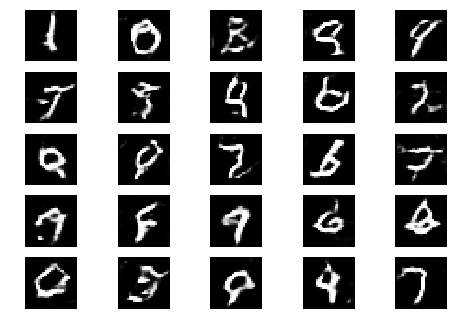

In [8]:
train(epochs = 2000, batchSize = 32, saveInterval = 100)

In [0]:
for number in range(0, 4000, 100):
  file = 'mnist_' + str(number) + '.png'
  
  try :
    files.download(file)
  except :
    None
    
print ("Images Downloaded To Local Drive")

Images Downloaded To Local Drive
